In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, Bidirectional, Reshape, Conv1D, GaussianNoise, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [8]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [10]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    lstm = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal'))
    lstm_1 = lstm(inputs)
    batch_norm1 = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal'))
    lstm_2_output = lstm_2(lstm_1_droput)
    batch_norm2 = BatchNormalization()(lstm_2_output)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model


## Discriminator

In [11]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [12]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [13]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # Threshhold
#         if(cur_gen_loss > 0.8):
#                 break;

    return history, history_val

## Visualization

In [14]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [15]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [16]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [17]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [18]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
6    2010-07-08    1.076000    1.168000    1.038000    1.164000    1.164000   
7    2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
8    2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
9    2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
...         ...         ...         ...         ...         ...         ...   
2641 2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2642 2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2643 2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2644 2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2645 2020-12-30  224.000000  232.199997  222.786667  231.593338  231.593338   

         Volume          Ma  
5     103825500    1.399867  
6     115671000    1.292000  
7      60759000    1.207067  
8      33037500    1.146267  
9      40201500    1.117600  
...         ...         ...  
2641   99519000  217.591333  
2642   68596800  219.138666  
2643   96835800  219.529999  
2644   68732400  217.442664  
2645  128538000  218.517999  

[2641 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.45723676681518555 sec Generator Loss: 0.8847887516021729,  Discriminator_loss: 1.2878172397613525
Time for epoch 53 is 0.45911502838134766 sec Generator Loss: 0.8738391995429993,  Discriminator_loss: 1.2955234050750732
Time for epoch 54 is 0.4683837890625 sec Generator Loss: 0.8648291230201721,  Discriminator_loss: 1.292576551437378
Time for epoch 55 is 0.45506763458251953 sec Generator Loss: 0.8718754053115845,  Discriminator_loss: 1.2956303358078003
Time for epoch 56 is 0.4552793502807617 sec Generator Loss: 0.8789598941802979,  Discriminator_loss: 1.2963815927505493
Time for epoch 57 is 0.4571707248687744 sec Generator Loss: 0.8478696346282959,  Discriminator_loss: 1.3212939500808716
Time for epoch 58 is 0.4560120105743408 sec Generator Loss: 0.8501245975494385,  Discriminator_loss: 1.319621205329895
Time for epoch 59 is 0.46266961097717285 sec Generator Loss: 0.8313094973564148,  Discriminator_loss: 1.3303866386413574
Time for epoch 60 is 0.4866445064544678 s

Time for epoch 121 is 0.5284132957458496 sec Generator Loss: 0.7847927212715149,  Discriminator_loss: 1.3601572513580322
Time for epoch 122 is 0.5030660629272461 sec Generator Loss: 0.7812544703483582,  Discriminator_loss: 1.3511505126953125
Time for epoch 123 is 0.46138691902160645 sec Generator Loss: 0.7772798538208008,  Discriminator_loss: 1.3562318086624146
Time for epoch 124 is 0.48087310791015625 sec Generator Loss: 0.7875304222106934,  Discriminator_loss: 1.3462275266647339
Time for epoch 125 is 0.5151467323303223 sec Generator Loss: 0.7802663445472717,  Discriminator_loss: 1.3547930717468262
Time for epoch 126 is 0.48391151428222656 sec Generator Loss: 0.786644458770752,  Discriminator_loss: 1.3497953414916992
Time for epoch 127 is 0.46898603439331055 sec Generator Loss: 0.7889894843101501,  Discriminator_loss: 1.348118543624878
Time for epoch 128 is 0.476229190826416 sec Generator Loss: 0.7841748595237732,  Discriminator_loss: 1.356069803237915
Time for epoch 129 is 0.46754407

Time for epoch 189 is 0.5334413051605225 sec Generator Loss: 0.7856844067573547,  Discriminator_loss: 1.3561686277389526
Time for epoch 190 is 0.5345847606658936 sec Generator Loss: 0.7928521037101746,  Discriminator_loss: 1.357702374458313
Time for epoch 191 is 0.4875340461730957 sec Generator Loss: 0.7877988219261169,  Discriminator_loss: 1.3601264953613281
Time for epoch 192 is 0.5167233943939209 sec Generator Loss: 0.793944776058197,  Discriminator_loss: 1.362907886505127
Time for epoch 193 is 0.47197961807250977 sec Generator Loss: 0.8023712635040283,  Discriminator_loss: 1.3584468364715576
Time for epoch 194 is 0.48667478561401367 sec Generator Loss: 0.7992875576019287,  Discriminator_loss: 1.3598538637161255
Time for epoch 195 is 0.5118227005004883 sec Generator Loss: 0.7926297783851624,  Discriminator_loss: 1.3547873497009277
Time for epoch 196 is 0.5051686763763428 sec Generator Loss: 0.7888604402542114,  Discriminator_loss: 1.35894775390625
Time for epoch 197 is 0.51007938385

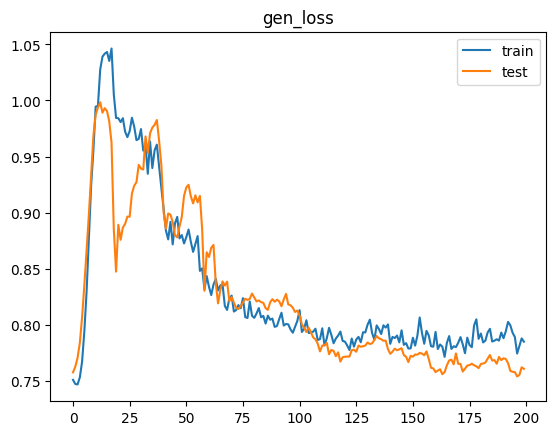

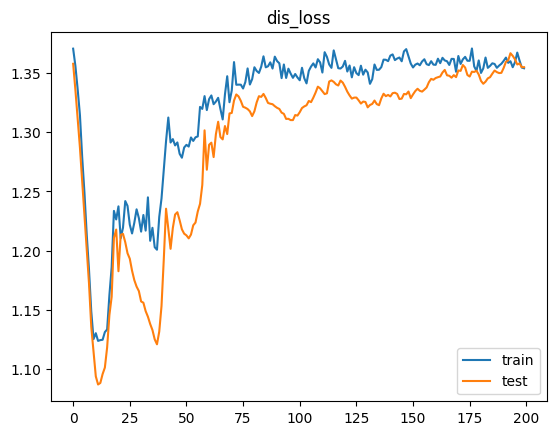

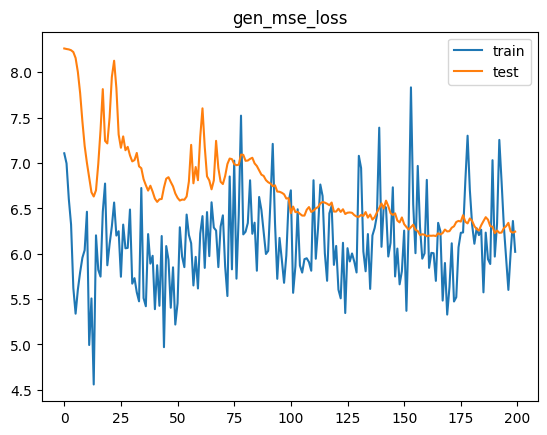

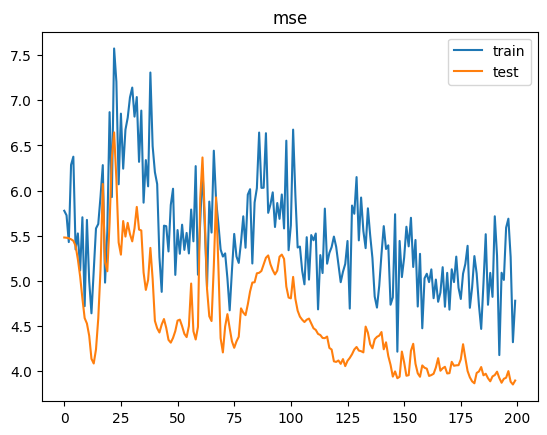

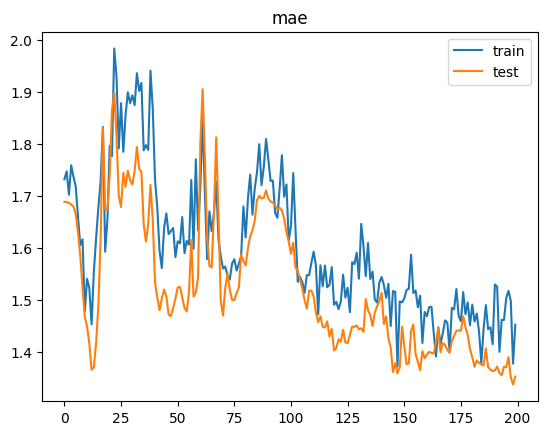

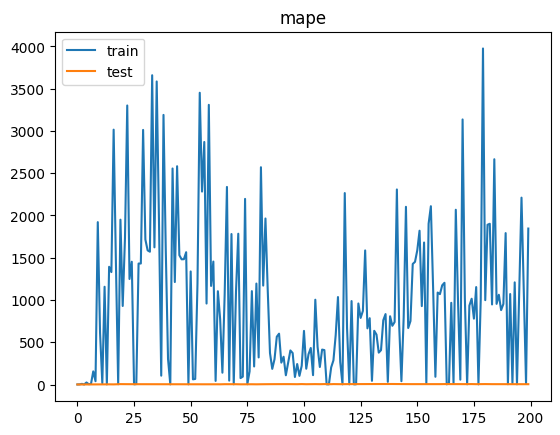

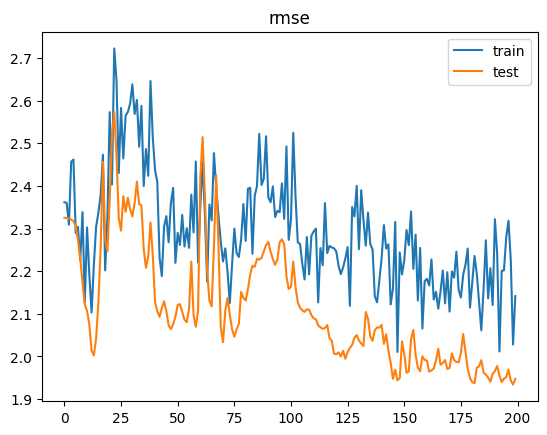

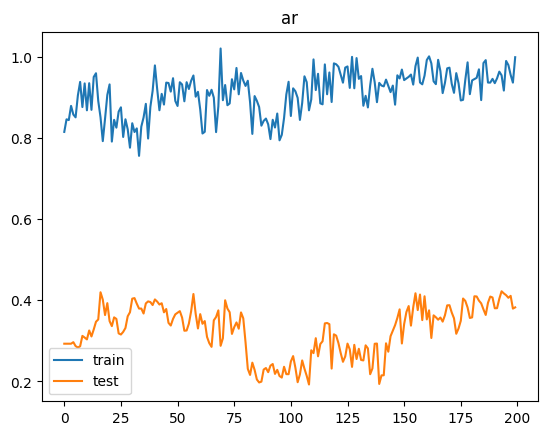

2/2 [==============================] - 1s 5ms/step


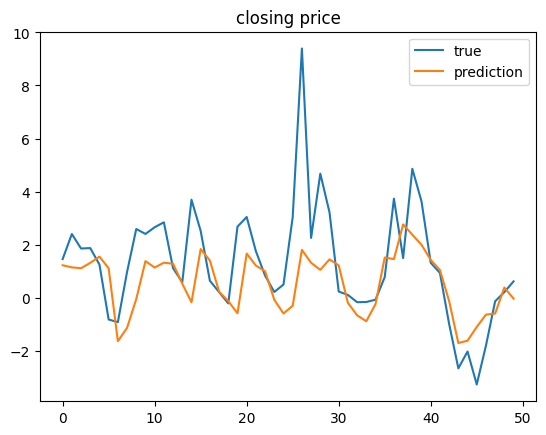

[MSE Baseline] train: 4.406635213870167  test: 3.868181586758766
Delta time with epochs = 200: 0:01:51.068283
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
               

Time for epoch 51 is 0.5108962059020996 sec Generator Loss: 0.9818792939186096,  Discriminator_loss: 1.199446201324463
Time for epoch 52 is 0.546699047088623 sec Generator Loss: 0.9963402152061462,  Discriminator_loss: 1.2094144821166992
Time for epoch 53 is 0.6333203315734863 sec Generator Loss: 0.9714323282241821,  Discriminator_loss: 1.226857304573059
Time for epoch 54 is 0.5774345397949219 sec Generator Loss: 0.9886151552200317,  Discriminator_loss: 1.2125649452209473
Time for epoch 55 is 0.5654599666595459 sec Generator Loss: 0.9803578853607178,  Discriminator_loss: 1.2026509046554565
Time for epoch 56 is 0.5773272514343262 sec Generator Loss: 0.9679920673370361,  Discriminator_loss: 1.2149150371551514
Time for epoch 57 is 0.549673318862915 sec Generator Loss: 0.9615077972412109,  Discriminator_loss: 1.2228648662567139
Time for epoch 58 is 0.5467400550842285 sec Generator Loss: 0.944438099861145,  Discriminator_loss: 1.236654281616211
Time for epoch 59 is 0.5480337142944336 sec Ge

Time for epoch 120 is 0.5075647830963135 sec Generator Loss: 0.8194074630737305,  Discriminator_loss: 1.3459280729293823
Time for epoch 121 is 0.568950891494751 sec Generator Loss: 0.8160232305526733,  Discriminator_loss: 1.3422712087631226
Time for epoch 122 is 0.5912606716156006 sec Generator Loss: 0.8262377381324768,  Discriminator_loss: 1.3345228433609009
Time for epoch 123 is 0.5759716033935547 sec Generator Loss: 0.8154690265655518,  Discriminator_loss: 1.3367695808410645
Time for epoch 124 is 0.5456757545471191 sec Generator Loss: 0.8178314566612244,  Discriminator_loss: 1.3366690874099731
Time for epoch 125 is 0.5758721828460693 sec Generator Loss: 0.8097831606864929,  Discriminator_loss: 1.3383522033691406
Time for epoch 126 is 0.5615396499633789 sec Generator Loss: 0.8210048675537109,  Discriminator_loss: 1.3384900093078613
Time for epoch 127 is 0.5333142280578613 sec Generator Loss: 0.8160578012466431,  Discriminator_loss: 1.3372586965560913
Time for epoch 128 is 0.527884960

Time for epoch 188 is 0.4706387519836426 sec Generator Loss: 0.7993094325065613,  Discriminator_loss: 1.3416767120361328
Time for epoch 189 is 0.47155284881591797 sec Generator Loss: 0.8023210167884827,  Discriminator_loss: 1.3389995098114014
Time for epoch 190 is 0.4608955383300781 sec Generator Loss: 0.8011079430580139,  Discriminator_loss: 1.3440773487091064
Time for epoch 191 is 0.5085978507995605 sec Generator Loss: 0.7982155084609985,  Discriminator_loss: 1.3459875583648682
Time for epoch 192 is 0.5098979473114014 sec Generator Loss: 0.8039628863334656,  Discriminator_loss: 1.3466086387634277
Time for epoch 193 is 0.5099451541900635 sec Generator Loss: 0.8000615239143372,  Discriminator_loss: 1.344181776046753
Time for epoch 194 is 0.5063066482543945 sec Generator Loss: 0.803138256072998,  Discriminator_loss: 1.347620964050293
Time for epoch 195 is 0.5373156070709229 sec Generator Loss: 0.7958828210830688,  Discriminator_loss: 1.3515197038650513
Time for epoch 196 is 0.5149486064

Time for epoch 257 is 0.5068259239196777 sec Generator Loss: 0.8058546781539917,  Discriminator_loss: 1.346884846687317
Time for epoch 258 is 0.5078465938568115 sec Generator Loss: 0.7974711656570435,  Discriminator_loss: 1.35390043258667
Time for epoch 259 is 0.5063192844390869 sec Generator Loss: 0.7942113876342773,  Discriminator_loss: 1.3449169397354126
Time for epoch 260 is 0.5064525604248047 sec Generator Loss: 0.8030903339385986,  Discriminator_loss: 1.3505370616912842
Time for epoch 261 is 0.5041985511779785 sec Generator Loss: 0.816547155380249,  Discriminator_loss: 1.344265341758728
Time for epoch 262 is 0.5081217288970947 sec Generator Loss: 0.797670841217041,  Discriminator_loss: 1.3468055725097656
Time for epoch 263 is 0.518242597579956 sec Generator Loss: 0.8014339804649353,  Discriminator_loss: 1.3490195274353027
Time for epoch 264 is 0.5052695274353027 sec Generator Loss: 0.7953664064407349,  Discriminator_loss: 1.34757661819458
Time for epoch 265 is 0.5014188289642334 

Time for epoch 326 is 0.5340015888214111 sec Generator Loss: 0.7906229496002197,  Discriminator_loss: 1.3473371267318726
Time for epoch 327 is 0.5414724349975586 sec Generator Loss: 0.7811998724937439,  Discriminator_loss: 1.3613961935043335
Time for epoch 328 is 0.533177375793457 sec Generator Loss: 0.7916077971458435,  Discriminator_loss: 1.34884774684906
Time for epoch 329 is 0.5342040061950684 sec Generator Loss: 0.7828037142753601,  Discriminator_loss: 1.351102352142334
Time for epoch 330 is 0.5367312431335449 sec Generator Loss: 0.7910342216491699,  Discriminator_loss: 1.3527647256851196
Time for epoch 331 is 0.5375881195068359 sec Generator Loss: 0.7906720042228699,  Discriminator_loss: 1.3576656579971313
Time for epoch 332 is 0.544879674911499 sec Generator Loss: 0.7806202173233032,  Discriminator_loss: 1.3573485612869263
Time for epoch 333 is 0.5065836906433105 sec Generator Loss: 0.7862027287483215,  Discriminator_loss: 1.3525089025497437
Time for epoch 334 is 0.5031976699829

Time for epoch 395 is 0.512274980545044 sec Generator Loss: 0.7941768765449524,  Discriminator_loss: 1.350315809249878
Time for epoch 396 is 0.5083048343658447 sec Generator Loss: 0.7879126071929932,  Discriminator_loss: 1.3546960353851318
Time for epoch 397 is 0.5034375190734863 sec Generator Loss: 0.7843453288078308,  Discriminator_loss: 1.3560378551483154
Time for epoch 398 is 0.5042765140533447 sec Generator Loss: 0.7943766117095947,  Discriminator_loss: 1.3576111793518066
Time for epoch 399 is 0.5142076015472412 sec Generator Loss: 0.7851243019104004,  Discriminator_loss: 1.3556368350982666
Time for epoch 400 is 0.5102624893188477 sec Generator Loss: 0.7950339317321777,  Discriminator_loss: 1.3469316959381104
Time for epoch 401 is 0.513580322265625 sec Generator Loss: 0.7799269556999207,  Discriminator_loss: 1.3616241216659546
Time for epoch 402 is 0.5020873546600342 sec Generator Loss: 0.7915831804275513,  Discriminator_loss: 1.358392357826233
Time for epoch 403 is 0.502812862396

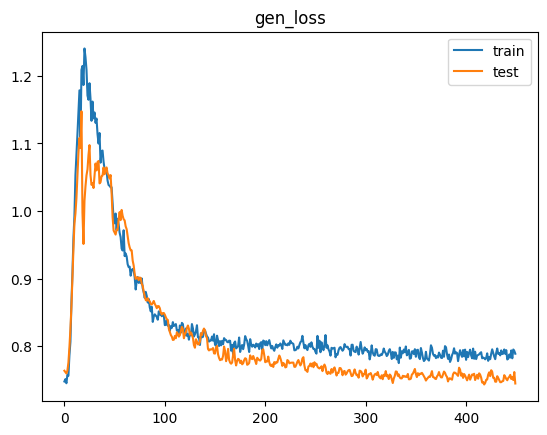

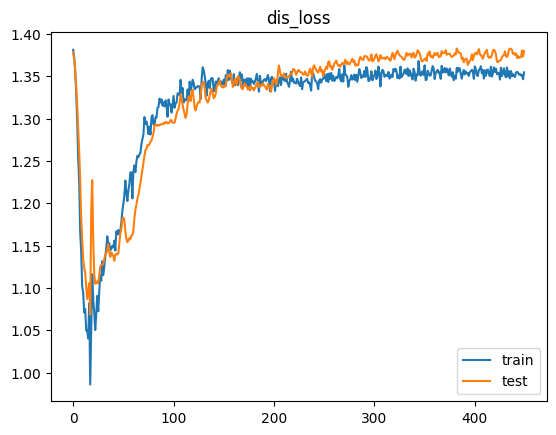

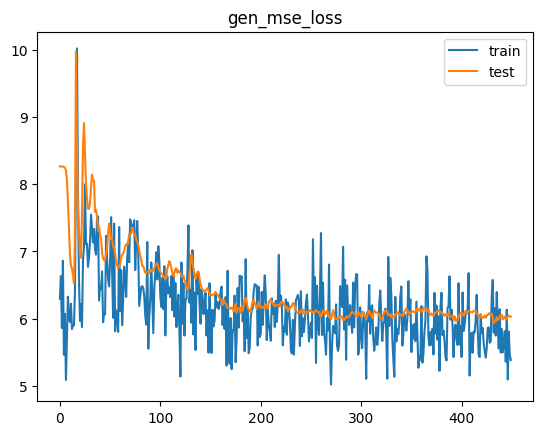

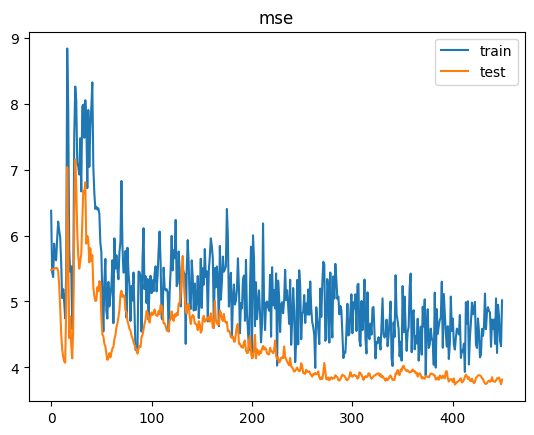

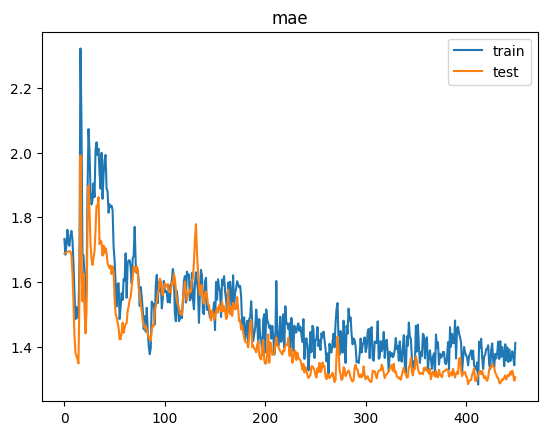

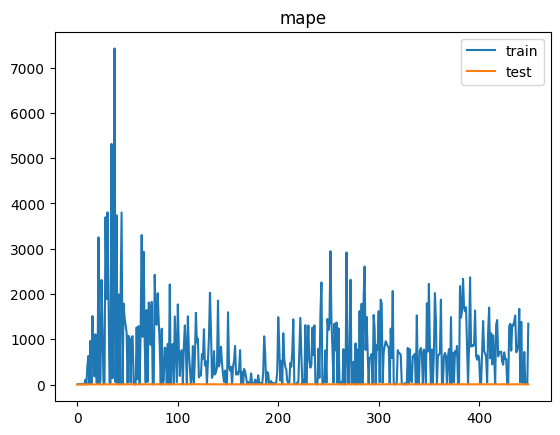

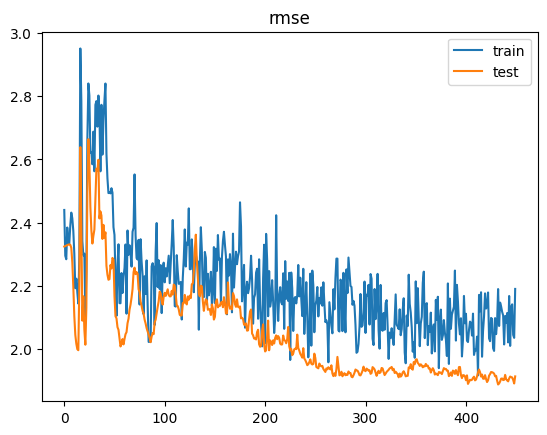

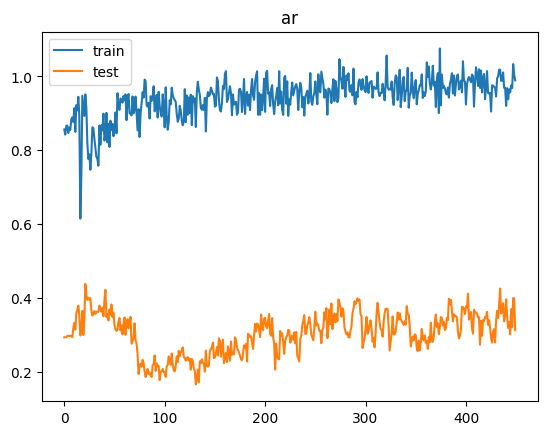

2/2 [==============================] - 1s 4ms/step


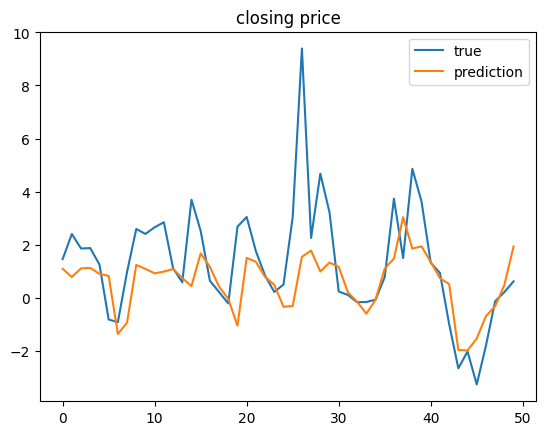

[MSE Baseline] train: 4.5901156910554315  test: 3.868181586758766
Delta time with epochs = 450: 0:04:09.906703
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.49446988105773926 sec Generator Loss: 0.8551849722862244,  Discriminator_loss: 1.3215320110321045
Time for epoch 52 is 0.5078134536743164 sec Generator Loss: 0.8573722839355469,  Discriminator_loss: 1.316069483757019
Time for epoch 53 is 0.5149269104003906 sec Generator Loss: 0.8552253842353821,  Discriminator_loss: 1.3036127090454102
Time for epoch 54 is 0.5165891647338867 sec Generator Loss: 0.846625804901123,  Discriminator_loss: 1.3208410739898682
Time for epoch 55 is 0.5139455795288086 sec Generator Loss: 0.85062575340271,  Discriminator_loss: 1.307578206062317
Time for epoch 56 is 0.5214464664459229 sec Generator Loss: 0.8594059348106384,  Discriminator_loss: 1.3006504774093628
Time for epoch 57 is 0.5239145755767822 sec Generator Loss: 0.8419302105903625,  Discriminator_loss: 1.2988284826278687
Time for epoch 58 is 0.5137736797332764 sec Generator Loss: 0.8306170701980591,  Discriminator_loss: 1.3181883096694946
Time for epoch 59 is 0.5096139907836914 sec 

Time for epoch 120 is 0.5486054420471191 sec Generator Loss: 0.8022448420524597,  Discriminator_loss: 1.3625181913375854
Time for epoch 121 is 0.5580165386199951 sec Generator Loss: 0.8102282881736755,  Discriminator_loss: 1.3546233177185059
Time for epoch 122 is 0.5924882888793945 sec Generator Loss: 0.8064669966697693,  Discriminator_loss: 1.3544275760650635
Time for epoch 123 is 0.5408766269683838 sec Generator Loss: 0.8012033700942993,  Discriminator_loss: 1.3496021032333374
Time for epoch 124 is 0.5554728507995605 sec Generator Loss: 0.8054165840148926,  Discriminator_loss: 1.350656270980835
Time for epoch 125 is 0.5357584953308105 sec Generator Loss: 0.8023930788040161,  Discriminator_loss: 1.349501609802246
Time for epoch 126 is 0.5645842552185059 sec Generator Loss: 0.7957720160484314,  Discriminator_loss: 1.3567781448364258
Time for epoch 127 is 0.5518860816955566 sec Generator Loss: 0.7987709045410156,  Discriminator_loss: 1.3590410947799683
Time for epoch 128 is 0.5750453472

Time for epoch 188 is 0.5005497932434082 sec Generator Loss: 0.7937366366386414,  Discriminator_loss: 1.3581757545471191
Time for epoch 189 is 0.48630309104919434 sec Generator Loss: 0.7851465344429016,  Discriminator_loss: 1.3572027683258057
Time for epoch 190 is 0.4817771911621094 sec Generator Loss: 0.7923035621643066,  Discriminator_loss: 1.357046365737915
Time for epoch 191 is 0.506319522857666 sec Generator Loss: 0.7822203040122986,  Discriminator_loss: 1.3573110103607178
Time for epoch 192 is 0.5408070087432861 sec Generator Loss: 0.7812392115592957,  Discriminator_loss: 1.3580436706542969
Time for epoch 193 is 0.5354692935943604 sec Generator Loss: 0.7833013534545898,  Discriminator_loss: 1.3547180891036987
Time for epoch 194 is 0.5324392318725586 sec Generator Loss: 0.7868005633354187,  Discriminator_loss: 1.3508721590042114
Time for epoch 195 is 0.5399777889251709 sec Generator Loss: 0.787353515625,  Discriminator_loss: 1.3585906028747559
Time for epoch 196 is 0.5397317409515

Time for epoch 257 is 0.5276339054107666 sec Generator Loss: 0.7860900163650513,  Discriminator_loss: 1.3631348609924316
Time for epoch 258 is 0.517791748046875 sec Generator Loss: 0.7949313521385193,  Discriminator_loss: 1.3487012386322021
Time for epoch 259 is 0.5166118144989014 sec Generator Loss: 0.7920012474060059,  Discriminator_loss: 1.3533250093460083
Time for epoch 260 is 0.5191619396209717 sec Generator Loss: 0.7876740097999573,  Discriminator_loss: 1.3562405109405518
Time for epoch 261 is 0.5227372646331787 sec Generator Loss: 0.7909386157989502,  Discriminator_loss: 1.346733570098877
Time for epoch 262 is 0.5134477615356445 sec Generator Loss: 0.7937394976615906,  Discriminator_loss: 1.3536523580551147
Time for epoch 263 is 0.5208358764648438 sec Generator Loss: 0.7861289381980896,  Discriminator_loss: 1.353654384613037
Time for epoch 264 is 0.5261735916137695 sec Generator Loss: 0.7867224812507629,  Discriminator_loss: 1.3657835721969604
Time for epoch 265 is 0.52792215347

Time for epoch 325 is 0.5134930610656738 sec Generator Loss: 0.7863509058952332,  Discriminator_loss: 1.3488073348999023
Time for epoch 326 is 0.5154688358306885 sec Generator Loss: 0.7901326417922974,  Discriminator_loss: 1.3501390218734741
Time for epoch 327 is 0.5152490139007568 sec Generator Loss: 0.7905676960945129,  Discriminator_loss: 1.3571062088012695
Time for epoch 328 is 0.525993824005127 sec Generator Loss: 0.7833328247070312,  Discriminator_loss: 1.3611271381378174
Time for epoch 329 is 0.524144172668457 sec Generator Loss: 0.7756473422050476,  Discriminator_loss: 1.3665229082107544
Time for epoch 330 is 0.5244636535644531 sec Generator Loss: 0.7769721150398254,  Discriminator_loss: 1.3685375452041626
Time for epoch 331 is 0.5343327522277832 sec Generator Loss: 0.783259928226471,  Discriminator_loss: 1.3611786365509033
Time for epoch 332 is 0.5633924007415771 sec Generator Loss: 0.7874712944030762,  Discriminator_loss: 1.3564293384552002
Time for epoch 333 is 0.55724477767

Time for epoch 394 is 0.5320274829864502 sec Generator Loss: 0.782378077507019,  Discriminator_loss: 1.3510099649429321
Time for epoch 395 is 0.5350606441497803 sec Generator Loss: 0.7880880236625671,  Discriminator_loss: 1.3535847663879395
Time for epoch 396 is 0.5375988483428955 sec Generator Loss: 0.8026925325393677,  Discriminator_loss: 1.3491063117980957
Time for epoch 397 is 0.5505461692810059 sec Generator Loss: 0.7912905812263489,  Discriminator_loss: 1.3580551147460938
Time for epoch 398 is 0.5469415187835693 sec Generator Loss: 0.790280282497406,  Discriminator_loss: 1.354482889175415
Time for epoch 399 is 0.5478734970092773 sec Generator Loss: 0.7830291390419006,  Discriminator_loss: 1.3578506708145142
Time for epoch 400 is 0.5623133182525635 sec Generator Loss: 0.7791922092437744,  Discriminator_loss: 1.3577409982681274
Time for epoch 401 is 0.633190393447876 sec Generator Loss: 0.782524049282074,  Discriminator_loss: 1.352820873260498
Time for epoch 402 is 0.61486268043518

Time for epoch 463 is 0.5207705497741699 sec Generator Loss: 0.7931164503097534,  Discriminator_loss: 1.3530312776565552
Time for epoch 464 is 0.5254092216491699 sec Generator Loss: 0.7954702973365784,  Discriminator_loss: 1.3557891845703125
Time for epoch 465 is 0.5210809707641602 sec Generator Loss: 0.7916144132614136,  Discriminator_loss: 1.349577784538269
Time for epoch 466 is 0.5385935306549072 sec Generator Loss: 0.7929020524024963,  Discriminator_loss: 1.3570826053619385
Time for epoch 467 is 0.5338363647460938 sec Generator Loss: 0.7900364995002747,  Discriminator_loss: 1.352192759513855
Time for epoch 468 is 0.5377302169799805 sec Generator Loss: 0.7864338755607605,  Discriminator_loss: 1.3541536331176758
Time for epoch 469 is 0.5274655818939209 sec Generator Loss: 0.7939701080322266,  Discriminator_loss: 1.3487924337387085
Time for epoch 470 is 0.5359656810760498 sec Generator Loss: 0.7974464893341064,  Discriminator_loss: 1.3456553220748901
Time for epoch 471 is 0.5232582092

Time for epoch 531 is 0.49553394317626953 sec Generator Loss: 0.8016059398651123,  Discriminator_loss: 1.350514531135559
Time for epoch 532 is 0.4982595443725586 sec Generator Loss: 0.7939574718475342,  Discriminator_loss: 1.3493050336837769
Time for epoch 533 is 0.500481367111206 sec Generator Loss: 0.7909250259399414,  Discriminator_loss: 1.3456952571868896
Time for epoch 534 is 1.068880558013916 sec Generator Loss: 0.8009414672851562,  Discriminator_loss: 1.3433321714401245
Time for epoch 535 is 0.5139551162719727 sec Generator Loss: 0.8050774931907654,  Discriminator_loss: 1.3417606353759766
Time for epoch 536 is 0.5125555992126465 sec Generator Loss: 0.7860234975814819,  Discriminator_loss: 1.360234260559082
Time for epoch 537 is 0.5057241916656494 sec Generator Loss: 0.8006684184074402,  Discriminator_loss: 1.3429874181747437
Time for epoch 538 is 0.5085201263427734 sec Generator Loss: 0.7925034761428833,  Discriminator_loss: 1.3504600524902344
Time for epoch 539 is 0.49950528144

Time for epoch 599 is 0.504370927810669 sec Generator Loss: 0.8053380846977234,  Discriminator_loss: 1.3330738544464111
Time for epoch 600 is 0.4983839988708496 sec Generator Loss: 0.7981554269790649,  Discriminator_loss: 1.3421846628189087
Time for epoch 601 is 0.5048923492431641 sec Generator Loss: 0.8006344437599182,  Discriminator_loss: 1.3526935577392578
Time for epoch 602 is 0.5083613395690918 sec Generator Loss: 0.802008867263794,  Discriminator_loss: 1.34000825881958
Time for epoch 603 is 0.505789041519165 sec Generator Loss: 0.7908431887626648,  Discriminator_loss: 1.3485738039016724
Time for epoch 604 is 0.5130002498626709 sec Generator Loss: 0.7880100011825562,  Discriminator_loss: 1.3529943227767944
Time for epoch 605 is 0.5039045810699463 sec Generator Loss: 0.7893226146697998,  Discriminator_loss: 1.3557389974594116
Time for epoch 606 is 0.5014564990997314 sec Generator Loss: 0.8089828491210938,  Discriminator_loss: 1.3373254537582397
Time for epoch 607 is 0.5035219192504

Time for epoch 667 is 0.4970684051513672 sec Generator Loss: 0.8041954040527344,  Discriminator_loss: 1.3394553661346436
Time for epoch 668 is 0.5024878978729248 sec Generator Loss: 0.8009350895881653,  Discriminator_loss: 1.34352445602417
Time for epoch 669 is 0.5106346607208252 sec Generator Loss: 0.8072308897972107,  Discriminator_loss: 1.3394014835357666
Time for epoch 670 is 0.5047390460968018 sec Generator Loss: 0.8105643391609192,  Discriminator_loss: 1.333491563796997
Time for epoch 671 is 0.4997565746307373 sec Generator Loss: 0.7969083189964294,  Discriminator_loss: 1.3474488258361816
Time for epoch 672 is 0.5298054218292236 sec Generator Loss: 0.8080761432647705,  Discriminator_loss: 1.3424701690673828
Time for epoch 673 is 0.4999730587005615 sec Generator Loss: 0.8050312995910645,  Discriminator_loss: 1.3383879661560059
Time for epoch 674 is 0.5177586078643799 sec Generator Loss: 0.7952598333358765,  Discriminator_loss: 1.3565603494644165
Time for epoch 675 is 0.53401780128

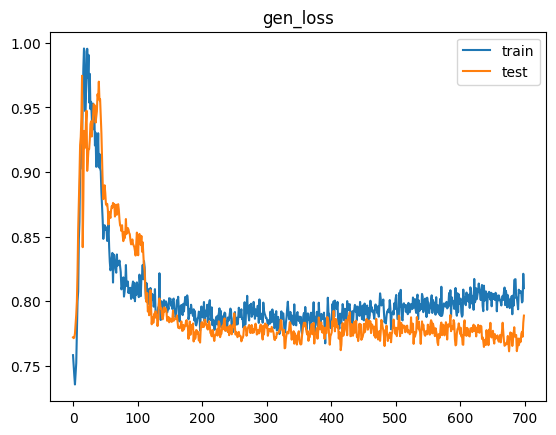

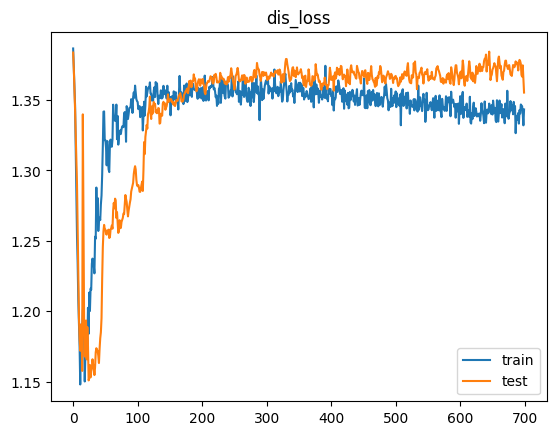

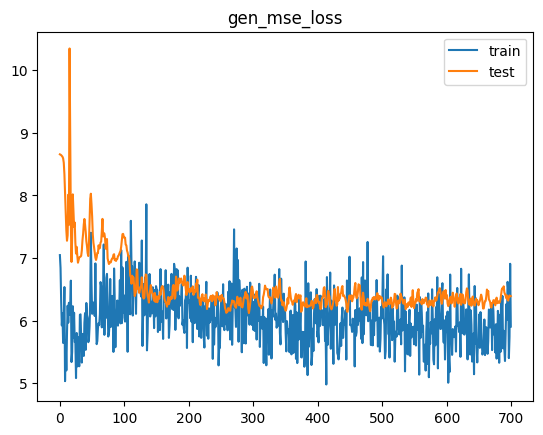

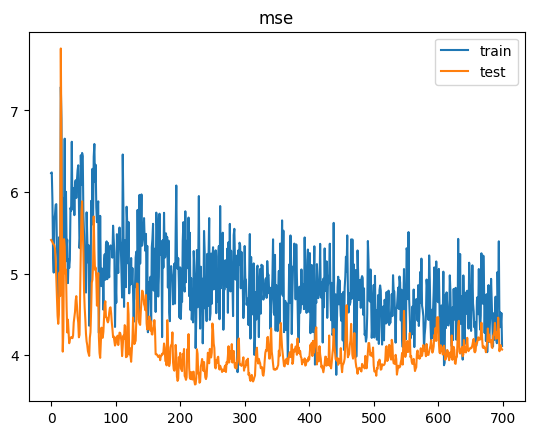

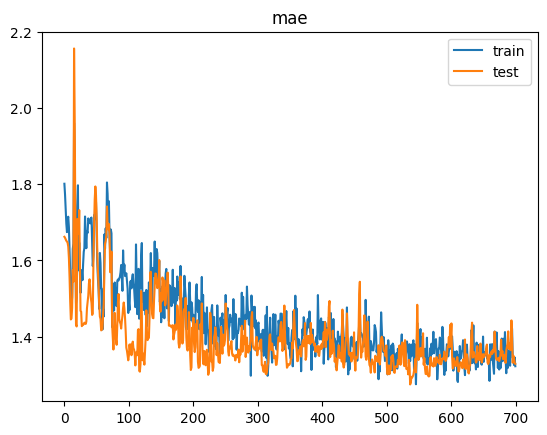

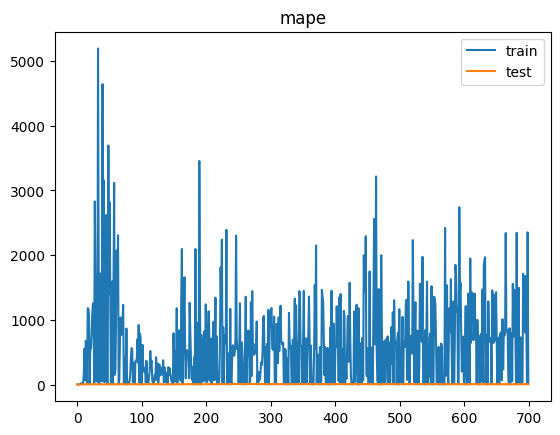

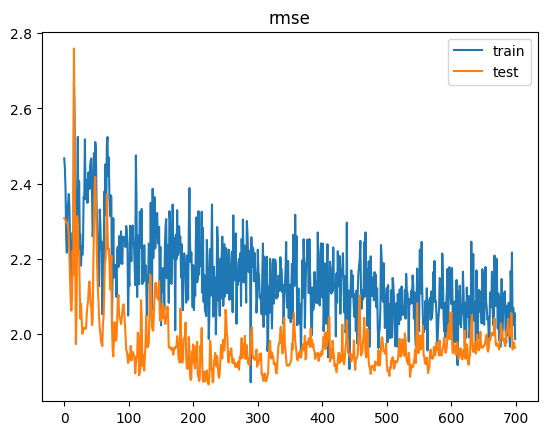

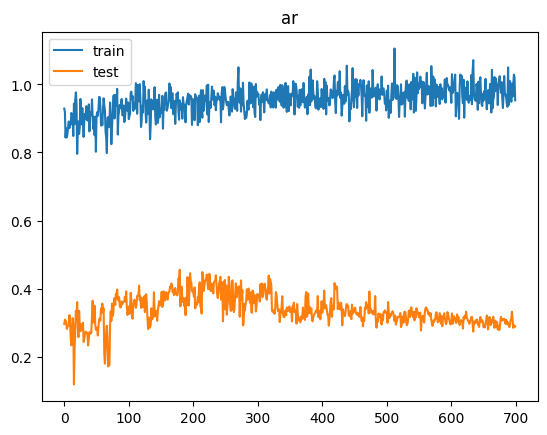

2/2 [==============================] - 0s 3ms/step


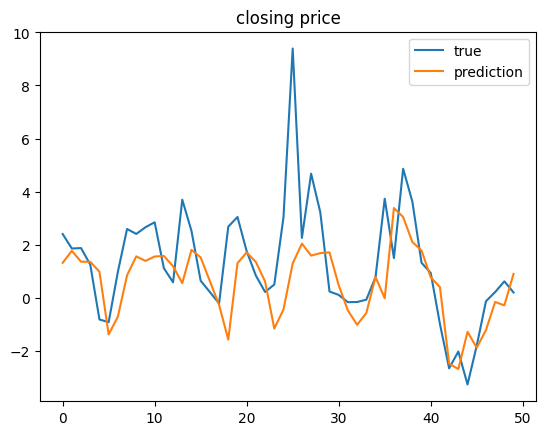

[MSE Baseline] train: 4.164766376412616  test: 3.7469059248471765
Delta time with epochs = 700: 0:06:25.811552
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.3614323139190674 sec Generator Loss: 0.9000084400177002,  Discriminator_loss: 1.2745155096054077
Time for epoch 52 is 0.5202279090881348 sec Generator Loss: 0.8825299739837646,  Discriminator_loss: 1.2864426374435425
Time for epoch 53 is 0.515822172164917 sec Generator Loss: 0.8836343288421631,  Discriminator_loss: 1.2708040475845337
Time for epoch 54 is 0.5123288631439209 sec Generator Loss: 0.8627384305000305,  Discriminator_loss: 1.2991793155670166
Time for epoch 55 is 0.515251636505127 sec Generator Loss: 0.8571993112564087,  Discriminator_loss: 1.3106869459152222
Time for epoch 56 is 0.5156550407409668 sec Generator Loss: 0.8731654286384583,  Discriminator_loss: 1.2805182933807373
Time for epoch 57 is 0.5244529247283936 sec Generator Loss: 0.8857783675193787,  Discriminator_loss: 1.2550286054611206
Time for epoch 58 is 0.542231559753418 sec Generator Loss: 0.849951982498169,  Discriminator_loss: 1.2797952890396118
Time for epoch 59 is 0.5568954944610596 sec 

Time for epoch 120 is 0.512566089630127 sec Generator Loss: 0.7919701337814331,  Discriminator_loss: 1.365628719329834
Time for epoch 121 is 0.5140590667724609 sec Generator Loss: 0.7827109098434448,  Discriminator_loss: 1.3629237413406372
Time for epoch 122 is 0.5155534744262695 sec Generator Loss: 0.7849066853523254,  Discriminator_loss: 1.362585425376892
Time for epoch 123 is 0.5168023109436035 sec Generator Loss: 0.7876661419868469,  Discriminator_loss: 1.3565983772277832
Time for epoch 124 is 0.5122768878936768 sec Generator Loss: 0.7955459356307983,  Discriminator_loss: 1.345981478691101
Time for epoch 125 is 0.5102219581604004 sec Generator Loss: 0.7916661500930786,  Discriminator_loss: 1.3549729585647583
Time for epoch 126 is 0.5130946636199951 sec Generator Loss: 0.7988473176956177,  Discriminator_loss: 1.3517229557037354
Time for epoch 127 is 0.5118794441223145 sec Generator Loss: 0.8003478646278381,  Discriminator_loss: 1.3486183881759644
Time for epoch 128 is 0.509408473968

Time for epoch 188 is 0.5148515701293945 sec Generator Loss: 0.7877513766288757,  Discriminator_loss: 1.3556801080703735
Time for epoch 189 is 0.5089125633239746 sec Generator Loss: 0.779619038105011,  Discriminator_loss: 1.3495163917541504
Time for epoch 190 is 0.5078263282775879 sec Generator Loss: 0.7831797003746033,  Discriminator_loss: 1.3526718616485596
Time for epoch 191 is 0.5074374675750732 sec Generator Loss: 0.7862473130226135,  Discriminator_loss: 1.355197787284851
Time for epoch 192 is 0.5116794109344482 sec Generator Loss: 0.7906047105789185,  Discriminator_loss: 1.3433964252471924
Time for epoch 193 is 0.5085363388061523 sec Generator Loss: 0.7874959707260132,  Discriminator_loss: 1.3495063781738281
Time for epoch 194 is 0.5086164474487305 sec Generator Loss: 0.7834178805351257,  Discriminator_loss: 1.3489749431610107
Time for epoch 195 is 0.5065655708312988 sec Generator Loss: 0.790016233921051,  Discriminator_loss: 1.3481286764144897
Time for epoch 196 is 0.51252985000

Time for epoch 256 is 0.514254093170166 sec Generator Loss: 0.7861753702163696,  Discriminator_loss: 1.3572276830673218
Time for epoch 257 is 0.5181951522827148 sec Generator Loss: 0.7838760614395142,  Discriminator_loss: 1.3601033687591553
Time for epoch 258 is 0.5171380043029785 sec Generator Loss: 0.7936807870864868,  Discriminator_loss: 1.3515087366104126
Time for epoch 259 is 0.5224485397338867 sec Generator Loss: 0.7920575141906738,  Discriminator_loss: 1.3591845035552979
Time for epoch 260 is 0.5148518085479736 sec Generator Loss: 0.7868466377258301,  Discriminator_loss: 1.359691858291626
Time for epoch 261 is 0.5181236267089844 sec Generator Loss: 0.8065194487571716,  Discriminator_loss: 1.3439902067184448
Time for epoch 262 is 0.5159051418304443 sec Generator Loss: 0.7922617197036743,  Discriminator_loss: 1.34774649143219
Time for epoch 263 is 0.5142824649810791 sec Generator Loss: 0.7825755476951599,  Discriminator_loss: 1.3606194257736206
Time for epoch 264 is 0.513095617294

Time for epoch 324 is 0.5110869407653809 sec Generator Loss: 0.7909008860588074,  Discriminator_loss: 1.3534916639328003
Time for epoch 325 is 0.5044302940368652 sec Generator Loss: 0.7988264560699463,  Discriminator_loss: 1.3509387969970703
Time for epoch 326 is 0.5063037872314453 sec Generator Loss: 0.7983629107475281,  Discriminator_loss: 1.348543405532837
Time for epoch 327 is 0.5075197219848633 sec Generator Loss: 0.7842506170272827,  Discriminator_loss: 1.351744532585144
Time for epoch 328 is 0.5055351257324219 sec Generator Loss: 0.7941862344741821,  Discriminator_loss: 1.3467488288879395
Time for epoch 329 is 0.5018353462219238 sec Generator Loss: 0.7953919172286987,  Discriminator_loss: 1.356152892112732
Time for epoch 330 is 0.5341548919677734 sec Generator Loss: 0.7974327802658081,  Discriminator_loss: 1.3438124656677246
Time for epoch 331 is 0.5775682926177979 sec Generator Loss: 0.7817357778549194,  Discriminator_loss: 1.3601247072219849
Time for epoch 332 is 0.60030436515

Time for epoch 392 is 0.5597670078277588 sec Generator Loss: 0.7924692630767822,  Discriminator_loss: 1.3527673482894897
Time for epoch 393 is 0.5027406215667725 sec Generator Loss: 0.784656286239624,  Discriminator_loss: 1.3505361080169678
Time for epoch 394 is 0.5173683166503906 sec Generator Loss: 0.780561089515686,  Discriminator_loss: 1.3610987663269043
Time for epoch 395 is 0.5170941352844238 sec Generator Loss: 0.7878420352935791,  Discriminator_loss: 1.354636788368225
Time for epoch 396 is 0.52616286277771 sec Generator Loss: 0.7914305329322815,  Discriminator_loss: 1.3595596551895142
Time for epoch 397 is 0.512944221496582 sec Generator Loss: 0.7877212166786194,  Discriminator_loss: 1.3599367141723633
Time for epoch 398 is 0.5132262706756592 sec Generator Loss: 0.7879453301429749,  Discriminator_loss: 1.3579405546188354
Time for epoch 399 is 0.5191643238067627 sec Generator Loss: 0.7873572111129761,  Discriminator_loss: 1.3563588857650757
Time for epoch 400 is 0.51206254959106

Time for epoch 461 is 0.5116181373596191 sec Generator Loss: 0.7873185873031616,  Discriminator_loss: 1.3578722476959229
Time for epoch 462 is 0.5243175029754639 sec Generator Loss: 0.7959576845169067,  Discriminator_loss: 1.3495912551879883
Time for epoch 463 is 0.5135471820831299 sec Generator Loss: 0.7790256142616272,  Discriminator_loss: 1.3604927062988281
Time for epoch 464 is 0.5115573406219482 sec Generator Loss: 0.7725849151611328,  Discriminator_loss: 1.365217685699463
Time for epoch 465 is 0.5134129524230957 sec Generator Loss: 0.7956476211547852,  Discriminator_loss: 1.3521134853363037
Time for epoch 466 is 0.5108170509338379 sec Generator Loss: 0.7834064960479736,  Discriminator_loss: 1.3504337072372437
Time for epoch 467 is 0.511523962020874 sec Generator Loss: 0.7790381908416748,  Discriminator_loss: 1.3540005683898926
Time for epoch 468 is 0.5468149185180664 sec Generator Loss: 0.7871982455253601,  Discriminator_loss: 1.357459545135498
Time for epoch 469 is 0.51986837387

Time for epoch 529 is 0.5409269332885742 sec Generator Loss: 0.7964776754379272,  Discriminator_loss: 1.3486659526824951
Time for epoch 530 is 0.5901527404785156 sec Generator Loss: 0.7884196639060974,  Discriminator_loss: 1.3519638776779175
Time for epoch 531 is 0.5248913764953613 sec Generator Loss: 0.784416913986206,  Discriminator_loss: 1.3550527095794678
Time for epoch 532 is 0.5178956985473633 sec Generator Loss: 0.7818549871444702,  Discriminator_loss: 1.3558849096298218
Time for epoch 533 is 0.5155129432678223 sec Generator Loss: 0.7972548007965088,  Discriminator_loss: 1.351423740386963
Time for epoch 534 is 0.5241949558258057 sec Generator Loss: 0.7838494181632996,  Discriminator_loss: 1.3531908988952637
Time for epoch 535 is 0.5301244258880615 sec Generator Loss: 0.7916408181190491,  Discriminator_loss: 1.3502192497253418
Time for epoch 536 is 0.5266480445861816 sec Generator Loss: 0.7846859097480774,  Discriminator_loss: 1.3528964519500732
Time for epoch 537 is 0.5201888084

Time for epoch 597 is 0.5164363384246826 sec Generator Loss: 0.7918340563774109,  Discriminator_loss: 1.3505281209945679
Time for epoch 598 is 0.5163187980651855 sec Generator Loss: 0.7888826727867126,  Discriminator_loss: 1.3500125408172607
Time for epoch 599 is 0.5138847827911377 sec Generator Loss: 0.8113656044006348,  Discriminator_loss: 1.339948058128357
Time for epoch 600 is 0.5110194683074951 sec Generator Loss: 0.7835798263549805,  Discriminator_loss: 1.3576797246932983
Time for epoch 601 is 0.5389220714569092 sec Generator Loss: 0.7925913333892822,  Discriminator_loss: 1.3510512113571167
Time for epoch 602 is 0.618417501449585 sec Generator Loss: 0.7915759682655334,  Discriminator_loss: 1.3531297445297241
Time for epoch 603 is 0.5617232322692871 sec Generator Loss: 0.7943052053451538,  Discriminator_loss: 1.3515390157699585
Time for epoch 604 is 0.5622999668121338 sec Generator Loss: 0.7937270402908325,  Discriminator_loss: 1.3473238945007324
Time for epoch 605 is 0.5563738346

Time for epoch 665 is 0.5104079246520996 sec Generator Loss: 0.7903586626052856,  Discriminator_loss: 1.3514255285263062
Time for epoch 666 is 0.5133230686187744 sec Generator Loss: 0.7860626578330994,  Discriminator_loss: 1.3545714616775513
Time for epoch 667 is 0.5363366603851318 sec Generator Loss: 0.7837954759597778,  Discriminator_loss: 1.3556797504425049
Time for epoch 668 is 0.5240628719329834 sec Generator Loss: 0.7985343933105469,  Discriminator_loss: 1.349384069442749
Time for epoch 669 is 0.5149013996124268 sec Generator Loss: 0.7900784015655518,  Discriminator_loss: 1.3470103740692139
Time for epoch 670 is 0.5153782367706299 sec Generator Loss: 0.8018936514854431,  Discriminator_loss: 1.3443783521652222
Time for epoch 671 is 0.5135140419006348 sec Generator Loss: 0.7988297343254089,  Discriminator_loss: 1.3433899879455566
Time for epoch 672 is 0.5046188831329346 sec Generator Loss: 0.7963622808456421,  Discriminator_loss: 1.3491336107254028
Time for epoch 673 is 0.516466856

Time for epoch 733 is 0.5447640419006348 sec Generator Loss: 0.7995108366012573,  Discriminator_loss: 1.3338277339935303
Time for epoch 734 is 0.5461726188659668 sec Generator Loss: 0.7959177494049072,  Discriminator_loss: 1.3474195003509521
Time for epoch 735 is 0.5632529258728027 sec Generator Loss: 0.8052763938903809,  Discriminator_loss: 1.3519999980926514
Time for epoch 736 is 0.5353679656982422 sec Generator Loss: 0.8067958950996399,  Discriminator_loss: 1.3430750370025635
Time for epoch 737 is 0.5481390953063965 sec Generator Loss: 0.8080472350120544,  Discriminator_loss: 1.3405888080596924
Time for epoch 738 is 0.5654430389404297 sec Generator Loss: 0.8051930665969849,  Discriminator_loss: 1.3412314653396606
Time for epoch 739 is 0.556133508682251 sec Generator Loss: 0.8148592114448547,  Discriminator_loss: 1.3329943418502808
Time for epoch 740 is 0.5423603057861328 sec Generator Loss: 0.7934773564338684,  Discriminator_loss: 1.3484177589416504
Time for epoch 741 is 0.542472124

Time for epoch 802 is 0.5121047496795654 sec Generator Loss: 0.7983341217041016,  Discriminator_loss: 1.3367996215820312
Time for epoch 803 is 0.5075604915618896 sec Generator Loss: 0.7859872579574585,  Discriminator_loss: 1.3422973155975342
Time for epoch 804 is 0.5120105743408203 sec Generator Loss: 0.7958112955093384,  Discriminator_loss: 1.3469573259353638
Time for epoch 805 is 0.5272042751312256 sec Generator Loss: 0.8007630705833435,  Discriminator_loss: 1.3386116027832031
Time for epoch 806 is 0.514495849609375 sec Generator Loss: 0.7948381900787354,  Discriminator_loss: 1.3480310440063477
Time for epoch 807 is 0.5139217376708984 sec Generator Loss: 0.7966875433921814,  Discriminator_loss: 1.3504215478897095
Time for epoch 808 is 0.5164127349853516 sec Generator Loss: 0.8054117560386658,  Discriminator_loss: 1.3382961750030518
Time for epoch 809 is 0.5102238655090332 sec Generator Loss: 0.809956967830658,  Discriminator_loss: 1.350854516029358
Time for epoch 810 is 0.51375269889

Time for epoch 871 is 0.5453295707702637 sec Generator Loss: 0.8086079955101013,  Discriminator_loss: 1.3413978815078735
Time for epoch 872 is 0.5690999031066895 sec Generator Loss: 0.8051316142082214,  Discriminator_loss: 1.3433501720428467
Time for epoch 873 is 0.5478179454803467 sec Generator Loss: 0.797230064868927,  Discriminator_loss: 1.3492108583450317
Time for epoch 874 is 0.5598733425140381 sec Generator Loss: 0.7914037108421326,  Discriminator_loss: 1.3427107334136963
Time for epoch 875 is 0.5538115501403809 sec Generator Loss: 0.7983567118644714,  Discriminator_loss: 1.3419331312179565
Time for epoch 876 is 0.5556261539459229 sec Generator Loss: 0.8036324977874756,  Discriminator_loss: 1.3290737867355347
Time for epoch 877 is 0.5281763076782227 sec Generator Loss: 0.7953224778175354,  Discriminator_loss: 1.342453956604004
Time for epoch 878 is 0.5257809162139893 sec Generator Loss: 0.7890939712524414,  Discriminator_loss: 1.3552995920181274
Time for epoch 879 is 0.5158741474

Time for epoch 939 is 0.5094742774963379 sec Generator Loss: 0.8041163086891174,  Discriminator_loss: 1.3371708393096924
Time for epoch 940 is 0.5114438533782959 sec Generator Loss: 0.8061841726303101,  Discriminator_loss: 1.3360134363174438
Time for epoch 941 is 0.5061907768249512 sec Generator Loss: 0.805488646030426,  Discriminator_loss: 1.3409831523895264
Time for epoch 942 is 0.5107996463775635 sec Generator Loss: 0.8060115575790405,  Discriminator_loss: 1.3375908136367798
Time for epoch 943 is 0.5140464305877686 sec Generator Loss: 0.8016083836555481,  Discriminator_loss: 1.3467776775360107
Time for epoch 944 is 0.5236461162567139 sec Generator Loss: 0.7901233434677124,  Discriminator_loss: 1.350837230682373
Time for epoch 945 is 0.5135214328765869 sec Generator Loss: 0.7969112992286682,  Discriminator_loss: 1.341923713684082
Time for epoch 946 is 0.5120742321014404 sec Generator Loss: 0.7988141775131226,  Discriminator_loss: 1.3470228910446167
Time for epoch 947 is 0.52457499504

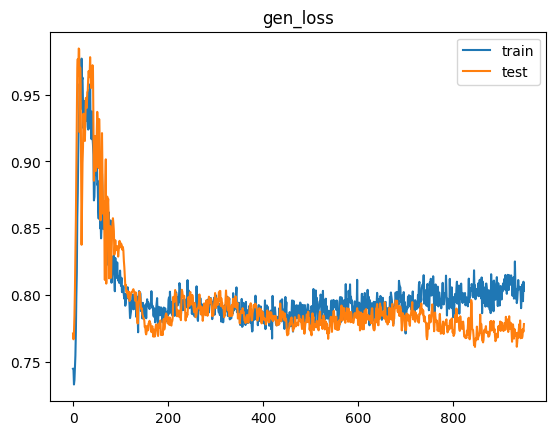

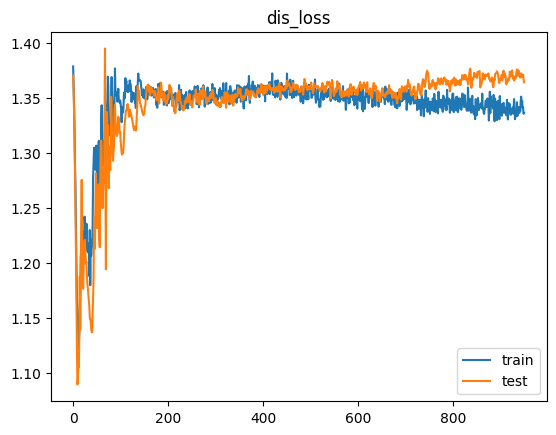

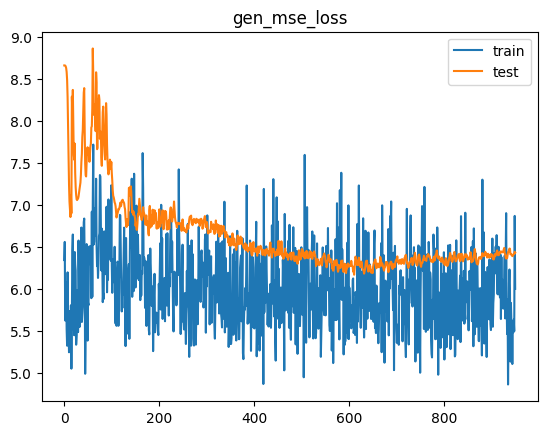

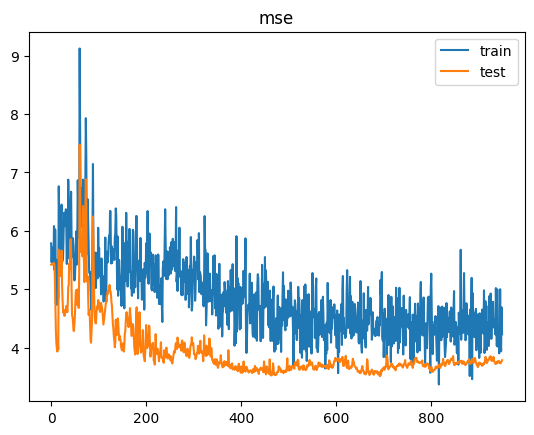

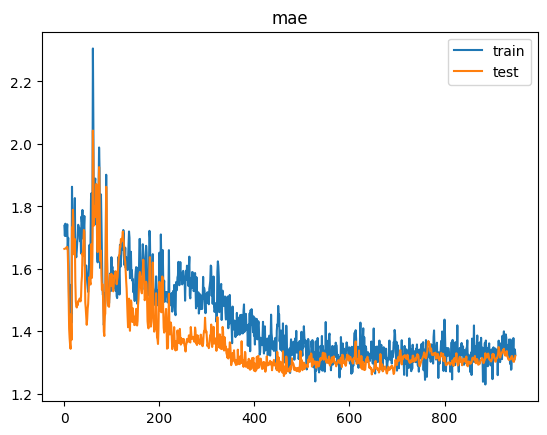

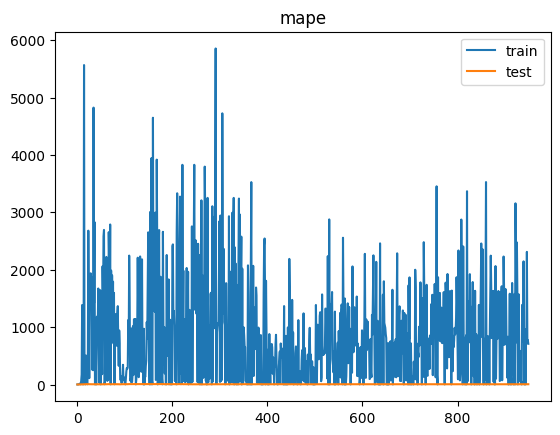

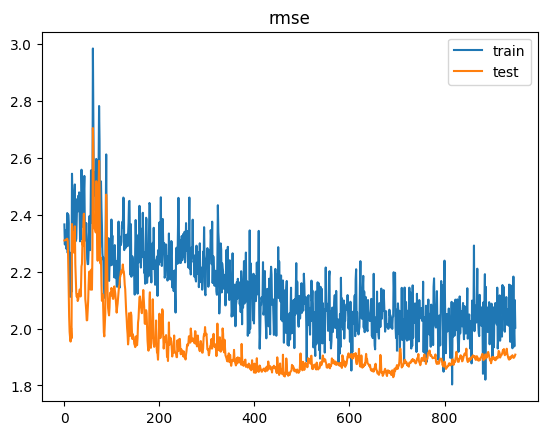

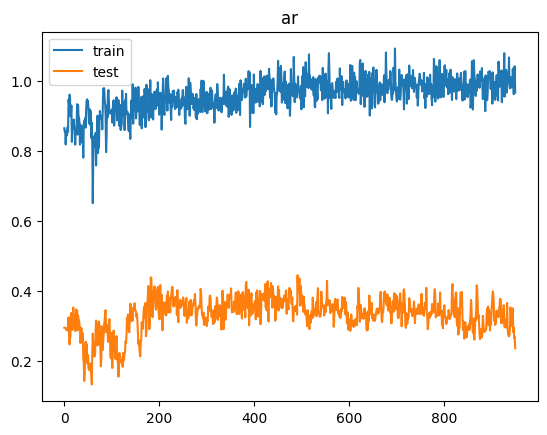

2/2 [==============================] - 1s 3ms/step


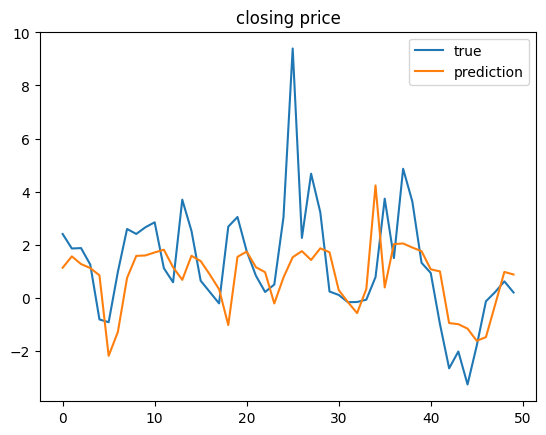

[MSE Baseline] train: 4.6285700023069145  test: 3.7469059248471765
Delta time with epochs = 950: 0:08:37.825464
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 20)             0         
             

Time for epoch 51 is 0.5022075176239014 sec Generator Loss: 0.8971499800682068,  Discriminator_loss: 1.2780036926269531
Time for epoch 52 is 0.5164635181427002 sec Generator Loss: 0.8902896046638489,  Discriminator_loss: 1.29855477809906
Time for epoch 53 is 0.49901700019836426 sec Generator Loss: 0.8914012908935547,  Discriminator_loss: 1.3113418817520142
Time for epoch 54 is 0.5084347724914551 sec Generator Loss: 0.8832915425300598,  Discriminator_loss: 1.309516191482544
Time for epoch 55 is 0.4994773864746094 sec Generator Loss: 0.87223881483078,  Discriminator_loss: 1.317759394645691
Time for epoch 56 is 0.5051860809326172 sec Generator Loss: 0.8752027153968811,  Discriminator_loss: 1.3072786331176758
Time for epoch 57 is 0.4997129440307617 sec Generator Loss: 0.8785431385040283,  Discriminator_loss: 1.3097182512283325
Time for epoch 58 is 0.5120177268981934 sec Generator Loss: 0.8669189810752869,  Discriminator_loss: 1.2909873723983765
Time for epoch 59 is 0.5112392902374268 sec G

Time for epoch 120 is 0.5284614562988281 sec Generator Loss: 0.8044866323471069,  Discriminator_loss: 1.343790054321289
Time for epoch 121 is 0.5710997581481934 sec Generator Loss: 0.8048956394195557,  Discriminator_loss: 1.3459343910217285
Time for epoch 122 is 0.5418682098388672 sec Generator Loss: 0.8031831979751587,  Discriminator_loss: 1.3564354181289673
Time for epoch 123 is 0.5496997833251953 sec Generator Loss: 0.8071458339691162,  Discriminator_loss: 1.3419482707977295
Time for epoch 124 is 0.5403578281402588 sec Generator Loss: 0.8013091683387756,  Discriminator_loss: 1.3512458801269531
Time for epoch 125 is 0.5429885387420654 sec Generator Loss: 0.8028631806373596,  Discriminator_loss: 1.346146583557129
Time for epoch 126 is 0.5270519256591797 sec Generator Loss: 0.7941839098930359,  Discriminator_loss: 1.3507157564163208
Time for epoch 127 is 0.5370171070098877 sec Generator Loss: 0.7944685816764832,  Discriminator_loss: 1.3499373197555542
Time for epoch 128 is 0.5323402881

Time for epoch 188 is 0.515953540802002 sec Generator Loss: 0.7890396118164062,  Discriminator_loss: 1.3496294021606445
Time for epoch 189 is 0.502960205078125 sec Generator Loss: 0.8019159436225891,  Discriminator_loss: 1.335627794265747
Time for epoch 190 is 0.516474723815918 sec Generator Loss: 0.8020159602165222,  Discriminator_loss: 1.3414442539215088
Time for epoch 191 is 0.5047967433929443 sec Generator Loss: 0.8001788258552551,  Discriminator_loss: 1.3437262773513794
Time for epoch 192 is 0.5080149173736572 sec Generator Loss: 0.8007577061653137,  Discriminator_loss: 1.348096251487732
Time for epoch 193 is 0.5193886756896973 sec Generator Loss: 0.8044723272323608,  Discriminator_loss: 1.3414528369903564
Time for epoch 194 is 0.5128159523010254 sec Generator Loss: 0.8045040369033813,  Discriminator_loss: 1.3463070392608643
Time for epoch 195 is 0.5119409561157227 sec Generator Loss: 0.7991089224815369,  Discriminator_loss: 1.3423974514007568
Time for epoch 196 is 0.5038418769836

Time for epoch 257 is 0.5522468090057373 sec Generator Loss: 0.7900936007499695,  Discriminator_loss: 1.347733497619629
Time for epoch 258 is 0.5486016273498535 sec Generator Loss: 0.7907379269599915,  Discriminator_loss: 1.3543825149536133
Time for epoch 259 is 0.5534796714782715 sec Generator Loss: 0.8019502758979797,  Discriminator_loss: 1.3460091352462769
Time for epoch 260 is 0.5448925495147705 sec Generator Loss: 0.7972659468650818,  Discriminator_loss: 1.3476998805999756
Time for epoch 261 is 0.5495743751525879 sec Generator Loss: 0.7872116565704346,  Discriminator_loss: 1.3431615829467773
Time for epoch 262 is 0.545738935470581 sec Generator Loss: 0.792945921421051,  Discriminator_loss: 1.342629075050354
Time for epoch 263 is 0.5555403232574463 sec Generator Loss: 0.7863903045654297,  Discriminator_loss: 1.3607711791992188
Time for epoch 264 is 0.5532698631286621 sec Generator Loss: 0.7925757765769958,  Discriminator_loss: 1.3540592193603516
Time for epoch 265 is 0.548023700714

Time for epoch 325 is 0.5207629203796387 sec Generator Loss: 0.7726388573646545,  Discriminator_loss: 1.35953688621521
Time for epoch 326 is 0.5156428813934326 sec Generator Loss: 0.7736590504646301,  Discriminator_loss: 1.364279866218567
Time for epoch 327 is 0.5282018184661865 sec Generator Loss: 0.782120943069458,  Discriminator_loss: 1.35994291305542
Time for epoch 328 is 0.5193514823913574 sec Generator Loss: 0.7863006591796875,  Discriminator_loss: 1.3543219566345215
Time for epoch 329 is 0.5096006393432617 sec Generator Loss: 0.7913943529129028,  Discriminator_loss: 1.35407555103302
Time for epoch 330 is 0.522519588470459 sec Generator Loss: 0.7858855724334717,  Discriminator_loss: 1.354658603668213
Time for epoch 331 is 0.5093686580657959 sec Generator Loss: 0.7830117344856262,  Discriminator_loss: 1.3563916683197021
Time for epoch 332 is 0.536332368850708 sec Generator Loss: 0.7858935594558716,  Discriminator_loss: 1.3455382585525513
Time for epoch 333 is 0.5482563972473145 se

Time for epoch 394 is 0.507333517074585 sec Generator Loss: 0.7869142293930054,  Discriminator_loss: 1.3604328632354736
Time for epoch 395 is 0.5075602531433105 sec Generator Loss: 0.7808287739753723,  Discriminator_loss: 1.358666181564331
Time for epoch 396 is 0.5144875049591064 sec Generator Loss: 0.7776184678077698,  Discriminator_loss: 1.3648388385772705
Time for epoch 397 is 0.5343215465545654 sec Generator Loss: 0.7876601219177246,  Discriminator_loss: 1.3572343587875366
Time for epoch 398 is 0.5133275985717773 sec Generator Loss: 0.7903225421905518,  Discriminator_loss: 1.3563450574874878
Time for epoch 399 is 0.5109708309173584 sec Generator Loss: 0.7826799750328064,  Discriminator_loss: 1.3615654706954956
Time for epoch 400 is 0.5154216289520264 sec Generator Loss: 0.7984715700149536,  Discriminator_loss: 1.3466542959213257
Time for epoch 401 is 0.5044522285461426 sec Generator Loss: 0.7918135523796082,  Discriminator_loss: 1.3489822149276733
Time for epoch 402 is 0.5223104953

Time for epoch 462 is 0.5467691421508789 sec Generator Loss: 0.7828742861747742,  Discriminator_loss: 1.3624659776687622
Time for epoch 463 is 0.5307986736297607 sec Generator Loss: 0.7833341956138611,  Discriminator_loss: 1.3585138320922852
Time for epoch 464 is 0.5070598125457764 sec Generator Loss: 0.7811040878295898,  Discriminator_loss: 1.352067232131958
Time for epoch 465 is 0.5062041282653809 sec Generator Loss: 0.7751553654670715,  Discriminator_loss: 1.3610905408859253
Time for epoch 466 is 0.5068600177764893 sec Generator Loss: 0.7874609231948853,  Discriminator_loss: 1.3525433540344238
Time for epoch 467 is 0.5111775398254395 sec Generator Loss: 0.7821941375732422,  Discriminator_loss: 1.3577340841293335
Time for epoch 468 is 0.5120522975921631 sec Generator Loss: 0.7772961854934692,  Discriminator_loss: 1.359641194343567
Time for epoch 469 is 0.5022332668304443 sec Generator Loss: 0.7844325304031372,  Discriminator_loss: 1.3579381704330444
Time for epoch 470 is 0.5053937435

Time for epoch 530 is 0.5485999584197998 sec Generator Loss: 0.7863261699676514,  Discriminator_loss: 1.360177993774414
Time for epoch 531 is 0.5517904758453369 sec Generator Loss: 0.7825818061828613,  Discriminator_loss: 1.3638921976089478
Time for epoch 532 is 0.550839900970459 sec Generator Loss: 0.7911653518676758,  Discriminator_loss: 1.355668306350708
Time for epoch 533 is 0.5454487800598145 sec Generator Loss: 0.7788445949554443,  Discriminator_loss: 1.3587032556533813
Time for epoch 534 is 0.5428919792175293 sec Generator Loss: 0.7840573191642761,  Discriminator_loss: 1.360248327255249
Time for epoch 535 is 0.5488491058349609 sec Generator Loss: 0.7793061137199402,  Discriminator_loss: 1.3601332902908325
Time for epoch 536 is 0.5123457908630371 sec Generator Loss: 0.7832363843917847,  Discriminator_loss: 1.3612699508666992
Time for epoch 537 is 0.5095839500427246 sec Generator Loss: 0.7858979105949402,  Discriminator_loss: 1.3516777753829956
Time for epoch 538 is 0.505900382995

Time for epoch 599 is 0.5041913986206055 sec Generator Loss: 0.7820024490356445,  Discriminator_loss: 1.353960633277893
Time for epoch 600 is 0.5105431079864502 sec Generator Loss: 0.7989941239356995,  Discriminator_loss: 1.3521602153778076
Time for epoch 601 is 0.5159556865692139 sec Generator Loss: 0.7934146523475647,  Discriminator_loss: 1.3476922512054443
Time for epoch 602 is 0.5364415645599365 sec Generator Loss: 0.7862235307693481,  Discriminator_loss: 1.358540654182434
Time for epoch 603 is 0.5025320053100586 sec Generator Loss: 0.7871408462524414,  Discriminator_loss: 1.3549752235412598
Time for epoch 604 is 0.5384790897369385 sec Generator Loss: 0.7912425994873047,  Discriminator_loss: 1.3522402048110962
Time for epoch 605 is 0.544741153717041 sec Generator Loss: 0.7893848419189453,  Discriminator_loss: 1.358274221420288
Time for epoch 606 is 0.5282144546508789 sec Generator Loss: 0.7821663022041321,  Discriminator_loss: 1.358373999595642
Time for epoch 607 is 0.5391156673431

Time for epoch 667 is 0.5434889793395996 sec Generator Loss: 0.7882862091064453,  Discriminator_loss: 1.3494659662246704
Time for epoch 668 is 0.575782299041748 sec Generator Loss: 0.7788854837417603,  Discriminator_loss: 1.3522191047668457
Time for epoch 669 is 0.5621540546417236 sec Generator Loss: 0.7897159457206726,  Discriminator_loss: 1.3524287939071655
Time for epoch 670 is 0.5679028034210205 sec Generator Loss: 0.7980683445930481,  Discriminator_loss: 1.3410022258758545
Time for epoch 671 is 0.5860505104064941 sec Generator Loss: 0.7945147752761841,  Discriminator_loss: 1.3492947816848755
Time for epoch 672 is 0.6167972087860107 sec Generator Loss: 0.7952040433883667,  Discriminator_loss: 1.3501938581466675
Time for epoch 673 is 0.5530755519866943 sec Generator Loss: 0.7907722592353821,  Discriminator_loss: 1.3511877059936523
Time for epoch 674 is 0.6223728656768799 sec Generator Loss: 0.7970036864280701,  Discriminator_loss: 1.3453269004821777
Time for epoch 675 is 0.605408668

Time for epoch 735 is 0.5599133968353271 sec Generator Loss: 0.7782592177391052,  Discriminator_loss: 1.352117896080017
Time for epoch 736 is 0.5369384288787842 sec Generator Loss: 0.7951184511184692,  Discriminator_loss: 1.341846227645874
Time for epoch 737 is 0.5427067279815674 sec Generator Loss: 0.7957919836044312,  Discriminator_loss: 1.3420830965042114
Time for epoch 738 is 0.5443406105041504 sec Generator Loss: 0.7912449836730957,  Discriminator_loss: 1.3536442518234253
Time for epoch 739 is 0.535616397857666 sec Generator Loss: 0.7931584119796753,  Discriminator_loss: 1.3427810668945312
Time for epoch 740 is 0.5422611236572266 sec Generator Loss: 0.788385272026062,  Discriminator_loss: 1.3495460748672485
Time for epoch 741 is 0.5406227111816406 sec Generator Loss: 0.7986690998077393,  Discriminator_loss: 1.3483432531356812
Time for epoch 742 is 0.5500285625457764 sec Generator Loss: 0.7995088696479797,  Discriminator_loss: 1.3489547967910767
Time for epoch 743 is 0.544290542602

Time for epoch 804 is 0.5091381072998047 sec Generator Loss: 0.7969979047775269,  Discriminator_loss: 1.3463393449783325
Time for epoch 805 is 0.5128252506256104 sec Generator Loss: 0.8072354793548584,  Discriminator_loss: 1.3419071435928345
Time for epoch 806 is 0.5096817016601562 sec Generator Loss: 0.7874948382377625,  Discriminator_loss: 1.342187762260437
Time for epoch 807 is 0.5198564529418945 sec Generator Loss: 0.7937412261962891,  Discriminator_loss: 1.3441635370254517
Time for epoch 808 is 0.5135335922241211 sec Generator Loss: 0.7939494848251343,  Discriminator_loss: 1.3495091199874878
Time for epoch 809 is 0.5097825527191162 sec Generator Loss: 0.7916459441184998,  Discriminator_loss: 1.348006248474121
Time for epoch 810 is 0.5107762813568115 sec Generator Loss: 0.7990711331367493,  Discriminator_loss: 1.3466905355453491
Time for epoch 811 is 0.5079505443572998 sec Generator Loss: 0.8045466542243958,  Discriminator_loss: 1.3363028764724731
Time for epoch 812 is 0.5128960609

Time for epoch 872 is 0.5488638877868652 sec Generator Loss: 0.8003808259963989,  Discriminator_loss: 1.3451602458953857
Time for epoch 873 is 0.5471467971801758 sec Generator Loss: 0.8037770986557007,  Discriminator_loss: 1.3434007167816162
Time for epoch 874 is 0.5664753913879395 sec Generator Loss: 0.8017629384994507,  Discriminator_loss: 1.3439650535583496
Time for epoch 875 is 0.5522871017456055 sec Generator Loss: 0.7989992499351501,  Discriminator_loss: 1.3395546674728394
Time for epoch 876 is 0.5550034046173096 sec Generator Loss: 0.8153793811798096,  Discriminator_loss: 1.341434359550476
Time for epoch 877 is 0.5408787727355957 sec Generator Loss: 0.8018883466720581,  Discriminator_loss: 1.3471518754959106
Time for epoch 878 is 0.5442056655883789 sec Generator Loss: 0.8152479529380798,  Discriminator_loss: 1.3403074741363525
Time for epoch 879 is 0.5505568981170654 sec Generator Loss: 0.809593677520752,  Discriminator_loss: 1.3430496454238892
Time for epoch 880 is 0.5155458450

Time for epoch 940 is 0.5157043933868408 sec Generator Loss: 0.8116444945335388,  Discriminator_loss: 1.3391460180282593
Time for epoch 941 is 0.5069301128387451 sec Generator Loss: 0.8121418952941895,  Discriminator_loss: 1.3391963243484497
Time for epoch 942 is 0.5258052349090576 sec Generator Loss: 0.8196772933006287,  Discriminator_loss: 1.33042573928833
Time for epoch 943 is 0.5091493129730225 sec Generator Loss: 0.8129407167434692,  Discriminator_loss: 1.3361128568649292
Time for epoch 944 is 0.509331226348877 sec Generator Loss: 0.8067079782485962,  Discriminator_loss: 1.3390960693359375
Time for epoch 945 is 0.509244441986084 sec Generator Loss: 0.7982606291770935,  Discriminator_loss: 1.3560125827789307
Time for epoch 946 is 0.5150530338287354 sec Generator Loss: 0.8085154294967651,  Discriminator_loss: 1.3338531255722046
Time for epoch 947 is 0.5220820903778076 sec Generator Loss: 0.809235155582428,  Discriminator_loss: 1.3345125913619995
Time for epoch 948 is 0.5124778747558

Time for epoch 1008 is 0.5475451946258545 sec Generator Loss: 0.7972986698150635,  Discriminator_loss: 1.3456655740737915
Time for epoch 1009 is 0.54225754737854 sec Generator Loss: 0.7971773147583008,  Discriminator_loss: 1.349411129951477
Time for epoch 1010 is 0.5403389930725098 sec Generator Loss: 0.8123871684074402,  Discriminator_loss: 1.3346421718597412
Time for epoch 1011 is 0.5634307861328125 sec Generator Loss: 0.812839925289154,  Discriminator_loss: 1.3356882333755493
Time for epoch 1012 is 0.5683169364929199 sec Generator Loss: 0.8110967874526978,  Discriminator_loss: 1.3339396715164185
Time for epoch 1013 is 0.5638003349304199 sec Generator Loss: 0.8156763315200806,  Discriminator_loss: 1.3370165824890137
Time for epoch 1014 is 0.5419270992279053 sec Generator Loss: 0.8023777604103088,  Discriminator_loss: 1.3469294309616089
Time for epoch 1015 is 0.5624501705169678 sec Generator Loss: 0.8098626136779785,  Discriminator_loss: 1.3349953889846802
Time for epoch 1016 is 0.557

Time for epoch 1076 is 0.5163061618804932 sec Generator Loss: 0.8117518424987793,  Discriminator_loss: 1.332268238067627
Time for epoch 1077 is 0.5177834033966064 sec Generator Loss: 0.8118278980255127,  Discriminator_loss: 1.3396250009536743
Time for epoch 1078 is 0.522223711013794 sec Generator Loss: 0.8105686902999878,  Discriminator_loss: 1.3365339040756226
Time for epoch 1079 is 0.5148673057556152 sec Generator Loss: 0.8064460158348083,  Discriminator_loss: 1.3476091623306274
Time for epoch 1080 is 0.5552732944488525 sec Generator Loss: 0.8128008246421814,  Discriminator_loss: 1.341222882270813
Time for epoch 1081 is 0.5290248394012451 sec Generator Loss: 0.8076921105384827,  Discriminator_loss: 1.3327772617340088
Time for epoch 1082 is 0.5210583209991455 sec Generator Loss: 0.8099098801612854,  Discriminator_loss: 1.3354873657226562
Time for epoch 1083 is 0.5146262645721436 sec Generator Loss: 0.8122996091842651,  Discriminator_loss: 1.3413277864456177
Time for epoch 1084 is 0.51

Time for epoch 1144 is 0.52008056640625 sec Generator Loss: 0.8157031536102295,  Discriminator_loss: 1.3350279331207275
Time for epoch 1145 is 0.5295853614807129 sec Generator Loss: 0.8221650123596191,  Discriminator_loss: 1.330016016960144
Time for epoch 1146 is 0.5070569515228271 sec Generator Loss: 0.8004522919654846,  Discriminator_loss: 1.3400901556015015
Time for epoch 1147 is 0.5100266933441162 sec Generator Loss: 0.8123779892921448,  Discriminator_loss: 1.3382344245910645
Time for epoch 1148 is 0.5140478610992432 sec Generator Loss: 0.8110790848731995,  Discriminator_loss: 1.3338541984558105
Time for epoch 1149 is 0.5130817890167236 sec Generator Loss: 0.8070744872093201,  Discriminator_loss: 1.3304038047790527
Time for epoch 1150 is 0.5137059688568115 sec Generator Loss: 0.8297125101089478,  Discriminator_loss: 1.3301050662994385
Time for epoch 1151 is 0.515174388885498 sec Generator Loss: 0.8193392157554626,  Discriminator_loss: 1.3412693738937378
Time for epoch 1152 is 0.522

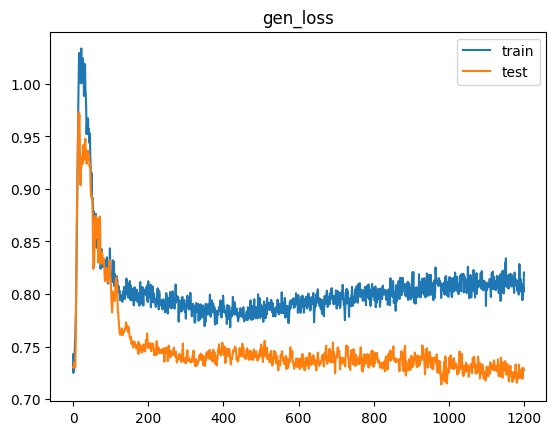

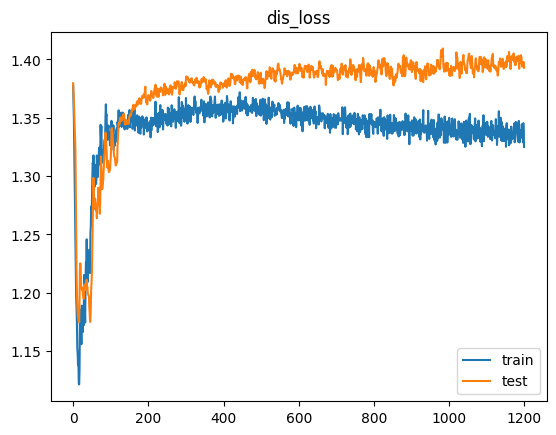

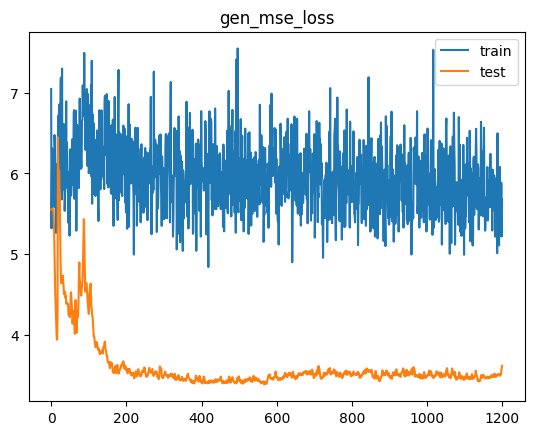

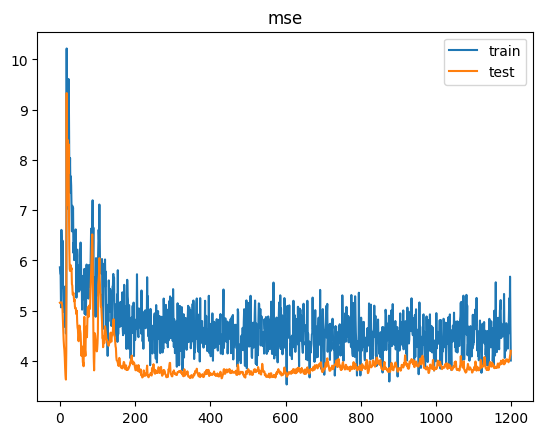

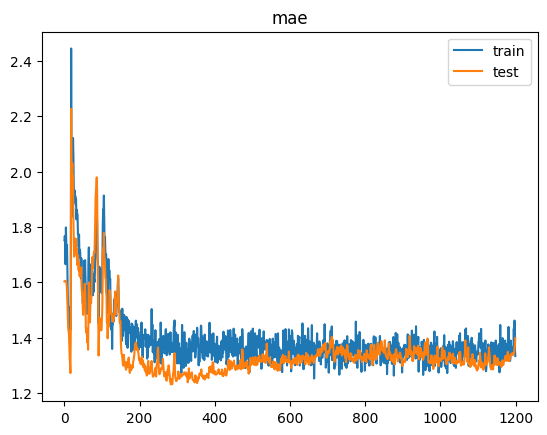

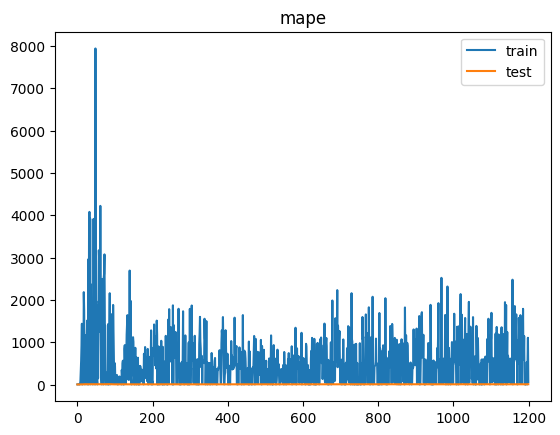

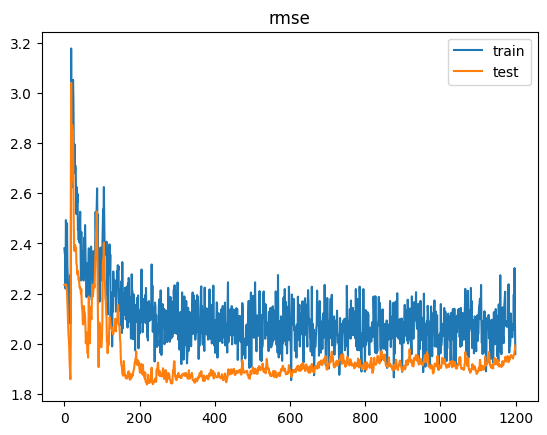

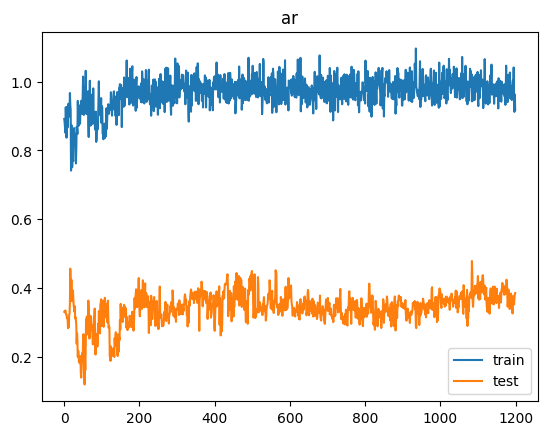

2/2 [==============================] - 1s 4ms/step


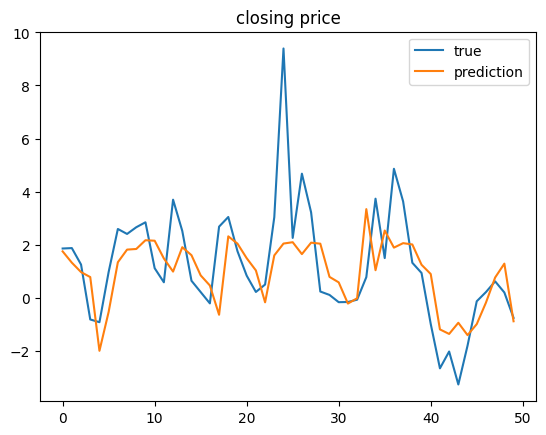

[MSE Baseline] train: 4.511141303713504  test: 3.665913330963867
Delta time with epochs = 1200: 0:10:55.879947
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_10 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.5282742977142334 sec Generator Loss: 0.8626353144645691,  Discriminator_loss: 1.3125290870666504
Time for epoch 52 is 0.5285372734069824 sec Generator Loss: 0.8636435270309448,  Discriminator_loss: 1.3024715185165405
Time for epoch 53 is 0.5274829864501953 sec Generator Loss: 0.8689645528793335,  Discriminator_loss: 1.297803282737732
Time for epoch 54 is 0.5233144760131836 sec Generator Loss: 0.8578671216964722,  Discriminator_loss: 1.3110229969024658
Time for epoch 55 is 0.5207452774047852 sec Generator Loss: 0.866720974445343,  Discriminator_loss: 1.2988115549087524
Time for epoch 56 is 0.523247241973877 sec Generator Loss: 0.867210865020752,  Discriminator_loss: 1.3050297498703003
Time for epoch 57 is 0.5233895778656006 sec Generator Loss: 0.864030122756958,  Discriminator_loss: 1.297574520111084
Time for epoch 58 is 0.5183267593383789 sec Generator Loss: 0.8616988658905029,  Discriminator_loss: 1.3032822608947754
Time for epoch 59 is 0.5309510231018066 sec Ge

Time for epoch 120 is 0.5025355815887451 sec Generator Loss: 0.7913975119590759,  Discriminator_loss: 1.361734390258789
Time for epoch 121 is 0.5337932109832764 sec Generator Loss: 0.7841858863830566,  Discriminator_loss: 1.3691060543060303
Time for epoch 122 is 0.5450446605682373 sec Generator Loss: 0.7889004945755005,  Discriminator_loss: 1.3611431121826172
Time for epoch 123 is 0.5525784492492676 sec Generator Loss: 0.790165364742279,  Discriminator_loss: 1.3697826862335205
Time for epoch 124 is 0.5588405132293701 sec Generator Loss: 0.8025366067886353,  Discriminator_loss: 1.3542593717575073
Time for epoch 125 is 0.5880885124206543 sec Generator Loss: 0.7860957384109497,  Discriminator_loss: 1.3589833974838257
Time for epoch 126 is 0.5604391098022461 sec Generator Loss: 0.7855223417282104,  Discriminator_loss: 1.3558422327041626
Time for epoch 127 is 0.5532410144805908 sec Generator Loss: 0.7871308922767639,  Discriminator_loss: 1.35524582862854
Time for epoch 128 is 0.566004276275

Time for epoch 188 is 0.5203802585601807 sec Generator Loss: 0.7954217195510864,  Discriminator_loss: 1.3494714498519897
Time for epoch 189 is 0.5322587490081787 sec Generator Loss: 0.785502016544342,  Discriminator_loss: 1.3517780303955078
Time for epoch 190 is 0.5118436813354492 sec Generator Loss: 0.779210090637207,  Discriminator_loss: 1.359619379043579
Time for epoch 191 is 0.51566481590271 sec Generator Loss: 0.7894672155380249,  Discriminator_loss: 1.3596748113632202
Time for epoch 192 is 0.5134186744689941 sec Generator Loss: 0.7916572690010071,  Discriminator_loss: 1.3510189056396484
Time for epoch 193 is 0.5170297622680664 sec Generator Loss: 0.7960453033447266,  Discriminator_loss: 1.3500102758407593
Time for epoch 194 is 0.5255758762359619 sec Generator Loss: 0.7918305397033691,  Discriminator_loss: 1.3580414056777954
Time for epoch 195 is 0.5195035934448242 sec Generator Loss: 0.7846077084541321,  Discriminator_loss: 1.3566867113113403
Time for epoch 196 is 0.5235681533813

Time for epoch 257 is 0.5816681385040283 sec Generator Loss: 0.797971785068512,  Discriminator_loss: 1.3576319217681885
Time for epoch 258 is 0.5499451160430908 sec Generator Loss: 0.7802436351776123,  Discriminator_loss: 1.3550580739974976
Time for epoch 259 is 0.5550599098205566 sec Generator Loss: 0.7868393659591675,  Discriminator_loss: 1.3540318012237549
Time for epoch 260 is 0.5423665046691895 sec Generator Loss: 0.7917507290840149,  Discriminator_loss: 1.3537814617156982
Time for epoch 261 is 0.5210926532745361 sec Generator Loss: 0.7761454582214355,  Discriminator_loss: 1.3634568452835083
Time for epoch 262 is 0.5217955112457275 sec Generator Loss: 0.7751898169517517,  Discriminator_loss: 1.3658877611160278
Time for epoch 263 is 0.5247125625610352 sec Generator Loss: 0.7859734296798706,  Discriminator_loss: 1.355328917503357
Time for epoch 264 is 0.52323317527771 sec Generator Loss: 0.7767478227615356,  Discriminator_loss: 1.3604481220245361
Time for epoch 265 is 0.514149427413

Time for epoch 326 is 0.5372190475463867 sec Generator Loss: 0.7813066244125366,  Discriminator_loss: 1.3605365753173828
Time for epoch 327 is 0.5866317749023438 sec Generator Loss: 0.7735822200775146,  Discriminator_loss: 1.365990400314331
Time for epoch 328 is 0.5672938823699951 sec Generator Loss: 0.7871596217155457,  Discriminator_loss: 1.3577284812927246
Time for epoch 329 is 0.6413655281066895 sec Generator Loss: 0.7779737114906311,  Discriminator_loss: 1.356964349746704
Time for epoch 330 is 0.6036393642425537 sec Generator Loss: 0.7843987345695496,  Discriminator_loss: 1.354722023010254
Time for epoch 331 is 0.5907740592956543 sec Generator Loss: 0.776282548904419,  Discriminator_loss: 1.3632484674453735
Time for epoch 332 is 0.601917028427124 sec Generator Loss: 0.7812559604644775,  Discriminator_loss: 1.3654072284698486
Time for epoch 333 is 0.600860595703125 sec Generator Loss: 0.7734334468841553,  Discriminator_loss: 1.3663444519042969
Time for epoch 334 is 0.59581804275512

Time for epoch 395 is 0.5831770896911621 sec Generator Loss: 0.7857054471969604,  Discriminator_loss: 1.3572603464126587
Time for epoch 396 is 0.556999921798706 sec Generator Loss: 0.7912362217903137,  Discriminator_loss: 1.3536456823349
Time for epoch 397 is 0.5644941329956055 sec Generator Loss: 0.7846245765686035,  Discriminator_loss: 1.3583141565322876
Time for epoch 398 is 0.565873384475708 sec Generator Loss: 0.7863022089004517,  Discriminator_loss: 1.3567403554916382
Time for epoch 399 is 0.5860662460327148 sec Generator Loss: 0.7733808159828186,  Discriminator_loss: 1.3608131408691406
Time for epoch 400 is 0.5632898807525635 sec Generator Loss: 0.7787454128265381,  Discriminator_loss: 1.3610405921936035
Time for epoch 401 is 0.5424318313598633 sec Generator Loss: 0.7725765109062195,  Discriminator_loss: 1.3656227588653564
Time for epoch 402 is 0.5691030025482178 sec Generator Loss: 0.7784318327903748,  Discriminator_loss: 1.359186053276062
Time for epoch 403 is 0.54839873313903

Time for epoch 464 is 0.5233945846557617 sec Generator Loss: 0.7754973769187927,  Discriminator_loss: 1.368007779121399
Time for epoch 465 is 0.5222702026367188 sec Generator Loss: 0.78440922498703,  Discriminator_loss: 1.353054165840149
Time for epoch 466 is 0.519625186920166 sec Generator Loss: 0.7754011154174805,  Discriminator_loss: 1.358866572380066
Time for epoch 467 is 0.5498950481414795 sec Generator Loss: 0.7875126004219055,  Discriminator_loss: 1.358402967453003
Time for epoch 468 is 0.5241758823394775 sec Generator Loss: 0.7766339182853699,  Discriminator_loss: 1.3672446012496948
Time for epoch 469 is 0.5226657390594482 sec Generator Loss: 0.7900608777999878,  Discriminator_loss: 1.355968713760376
Time for epoch 470 is 0.5249285697937012 sec Generator Loss: 0.787839412689209,  Discriminator_loss: 1.355991244316101
Time for epoch 471 is 0.5249462127685547 sec Generator Loss: 0.7858626842498779,  Discriminator_loss: 1.35873544216156
Time for epoch 472 is 0.5207695960998535 sec

Time for epoch 533 is 0.5358517169952393 sec Generator Loss: 0.7745584845542908,  Discriminator_loss: 1.3611888885498047
Time for epoch 534 is 0.5402462482452393 sec Generator Loss: 0.7887471318244934,  Discriminator_loss: 1.353569746017456
Time for epoch 535 is 0.5266578197479248 sec Generator Loss: 0.7803740501403809,  Discriminator_loss: 1.357254147529602
Time for epoch 536 is 0.5208733081817627 sec Generator Loss: 0.7806755900382996,  Discriminator_loss: 1.3562535047531128
Time for epoch 537 is 0.5347468852996826 sec Generator Loss: 0.7872108221054077,  Discriminator_loss: 1.355704665184021
Time for epoch 538 is 0.5372092723846436 sec Generator Loss: 0.7903829216957092,  Discriminator_loss: 1.356581211090088
Time for epoch 539 is 0.5213165283203125 sec Generator Loss: 0.7891479730606079,  Discriminator_loss: 1.3590013980865479
Time for epoch 540 is 0.5217220783233643 sec Generator Loss: 0.7907443046569824,  Discriminator_loss: 1.3606295585632324
Time for epoch 541 is 0.522907733917

Time for epoch 601 is 0.6114928722381592 sec Generator Loss: 0.8020287156105042,  Discriminator_loss: 1.3530161380767822
Time for epoch 602 is 0.6164412498474121 sec Generator Loss: 0.7789683938026428,  Discriminator_loss: 1.3640903234481812
Time for epoch 603 is 0.5776066780090332 sec Generator Loss: 0.7676726579666138,  Discriminator_loss: 1.3621234893798828
Time for epoch 604 is 0.5734837055206299 sec Generator Loss: 0.7879679203033447,  Discriminator_loss: 1.3516191244125366
Time for epoch 605 is 0.6169137954711914 sec Generator Loss: 0.781471312046051,  Discriminator_loss: 1.3573368787765503
Time for epoch 606 is 0.5803642272949219 sec Generator Loss: 0.7890520095825195,  Discriminator_loss: 1.353366732597351
Time for epoch 607 is 0.6284017562866211 sec Generator Loss: 0.7889699339866638,  Discriminator_loss: 1.3468635082244873
Time for epoch 608 is 0.5796833038330078 sec Generator Loss: 0.7912197709083557,  Discriminator_loss: 1.3602571487426758
Time for epoch 609 is 0.5871148109

Time for epoch 669 is 0.5265986919403076 sec Generator Loss: 0.7864916920661926,  Discriminator_loss: 1.3579729795455933
Time for epoch 670 is 0.5322558879852295 sec Generator Loss: 0.7899265289306641,  Discriminator_loss: 1.352329134941101
Time for epoch 671 is 0.5189847946166992 sec Generator Loss: 0.793876588344574,  Discriminator_loss: 1.3500334024429321
Time for epoch 672 is 0.5409107208251953 sec Generator Loss: 0.7831089496612549,  Discriminator_loss: 1.3537895679473877
Time for epoch 673 is 0.5279953479766846 sec Generator Loss: 0.7895374894142151,  Discriminator_loss: 1.3639334440231323
Time for epoch 674 is 0.5370035171508789 sec Generator Loss: 0.7933616638183594,  Discriminator_loss: 1.3500367403030396
Time for epoch 675 is 0.5224297046661377 sec Generator Loss: 0.7896165251731873,  Discriminator_loss: 1.3470083475112915
Time for epoch 676 is 0.535059928894043 sec Generator Loss: 0.7855724692344666,  Discriminator_loss: 1.350770354270935
Time for epoch 677 is 0.532532453536

Time for epoch 737 is 0.5964338779449463 sec Generator Loss: 0.7876943349838257,  Discriminator_loss: 1.3535066843032837
Time for epoch 738 is 0.5732903480529785 sec Generator Loss: 0.8005572557449341,  Discriminator_loss: 1.3508808612823486
Time for epoch 739 is 0.5711698532104492 sec Generator Loss: 0.7994067072868347,  Discriminator_loss: 1.3363991975784302
Time for epoch 740 is 0.5585558414459229 sec Generator Loss: 0.787753164768219,  Discriminator_loss: 1.3485682010650635
Time for epoch 741 is 0.5785484313964844 sec Generator Loss: 0.791627049446106,  Discriminator_loss: 1.3505570888519287
Time for epoch 742 is 0.5571930408477783 sec Generator Loss: 0.7841730117797852,  Discriminator_loss: 1.3477778434753418
Time for epoch 743 is 0.5900740623474121 sec Generator Loss: 0.7949820160865784,  Discriminator_loss: 1.3446797132492065
Time for epoch 744 is 0.5648412704467773 sec Generator Loss: 0.7908399105072021,  Discriminator_loss: 1.355767011642456
Time for epoch 745 is 0.57721281051

Time for epoch 805 is 0.5678205490112305 sec Generator Loss: 0.7920364141464233,  Discriminator_loss: 1.356570839881897
Time for epoch 806 is 0.5268096923828125 sec Generator Loss: 0.7821115255355835,  Discriminator_loss: 1.3549686670303345
Time for epoch 807 is 0.5369019508361816 sec Generator Loss: 0.7851648926734924,  Discriminator_loss: 1.350179672241211
Time for epoch 808 is 0.528738260269165 sec Generator Loss: 0.7958124279975891,  Discriminator_loss: 1.345190405845642
Time for epoch 809 is 0.5321905612945557 sec Generator Loss: 0.7915586233139038,  Discriminator_loss: 1.3445849418640137
Time for epoch 810 is 0.5238535404205322 sec Generator Loss: 0.7960841059684753,  Discriminator_loss: 1.3451241254806519
Time for epoch 811 is 0.5299639701843262 sec Generator Loss: 0.79302978515625,  Discriminator_loss: 1.3410334587097168
Time for epoch 812 is 0.5767450332641602 sec Generator Loss: 0.7874950170516968,  Discriminator_loss: 1.3460673093795776
Time for epoch 813 is 0.55523467063903

Time for epoch 874 is 0.5306248664855957 sec Generator Loss: 0.7934402823448181,  Discriminator_loss: 1.3554762601852417
Time for epoch 875 is 0.5268659591674805 sec Generator Loss: 0.7944039106369019,  Discriminator_loss: 1.346861481666565
Time for epoch 876 is 0.5355908870697021 sec Generator Loss: 0.8063410520553589,  Discriminator_loss: 1.3484079837799072
Time for epoch 877 is 0.5351107120513916 sec Generator Loss: 0.7884977459907532,  Discriminator_loss: 1.3501440286636353
Time for epoch 878 is 0.5544919967651367 sec Generator Loss: 0.799599826335907,  Discriminator_loss: 1.3439298868179321
Time for epoch 879 is 0.5291125774383545 sec Generator Loss: 0.7984244227409363,  Discriminator_loss: 1.3426519632339478
Time for epoch 880 is 0.5476877689361572 sec Generator Loss: 0.7910924553871155,  Discriminator_loss: 1.3521735668182373
Time for epoch 881 is 0.5325362682342529 sec Generator Loss: 0.7832314968109131,  Discriminator_loss: 1.3484638929367065
Time for epoch 882 is 0.5299067497

Time for epoch 942 is 0.5750570297241211 sec Generator Loss: 0.8048706650733948,  Discriminator_loss: 1.3460462093353271
Time for epoch 943 is 0.5844907760620117 sec Generator Loss: 0.8051719665527344,  Discriminator_loss: 1.3400347232818604
Time for epoch 944 is 0.5571794509887695 sec Generator Loss: 0.7926608324050903,  Discriminator_loss: 1.3550636768341064
Time for epoch 945 is 0.5838067531585693 sec Generator Loss: 0.801453709602356,  Discriminator_loss: 1.3472719192504883
Time for epoch 946 is 0.5748567581176758 sec Generator Loss: 0.79838627576828,  Discriminator_loss: 1.3399723768234253
Time for epoch 947 is 0.5673625469207764 sec Generator Loss: 0.7911088466644287,  Discriminator_loss: 1.3468060493469238
Time for epoch 948 is 0.5834026336669922 sec Generator Loss: 0.7942280769348145,  Discriminator_loss: 1.3447301387786865
Time for epoch 949 is 0.5653572082519531 sec Generator Loss: 0.7971566915512085,  Discriminator_loss: 1.3466744422912598
Time for epoch 950 is 0.57612419128

Time for epoch 1010 is 0.5596439838409424 sec Generator Loss: 0.8071310520172119,  Discriminator_loss: 1.3393815755844116
Time for epoch 1011 is 0.5930593013763428 sec Generator Loss: 0.8120613098144531,  Discriminator_loss: 1.3381208181381226
Time for epoch 1012 is 0.5640733242034912 sec Generator Loss: 0.802095890045166,  Discriminator_loss: 1.3408334255218506
Time for epoch 1013 is 0.5798571109771729 sec Generator Loss: 0.8141077160835266,  Discriminator_loss: 1.3382848501205444
Time for epoch 1014 is 0.5668559074401855 sec Generator Loss: 0.7986482977867126,  Discriminator_loss: 1.3404569625854492
Time for epoch 1015 is 0.5607903003692627 sec Generator Loss: 0.821972131729126,  Discriminator_loss: 1.3347262144088745
Time for epoch 1016 is 0.5269780158996582 sec Generator Loss: 0.8090410232543945,  Discriminator_loss: 1.3362942934036255
Time for epoch 1017 is 0.5432114601135254 sec Generator Loss: 0.8045236468315125,  Discriminator_loss: 1.3402531147003174
Time for epoch 1018 is 0.5

Time for epoch 1078 is 0.6186268329620361 sec Generator Loss: 0.8139235377311707,  Discriminator_loss: 1.343384861946106
Time for epoch 1079 is 0.5627470016479492 sec Generator Loss: 0.8105407357215881,  Discriminator_loss: 1.3431727886199951
Time for epoch 1080 is 0.5702824592590332 sec Generator Loss: 0.8086549043655396,  Discriminator_loss: 1.3345270156860352
Time for epoch 1081 is 0.5794610977172852 sec Generator Loss: 0.8091198205947876,  Discriminator_loss: 1.3357113599777222
Time for epoch 1082 is 0.5899240970611572 sec Generator Loss: 0.8041803240776062,  Discriminator_loss: 1.3322898149490356
Time for epoch 1083 is 0.5831694602966309 sec Generator Loss: 0.807685136795044,  Discriminator_loss: 1.3360844850540161
Time for epoch 1084 is 0.5989134311676025 sec Generator Loss: 0.8089342713356018,  Discriminator_loss: 1.3337116241455078
Time for epoch 1085 is 0.5878720283508301 sec Generator Loss: 0.8077348470687866,  Discriminator_loss: 1.3407692909240723
Time for epoch 1086 is 0.5

Time for epoch 1146 is 0.5307502746582031 sec Generator Loss: 0.8063642978668213,  Discriminator_loss: 1.343644142150879
Time for epoch 1147 is 0.5318992137908936 sec Generator Loss: 0.8133827447891235,  Discriminator_loss: 1.3372005224227905
Time for epoch 1148 is 0.5500142574310303 sec Generator Loss: 0.8115478754043579,  Discriminator_loss: 1.340766191482544
Time for epoch 1149 is 0.5544254779815674 sec Generator Loss: 0.8158904910087585,  Discriminator_loss: 1.3401966094970703
Time for epoch 1150 is 0.5449423789978027 sec Generator Loss: 0.8132036328315735,  Discriminator_loss: 1.342530369758606
Time for epoch 1151 is 0.5426762104034424 sec Generator Loss: 0.811970591545105,  Discriminator_loss: 1.3281821012496948
Time for epoch 1152 is 0.5329532623291016 sec Generator Loss: 0.8014034628868103,  Discriminator_loss: 1.3325207233428955
Time for epoch 1153 is 0.5404751300811768 sec Generator Loss: 0.8335828185081482,  Discriminator_loss: 1.3257145881652832
Time for epoch 1154 is 0.533

Time for epoch 1214 is 0.5737617015838623 sec Generator Loss: 0.806522786617279,  Discriminator_loss: 1.33079993724823
Time for epoch 1215 is 0.5735745429992676 sec Generator Loss: 0.8102568984031677,  Discriminator_loss: 1.3340507745742798
Time for epoch 1216 is 0.5686933994293213 sec Generator Loss: 0.8031978011131287,  Discriminator_loss: 1.3396778106689453
Time for epoch 1217 is 0.5860705375671387 sec Generator Loss: 0.8091461062431335,  Discriminator_loss: 1.3310966491699219
Time for epoch 1218 is 0.5840249061584473 sec Generator Loss: 0.8116440176963806,  Discriminator_loss: 1.3352419137954712
Time for epoch 1219 is 0.5770771503448486 sec Generator Loss: 0.816479504108429,  Discriminator_loss: 1.3334720134735107
Time for epoch 1220 is 0.5912637710571289 sec Generator Loss: 0.8097286224365234,  Discriminator_loss: 1.3369454145431519
Time for epoch 1221 is 0.5812456607818604 sec Generator Loss: 0.807033896446228,  Discriminator_loss: 1.3413466215133667
Time for epoch 1222 is 0.5852

Time for epoch 1282 is 0.6236274242401123 sec Generator Loss: 0.8103994131088257,  Discriminator_loss: 1.3375660181045532
Time for epoch 1283 is 0.694068193435669 sec Generator Loss: 0.8204942941665649,  Discriminator_loss: 1.3330937623977661
Time for epoch 1284 is 0.643080472946167 sec Generator Loss: 0.8298521637916565,  Discriminator_loss: 1.335026741027832
Time for epoch 1285 is 0.6419768333435059 sec Generator Loss: 0.8058679103851318,  Discriminator_loss: 1.3401702642440796
Time for epoch 1286 is 0.6278166770935059 sec Generator Loss: 0.8087224364280701,  Discriminator_loss: 1.3316255807876587
Time for epoch 1287 is 0.727494478225708 sec Generator Loss: 0.8147090077400208,  Discriminator_loss: 1.331467866897583
Time for epoch 1288 is 0.6373012065887451 sec Generator Loss: 0.8246886730194092,  Discriminator_loss: 1.3281141519546509
Time for epoch 1289 is 0.575237512588501 sec Generator Loss: 0.8273414969444275,  Discriminator_loss: 1.32353675365448
Time for epoch 1290 is 0.5914869

Time for epoch 1350 is 0.534778356552124 sec Generator Loss: 0.8113906979560852,  Discriminator_loss: 1.3402811288833618
Time for epoch 1351 is 0.5344254970550537 sec Generator Loss: 0.8049636483192444,  Discriminator_loss: 1.3381175994873047
Time for epoch 1352 is 0.5434665679931641 sec Generator Loss: 0.8124297857284546,  Discriminator_loss: 1.341640591621399
Time for epoch 1353 is 0.5361368656158447 sec Generator Loss: 0.8154833912849426,  Discriminator_loss: 1.338304877281189
Time for epoch 1354 is 0.5450835227966309 sec Generator Loss: 0.8128611445426941,  Discriminator_loss: 1.3325281143188477
Time for epoch 1355 is 0.5371291637420654 sec Generator Loss: 0.8185544610023499,  Discriminator_loss: 1.3392060995101929
Time for epoch 1356 is 0.5502519607543945 sec Generator Loss: 0.8139511346817017,  Discriminator_loss: 1.3399828672409058
Time for epoch 1357 is 0.5455038547515869 sec Generator Loss: 0.8121594190597534,  Discriminator_loss: 1.342444896697998
Time for epoch 1358 is 0.524

Time for epoch 1418 is 0.5987613201141357 sec Generator Loss: 0.822447657585144,  Discriminator_loss: 1.3341902494430542
Time for epoch 1419 is 0.5800738334655762 sec Generator Loss: 0.8113070130348206,  Discriminator_loss: 1.3353114128112793
Time for epoch 1420 is 0.5870623588562012 sec Generator Loss: 0.8176137208938599,  Discriminator_loss: 1.3338608741760254
Time for epoch 1421 is 0.5847992897033691 sec Generator Loss: 0.8148929476737976,  Discriminator_loss: 1.3385649919509888
Time for epoch 1422 is 0.5898678302764893 sec Generator Loss: 0.8173193335533142,  Discriminator_loss: 1.3241404294967651
Time for epoch 1423 is 0.5682365894317627 sec Generator Loss: 0.8221982717514038,  Discriminator_loss: 1.3366801738739014
Time for epoch 1424 is 0.6022405624389648 sec Generator Loss: 0.8075218200683594,  Discriminator_loss: 1.3456523418426514
Time for epoch 1425 is 0.5873713493347168 sec Generator Loss: 0.820806086063385,  Discriminator_loss: 1.3300992250442505
Time for epoch 1426 is 0.5

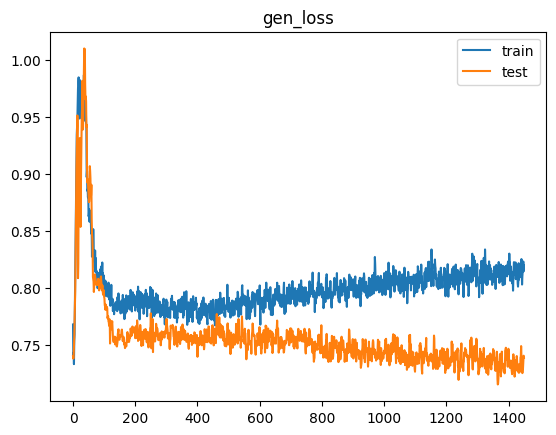

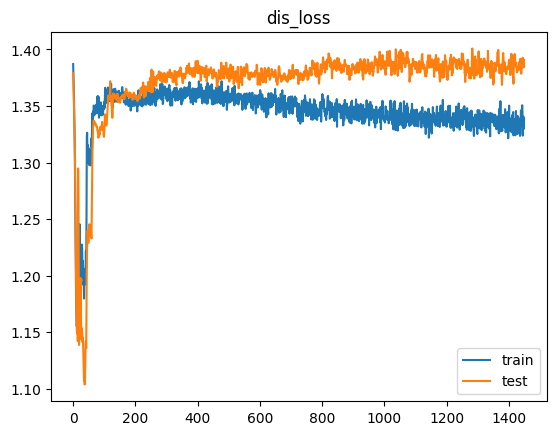

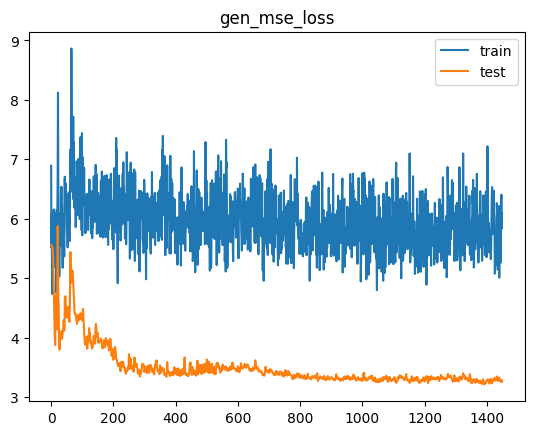

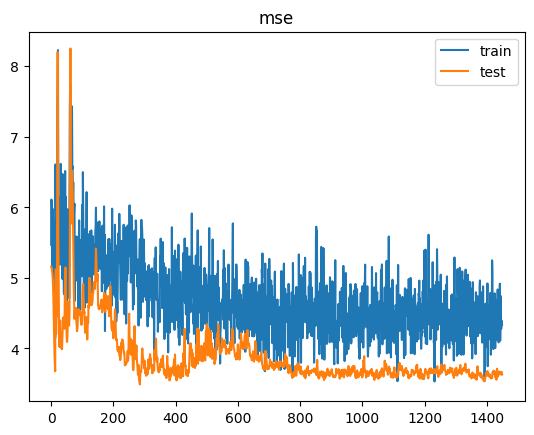

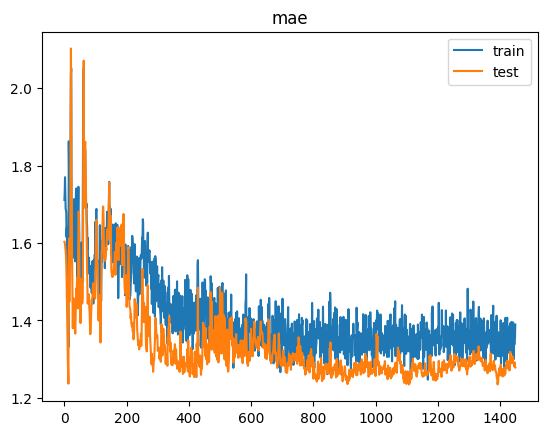

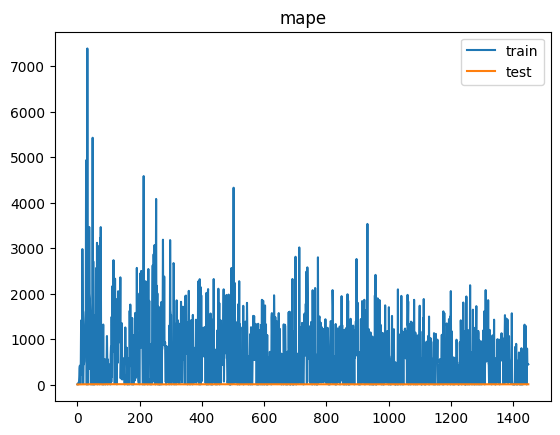

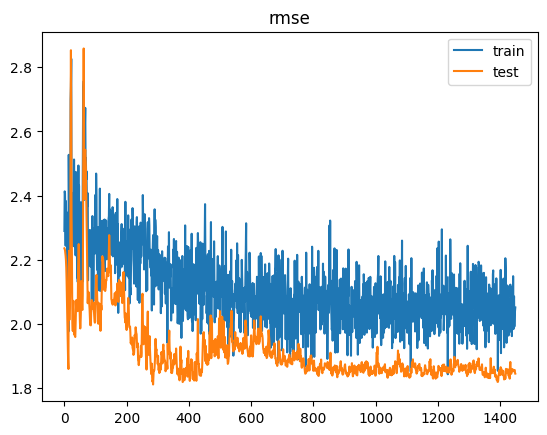

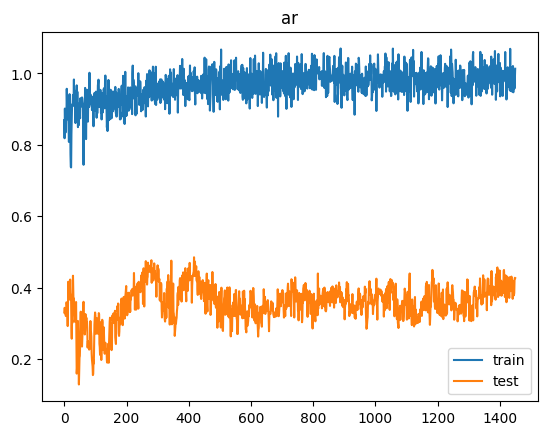

2/2 [==============================] - 1s 4ms/step


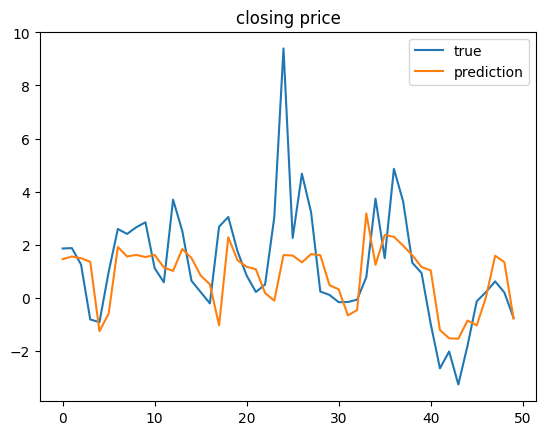

[MSE Baseline] train: 4.702741754254398  test: 3.665913330963867
Delta time with epochs = 1450: 0:13:51.352467
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_12 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.5733911991119385 sec Generator Loss: 0.8846184611320496,  Discriminator_loss: 1.3154819011688232
Time for epoch 52 is 0.5831189155578613 sec Generator Loss: 0.8760821223258972,  Discriminator_loss: 1.3208850622177124
Time for epoch 53 is 0.5663061141967773 sec Generator Loss: 0.8790750503540039,  Discriminator_loss: 1.3172359466552734
Time for epoch 54 is 0.5678529739379883 sec Generator Loss: 0.8692516088485718,  Discriminator_loss: 1.3151606321334839
Time for epoch 55 is 0.5619306564331055 sec Generator Loss: 0.8627997040748596,  Discriminator_loss: 1.3319662809371948
Time for epoch 56 is 0.5796389579772949 sec Generator Loss: 0.8576169610023499,  Discriminator_loss: 1.3257558345794678
Time for epoch 57 is 0.5672550201416016 sec Generator Loss: 0.8664986491203308,  Discriminator_loss: 1.3216904401779175
Time for epoch 58 is 0.5524349212646484 sec Generator Loss: 0.8661943674087524,  Discriminator_loss: 1.3091989755630493
Time for epoch 59 is 0.5738377571105957 

Time for epoch 120 is 0.6122584342956543 sec Generator Loss: 0.7800722718238831,  Discriminator_loss: 1.3755565881729126
Time for epoch 121 is 0.6444778442382812 sec Generator Loss: 0.7700312733650208,  Discriminator_loss: 1.3797211647033691
Time for epoch 122 is 0.5916895866394043 sec Generator Loss: 0.7757844924926758,  Discriminator_loss: 1.3731979131698608
Time for epoch 123 is 0.6304507255554199 sec Generator Loss: 0.7801800966262817,  Discriminator_loss: 1.3756294250488281
Time for epoch 124 is 0.6270153522491455 sec Generator Loss: 0.7831249237060547,  Discriminator_loss: 1.3692665100097656
Time for epoch 125 is 0.5861251354217529 sec Generator Loss: 0.779963493347168,  Discriminator_loss: 1.3730113506317139
Time for epoch 126 is 0.6196892261505127 sec Generator Loss: 0.7759639024734497,  Discriminator_loss: 1.3697081804275513
Time for epoch 127 is 0.599306583404541 sec Generator Loss: 0.7756015062332153,  Discriminator_loss: 1.3638416528701782
Time for epoch 128 is 0.5657882690

Time for epoch 188 is 0.5391204357147217 sec Generator Loss: 0.79292893409729,  Discriminator_loss: 1.3556015491485596
Time for epoch 189 is 0.5216166973114014 sec Generator Loss: 0.7961277365684509,  Discriminator_loss: 1.3502681255340576
Time for epoch 190 is 0.5511419773101807 sec Generator Loss: 0.7899293899536133,  Discriminator_loss: 1.3567951917648315
Time for epoch 191 is 0.5380997657775879 sec Generator Loss: 0.7814782857894897,  Discriminator_loss: 1.3585857152938843
Time for epoch 192 is 0.5371248722076416 sec Generator Loss: 0.7964463233947754,  Discriminator_loss: 1.3496649265289307
Time for epoch 193 is 0.5326254367828369 sec Generator Loss: 0.7898883819580078,  Discriminator_loss: 1.3529250621795654
Time for epoch 194 is 0.5360100269317627 sec Generator Loss: 0.7948833703994751,  Discriminator_loss: 1.3491789102554321
Time for epoch 195 is 0.5350759029388428 sec Generator Loss: 0.7935194969177246,  Discriminator_loss: 1.3439521789550781
Time for epoch 196 is 0.5295112133

Time for epoch 256 is 0.5309956073760986 sec Generator Loss: 0.7684633731842041,  Discriminator_loss: 1.3599739074707031
Time for epoch 257 is 0.5513191223144531 sec Generator Loss: 0.7777503728866577,  Discriminator_loss: 1.3578152656555176
Time for epoch 258 is 0.525749921798706 sec Generator Loss: 0.7921374440193176,  Discriminator_loss: 1.344984531402588
Time for epoch 259 is 0.5337693691253662 sec Generator Loss: 0.7830448150634766,  Discriminator_loss: 1.3621224164962769
Time for epoch 260 is 0.534862756729126 sec Generator Loss: 0.7745240330696106,  Discriminator_loss: 1.360818862915039
Time for epoch 261 is 0.5351448059082031 sec Generator Loss: 0.7850992679595947,  Discriminator_loss: 1.3625805377960205
Time for epoch 262 is 0.5434458255767822 sec Generator Loss: 0.7931053638458252,  Discriminator_loss: 1.3584554195404053
Time for epoch 263 is 0.539269208908081 sec Generator Loss: 0.7772625684738159,  Discriminator_loss: 1.363350510597229
Time for epoch 264 is 0.58144259452819

Time for epoch 325 is 0.563016414642334 sec Generator Loss: 0.7850321531295776,  Discriminator_loss: 1.3563088178634644
Time for epoch 326 is 0.5426921844482422 sec Generator Loss: 0.7790125012397766,  Discriminator_loss: 1.364831805229187
Time for epoch 327 is 0.5376288890838623 sec Generator Loss: 0.7839910984039307,  Discriminator_loss: 1.3574868440628052
Time for epoch 328 is 0.5405421257019043 sec Generator Loss: 0.7719323039054871,  Discriminator_loss: 1.3638736009597778
Time for epoch 329 is 0.5294778347015381 sec Generator Loss: 0.7811391949653625,  Discriminator_loss: 1.3605877161026
Time for epoch 330 is 0.5862538814544678 sec Generator Loss: 0.7897520661354065,  Discriminator_loss: 1.3594707250595093
Time for epoch 331 is 0.5316531658172607 sec Generator Loss: 0.7792128920555115,  Discriminator_loss: 1.3625558614730835
Time for epoch 332 is 0.5441157817840576 sec Generator Loss: 0.7810072898864746,  Discriminator_loss: 1.356809139251709
Time for epoch 333 is 0.56539654731750

Time for epoch 393 is 0.5747473239898682 sec Generator Loss: 0.7759726047515869,  Discriminator_loss: 1.3577487468719482
Time for epoch 394 is 0.579129695892334 sec Generator Loss: 0.7746209502220154,  Discriminator_loss: 1.3630855083465576
Time for epoch 395 is 0.6094470024108887 sec Generator Loss: 0.7819619178771973,  Discriminator_loss: 1.3611000776290894
Time for epoch 396 is 0.6005566120147705 sec Generator Loss: 0.7833942770957947,  Discriminator_loss: 1.3614728450775146
Time for epoch 397 is 0.5707900524139404 sec Generator Loss: 0.7782523036003113,  Discriminator_loss: 1.3619306087493896
Time for epoch 398 is 0.6084024906158447 sec Generator Loss: 0.7871496081352234,  Discriminator_loss: 1.3553284406661987
Time for epoch 399 is 0.6076717376708984 sec Generator Loss: 0.7766728401184082,  Discriminator_loss: 1.3625364303588867
Time for epoch 400 is 0.5788331031799316 sec Generator Loss: 0.7780292630195618,  Discriminator_loss: 1.3516261577606201
Time for epoch 401 is 0.581691741

Time for epoch 461 is 0.5898354053497314 sec Generator Loss: 0.7819263935089111,  Discriminator_loss: 1.3553297519683838
Time for epoch 462 is 0.5611507892608643 sec Generator Loss: 0.7925747036933899,  Discriminator_loss: 1.35527503490448
Time for epoch 463 is 0.5487194061279297 sec Generator Loss: 0.7923024296760559,  Discriminator_loss: 1.3538531064987183
Time for epoch 464 is 0.5448980331420898 sec Generator Loss: 0.786070704460144,  Discriminator_loss: 1.3550586700439453
Time for epoch 465 is 0.5547158718109131 sec Generator Loss: 0.7788472771644592,  Discriminator_loss: 1.3567341566085815
Time for epoch 466 is 0.6069188117980957 sec Generator Loss: 0.7833328247070312,  Discriminator_loss: 1.3626642227172852
Time for epoch 467 is 0.5891726016998291 sec Generator Loss: 0.7836906909942627,  Discriminator_loss: 1.3604198694229126
Time for epoch 468 is 0.6310391426086426 sec Generator Loss: 0.7901480197906494,  Discriminator_loss: 1.3535345792770386
Time for epoch 469 is 0.59031677246

Time for epoch 529 is 0.5942213535308838 sec Generator Loss: 0.7949931025505066,  Discriminator_loss: 1.3556915521621704
Time for epoch 530 is 0.5873372554779053 sec Generator Loss: 0.7832379341125488,  Discriminator_loss: 1.3515708446502686
Time for epoch 531 is 0.583017110824585 sec Generator Loss: 0.776320219039917,  Discriminator_loss: 1.3621755838394165
Time for epoch 532 is 0.6311216354370117 sec Generator Loss: 0.7776614427566528,  Discriminator_loss: 1.3556734323501587
Time for epoch 533 is 0.6427671909332275 sec Generator Loss: 0.7876051068305969,  Discriminator_loss: 1.3534024953842163
Time for epoch 534 is 0.6518604755401611 sec Generator Loss: 0.7905722260475159,  Discriminator_loss: 1.3608325719833374
Time for epoch 535 is 0.6636471748352051 sec Generator Loss: 0.7913890480995178,  Discriminator_loss: 1.350853681564331
Time for epoch 536 is 0.6247081756591797 sec Generator Loss: 0.7812104821205139,  Discriminator_loss: 1.3598155975341797
Time for epoch 537 is 0.61208987236

Time for epoch 597 is 0.5958728790283203 sec Generator Loss: 0.7843806147575378,  Discriminator_loss: 1.355281114578247
Time for epoch 598 is 0.5796597003936768 sec Generator Loss: 0.7846046686172485,  Discriminator_loss: 1.3516532182693481
Time for epoch 599 is 0.5764861106872559 sec Generator Loss: 0.7939431071281433,  Discriminator_loss: 1.3488315343856812
Time for epoch 600 is 0.633352518081665 sec Generator Loss: 0.7833022475242615,  Discriminator_loss: 1.3549665212631226
Time for epoch 601 is 0.6043176651000977 sec Generator Loss: 0.8006422519683838,  Discriminator_loss: 1.3458892107009888
Time for epoch 602 is 0.6274070739746094 sec Generator Loss: 0.7816748023033142,  Discriminator_loss: 1.3645575046539307
Time for epoch 603 is 0.6226708889007568 sec Generator Loss: 0.7804948687553406,  Discriminator_loss: 1.3529980182647705
Time for epoch 604 is 0.6066567897796631 sec Generator Loss: 0.7924653887748718,  Discriminator_loss: 1.3483473062515259
Time for epoch 605 is 0.5762383937

Time for epoch 666 is 0.5556325912475586 sec Generator Loss: 0.79444420337677,  Discriminator_loss: 1.3480243682861328
Time for epoch 667 is 0.5457644462585449 sec Generator Loss: 0.7906661033630371,  Discriminator_loss: 1.3555513620376587
Time for epoch 668 is 0.5420267581939697 sec Generator Loss: 0.7941625118255615,  Discriminator_loss: 1.344594120979309
Time for epoch 669 is 0.5551424026489258 sec Generator Loss: 0.7840492725372314,  Discriminator_loss: 1.3493168354034424
Time for epoch 670 is 0.5593593120574951 sec Generator Loss: 0.7937734127044678,  Discriminator_loss: 1.3490557670593262
Time for epoch 671 is 0.5680859088897705 sec Generator Loss: 0.7981110215187073,  Discriminator_loss: 1.3499643802642822
Time for epoch 672 is 0.5709617137908936 sec Generator Loss: 0.7920544147491455,  Discriminator_loss: 1.3496408462524414
Time for epoch 673 is 0.5712099075317383 sec Generator Loss: 0.7983642816543579,  Discriminator_loss: 1.3482483625411987
Time for epoch 674 is 0.56904315948

Time for epoch 734 is 0.6690707206726074 sec Generator Loss: 0.792424738407135,  Discriminator_loss: 1.3457310199737549
Time for epoch 735 is 0.6692261695861816 sec Generator Loss: 0.7884294986724854,  Discriminator_loss: 1.3564594984054565
Time for epoch 736 is 0.6909482479095459 sec Generator Loss: 0.7906351685523987,  Discriminator_loss: 1.350775122642517
Time for epoch 737 is 0.6829817295074463 sec Generator Loss: 0.7948411703109741,  Discriminator_loss: 1.3530369997024536
Time for epoch 738 is 0.6990606784820557 sec Generator Loss: 0.797617495059967,  Discriminator_loss: 1.3525654077529907
Time for epoch 739 is 0.6463210582733154 sec Generator Loss: 0.7882561683654785,  Discriminator_loss: 1.3544392585754395
Time for epoch 740 is 0.7500214576721191 sec Generator Loss: 0.7944297194480896,  Discriminator_loss: 1.3459539413452148
Time for epoch 741 is 0.7950758934020996 sec Generator Loss: 0.7936634421348572,  Discriminator_loss: 1.34391450881958
Time for epoch 742 is 0.6179087162017

Time for epoch 803 is 0.5504500865936279 sec Generator Loss: 0.8000001311302185,  Discriminator_loss: 1.3566118478775024
Time for epoch 804 is 0.5542893409729004 sec Generator Loss: 0.7902754545211792,  Discriminator_loss: 1.3544001579284668
Time for epoch 805 is 0.5541996955871582 sec Generator Loss: 0.7961901426315308,  Discriminator_loss: 1.3503026962280273
Time for epoch 806 is 0.571469783782959 sec Generator Loss: 0.7859513163566589,  Discriminator_loss: 1.3530391454696655
Time for epoch 807 is 0.5481441020965576 sec Generator Loss: 0.7904340624809265,  Discriminator_loss: 1.351397156715393
Time for epoch 808 is 0.5639925003051758 sec Generator Loss: 0.7856065630912781,  Discriminator_loss: 1.3536629676818848
Time for epoch 809 is 0.5566122531890869 sec Generator Loss: 0.7925383448600769,  Discriminator_loss: 1.3514894247055054
Time for epoch 810 is 0.5579581260681152 sec Generator Loss: 0.7926648259162903,  Discriminator_loss: 1.345863938331604
Time for epoch 811 is 0.59518146514

Time for epoch 871 is 0.5641779899597168 sec Generator Loss: 0.7912020087242126,  Discriminator_loss: 1.3453664779663086
Time for epoch 872 is 0.5597522258758545 sec Generator Loss: 0.791532576084137,  Discriminator_loss: 1.350063443183899
Time for epoch 873 is 0.5737788677215576 sec Generator Loss: 0.8008791208267212,  Discriminator_loss: 1.34519624710083
Time for epoch 874 is 0.5556125640869141 sec Generator Loss: 0.800302267074585,  Discriminator_loss: 1.345105528831482
Time for epoch 875 is 0.5529046058654785 sec Generator Loss: 0.7997146844863892,  Discriminator_loss: 1.348534107208252
Time for epoch 876 is 0.5678062438964844 sec Generator Loss: 0.8111347556114197,  Discriminator_loss: 1.3453075885772705
Time for epoch 877 is 0.553642988204956 sec Generator Loss: 0.7984423637390137,  Discriminator_loss: 1.3449559211730957
Time for epoch 878 is 0.5569908618927002 sec Generator Loss: 0.7897278666496277,  Discriminator_loss: 1.3501904010772705
Time for epoch 879 is 0.5579946041107178

Time for epoch 939 is 0.6400394439697266 sec Generator Loss: 0.7864221334457397,  Discriminator_loss: 1.3488136529922485
Time for epoch 940 is 0.6926102638244629 sec Generator Loss: 0.7989204525947571,  Discriminator_loss: 1.3448587656021118
Time for epoch 941 is 0.6240200996398926 sec Generator Loss: 0.8077600002288818,  Discriminator_loss: 1.3337682485580444
Time for epoch 942 is 0.6186749935150146 sec Generator Loss: 0.7986605167388916,  Discriminator_loss: 1.3464667797088623
Time for epoch 943 is 0.6126999855041504 sec Generator Loss: 0.79477459192276,  Discriminator_loss: 1.3436291217803955
Time for epoch 944 is 0.6033816337585449 sec Generator Loss: 0.7950325608253479,  Discriminator_loss: 1.3436334133148193
Time for epoch 945 is 0.5965888500213623 sec Generator Loss: 0.8011072874069214,  Discriminator_loss: 1.3408136367797852
Time for epoch 946 is 0.6085271835327148 sec Generator Loss: 0.8037344813346863,  Discriminator_loss: 1.3478114604949951
Time for epoch 947 is 0.5996234416

Time for epoch 1007 is 0.6592066287994385 sec Generator Loss: 0.8125985264778137,  Discriminator_loss: 1.3409675359725952
Time for epoch 1008 is 0.6502737998962402 sec Generator Loss: 0.7998008728027344,  Discriminator_loss: 1.3381868600845337
Time for epoch 1009 is 0.59818434715271 sec Generator Loss: 0.8064126968383789,  Discriminator_loss: 1.3365988731384277
Time for epoch 1010 is 0.6254444122314453 sec Generator Loss: 0.7938253879547119,  Discriminator_loss: 1.3372609615325928
Time for epoch 1011 is 0.6693062782287598 sec Generator Loss: 0.7924510836601257,  Discriminator_loss: 1.3505607843399048
Time for epoch 1012 is 0.6079180240631104 sec Generator Loss: 0.7933323979377747,  Discriminator_loss: 1.3484934568405151
Time for epoch 1013 is 0.5911037921905518 sec Generator Loss: 0.7905441522598267,  Discriminator_loss: 1.341786503791809
Time for epoch 1014 is 0.6603152751922607 sec Generator Loss: 0.7888578176498413,  Discriminator_loss: 1.351706624031067
Time for epoch 1015 is 0.620

Time for epoch 1075 is 0.6176497936248779 sec Generator Loss: 0.8091126084327698,  Discriminator_loss: 1.348506212234497
Time for epoch 1076 is 0.6067647933959961 sec Generator Loss: 0.8067156076431274,  Discriminator_loss: 1.3358627557754517
Time for epoch 1077 is 0.6460065841674805 sec Generator Loss: 0.8009924292564392,  Discriminator_loss: 1.3458198308944702
Time for epoch 1078 is 0.61588454246521 sec Generator Loss: 0.7998629212379456,  Discriminator_loss: 1.3484004735946655
Time for epoch 1079 is 0.6048264503479004 sec Generator Loss: 0.798196017742157,  Discriminator_loss: 1.339582085609436
Time for epoch 1080 is 0.6015422344207764 sec Generator Loss: 0.7896816730499268,  Discriminator_loss: 1.346276879310608
Time for epoch 1081 is 0.6294701099395752 sec Generator Loss: 0.8099613785743713,  Discriminator_loss: 1.334936261177063
Time for epoch 1082 is 0.6015357971191406 sec Generator Loss: 0.7991183400154114,  Discriminator_loss: 1.349778413772583
Time for epoch 1083 is 0.6067171

Time for epoch 1143 is 0.6251170635223389 sec Generator Loss: 0.8089356422424316,  Discriminator_loss: 1.3366745710372925
Time for epoch 1144 is 0.6265056133270264 sec Generator Loss: 0.7994447946548462,  Discriminator_loss: 1.3444021940231323
Time for epoch 1145 is 0.644913911819458 sec Generator Loss: 0.8151251673698425,  Discriminator_loss: 1.3358906507492065
Time for epoch 1146 is 0.6659913063049316 sec Generator Loss: 0.8142499327659607,  Discriminator_loss: 1.3417006731033325
Time for epoch 1147 is 0.6110785007476807 sec Generator Loss: 0.8268094062805176,  Discriminator_loss: 1.327048420906067
Time for epoch 1148 is 0.6151509284973145 sec Generator Loss: 0.8120191693305969,  Discriminator_loss: 1.335331678390503
Time for epoch 1149 is 0.6369681358337402 sec Generator Loss: 0.8153796195983887,  Discriminator_loss: 1.3386123180389404
Time for epoch 1150 is 0.651017427444458 sec Generator Loss: 0.7984622120857239,  Discriminator_loss: 1.3410615921020508
Time for epoch 1151 is 0.623

Time for epoch 1211 is 0.7700340747833252 sec Generator Loss: 0.8054680228233337,  Discriminator_loss: 1.3398730754852295
Time for epoch 1212 is 0.7443499565124512 sec Generator Loss: 0.8020508289337158,  Discriminator_loss: 1.335094928741455
Time for epoch 1213 is 0.7486941814422607 sec Generator Loss: 0.8035843372344971,  Discriminator_loss: 1.3478130102157593
Time for epoch 1214 is 0.7146251201629639 sec Generator Loss: 0.8050021529197693,  Discriminator_loss: 1.3416507244110107
Time for epoch 1215 is 0.6887905597686768 sec Generator Loss: 0.8023977875709534,  Discriminator_loss: 1.3329136371612549
Time for epoch 1216 is 0.6686053276062012 sec Generator Loss: 0.8020251989364624,  Discriminator_loss: 1.3461697101593018
Time for epoch 1217 is 0.829317569732666 sec Generator Loss: 0.8025811314582825,  Discriminator_loss: 1.3461085557937622
Time for epoch 1218 is 0.7687673568725586 sec Generator Loss: 0.8002504706382751,  Discriminator_loss: 1.337827205657959
Time for epoch 1219 is 0.83

Time for epoch 1279 is 0.6372952461242676 sec Generator Loss: 0.8006441593170166,  Discriminator_loss: 1.3432074785232544
Time for epoch 1280 is 0.6112329959869385 sec Generator Loss: 0.7935494184494019,  Discriminator_loss: 1.3506780862808228
Time for epoch 1281 is 0.6765646934509277 sec Generator Loss: 0.8113318681716919,  Discriminator_loss: 1.3365023136138916
Time for epoch 1282 is 0.6523797512054443 sec Generator Loss: 0.7998892664909363,  Discriminator_loss: 1.3486515283584595
Time for epoch 1283 is 0.6503958702087402 sec Generator Loss: 0.800858736038208,  Discriminator_loss: 1.3438761234283447
Time for epoch 1284 is 0.6576237678527832 sec Generator Loss: 0.797813892364502,  Discriminator_loss: 1.3534154891967773
Time for epoch 1285 is 0.6898548603057861 sec Generator Loss: 0.8010348081588745,  Discriminator_loss: 1.3459839820861816
Time for epoch 1286 is 0.6565728187561035 sec Generator Loss: 0.7978805303573608,  Discriminator_loss: 1.3451849222183228
Time for epoch 1287 is 0.6

Time for epoch 1347 is 0.6225666999816895 sec Generator Loss: 0.8024893999099731,  Discriminator_loss: 1.344627022743225
Time for epoch 1348 is 0.6392772197723389 sec Generator Loss: 0.801701545715332,  Discriminator_loss: 1.349953055381775
Time for epoch 1349 is 0.6242082118988037 sec Generator Loss: 0.8076174259185791,  Discriminator_loss: 1.3513097763061523
Time for epoch 1350 is 0.6422593593597412 sec Generator Loss: 0.8042249083518982,  Discriminator_loss: 1.3363311290740967
Time for epoch 1351 is 0.6329231262207031 sec Generator Loss: 0.7945712804794312,  Discriminator_loss: 1.3497028350830078
Time for epoch 1352 is 0.648059606552124 sec Generator Loss: 0.8143981695175171,  Discriminator_loss: 1.3354883193969727
Time for epoch 1353 is 0.6353681087493896 sec Generator Loss: 0.7931243181228638,  Discriminator_loss: 1.3464065790176392
Time for epoch 1354 is 0.6310410499572754 sec Generator Loss: 0.8031151294708252,  Discriminator_loss: 1.3486335277557373
Time for epoch 1355 is 0.636

Time for epoch 1415 is 0.6411564350128174 sec Generator Loss: 0.7899737358093262,  Discriminator_loss: 1.35032320022583
Time for epoch 1416 is 0.6137137413024902 sec Generator Loss: 0.7982307076454163,  Discriminator_loss: 1.346247673034668
Time for epoch 1417 is 0.6730139255523682 sec Generator Loss: 0.8050845861434937,  Discriminator_loss: 1.3422297239303589
Time for epoch 1418 is 0.6865630149841309 sec Generator Loss: 0.8051539659500122,  Discriminator_loss: 1.340821623802185
Time for epoch 1419 is 0.6435620784759521 sec Generator Loss: 0.8052366375923157,  Discriminator_loss: 1.3420897722244263
Time for epoch 1420 is 0.6332972049713135 sec Generator Loss: 0.8068739771842957,  Discriminator_loss: 1.3394536972045898
Time for epoch 1421 is 0.6064760684967041 sec Generator Loss: 0.8109925389289856,  Discriminator_loss: 1.3353207111358643
Time for epoch 1422 is 0.6048641204833984 sec Generator Loss: 0.8100494742393494,  Discriminator_loss: 1.3395460844039917
Time for epoch 1423 is 0.600

Time for epoch 1483 is 0.6835007667541504 sec Generator Loss: 0.8135184049606323,  Discriminator_loss: 1.3434457778930664
Time for epoch 1484 is 0.7643063068389893 sec Generator Loss: 0.8182990550994873,  Discriminator_loss: 1.3369865417480469
Time for epoch 1485 is 0.7617378234863281 sec Generator Loss: 0.8052749633789062,  Discriminator_loss: 1.3402215242385864
Time for epoch 1486 is 0.7458159923553467 sec Generator Loss: 0.8106328845024109,  Discriminator_loss: 1.3359194993972778
Time for epoch 1487 is 0.6972887516021729 sec Generator Loss: 0.8084971904754639,  Discriminator_loss: 1.3432555198669434
Time for epoch 1488 is 0.6588654518127441 sec Generator Loss: 0.7988582253456116,  Discriminator_loss: 1.3473763465881348
Time for epoch 1489 is 0.6614341735839844 sec Generator Loss: 0.7945556044578552,  Discriminator_loss: 1.3511675596237183
Time for epoch 1490 is 0.6981046199798584 sec Generator Loss: 0.8022412061691284,  Discriminator_loss: 1.3397216796875
Time for epoch 1491 is 0.61

Time for epoch 1551 is 0.6392097473144531 sec Generator Loss: 0.8133625984191895,  Discriminator_loss: 1.3358559608459473
Time for epoch 1552 is 0.6433827877044678 sec Generator Loss: 0.8061366677284241,  Discriminator_loss: 1.3534822463989258
Time for epoch 1553 is 0.6192357540130615 sec Generator Loss: 0.8102315068244934,  Discriminator_loss: 1.335586428642273
Time for epoch 1554 is 0.63399338722229 sec Generator Loss: 0.7955061197280884,  Discriminator_loss: 1.3548316955566406
Time for epoch 1555 is 0.6486892700195312 sec Generator Loss: 0.7997167110443115,  Discriminator_loss: 1.3435802459716797
Time for epoch 1556 is 0.6697301864624023 sec Generator Loss: 0.8020622134208679,  Discriminator_loss: 1.3412617444992065
Time for epoch 1557 is 0.6703970432281494 sec Generator Loss: 0.799530565738678,  Discriminator_loss: 1.3473012447357178
Time for epoch 1558 is 0.6612904071807861 sec Generator Loss: 0.8051074743270874,  Discriminator_loss: 1.3444172143936157
Time for epoch 1559 is 0.624

Time for epoch 1619 is 0.6419882774353027 sec Generator Loss: 0.7953232526779175,  Discriminator_loss: 1.3482874631881714
Time for epoch 1620 is 0.6386730670928955 sec Generator Loss: 0.7896733283996582,  Discriminator_loss: 1.3521782159805298
Time for epoch 1621 is 0.6343111991882324 sec Generator Loss: 0.7997158169746399,  Discriminator_loss: 1.3420312404632568
Time for epoch 1622 is 0.6523756980895996 sec Generator Loss: 0.7966261506080627,  Discriminator_loss: 1.3428491353988647
Time for epoch 1623 is 0.6801083087921143 sec Generator Loss: 0.8019405603408813,  Discriminator_loss: 1.3403480052947998
Time for epoch 1624 is 0.7166211605072021 sec Generator Loss: 0.8034809827804565,  Discriminator_loss: 1.3404475450515747
Time for epoch 1625 is 0.6782901287078857 sec Generator Loss: 0.8175145387649536,  Discriminator_loss: 1.337910771369934
Time for epoch 1626 is 0.6439528465270996 sec Generator Loss: 0.8139650821685791,  Discriminator_loss: 1.3354002237319946
Time for epoch 1627 is 0.

Time for epoch 1687 is 0.7566177845001221 sec Generator Loss: 0.8129302859306335,  Discriminator_loss: 1.3382561206817627
Time for epoch 1688 is 0.6816351413726807 sec Generator Loss: 0.8090424537658691,  Discriminator_loss: 1.3572067022323608
Time for epoch 1689 is 0.7012434005737305 sec Generator Loss: 0.805549144744873,  Discriminator_loss: 1.339404821395874
Time for epoch 1690 is 0.724172830581665 sec Generator Loss: 0.8008561134338379,  Discriminator_loss: 1.3493947982788086
Time for epoch 1691 is 0.6430354118347168 sec Generator Loss: 0.8042429089546204,  Discriminator_loss: 1.3467762470245361
Time for epoch 1692 is 0.6565673351287842 sec Generator Loss: 0.8008851408958435,  Discriminator_loss: 1.3452211618423462
Time for epoch 1693 is 0.6293227672576904 sec Generator Loss: 0.807123601436615,  Discriminator_loss: 1.343315601348877
Time for epoch 1694 is 0.6407666206359863 sec Generator Loss: 0.8080807328224182,  Discriminator_loss: 1.3330539464950562
Time for epoch 1695 is 0.6220

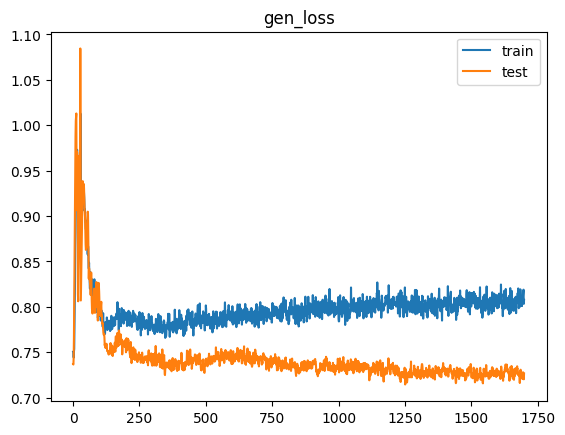

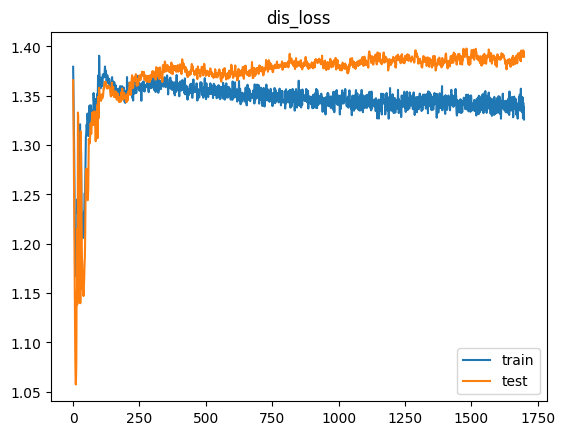

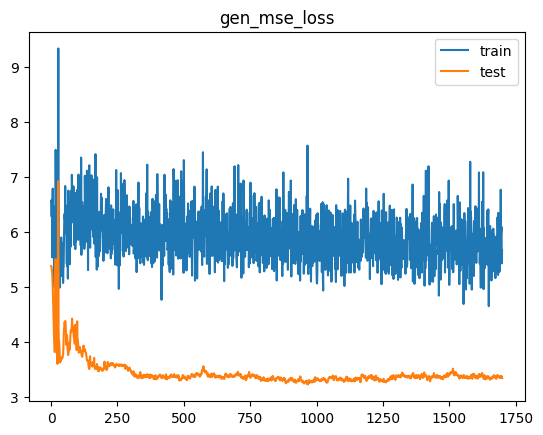

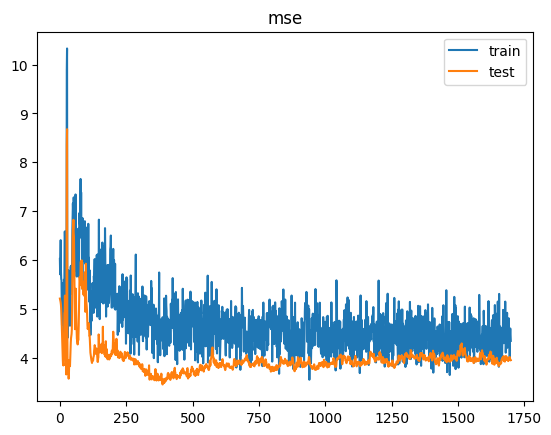

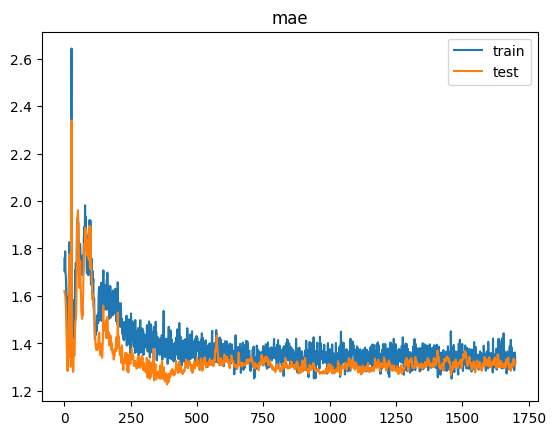

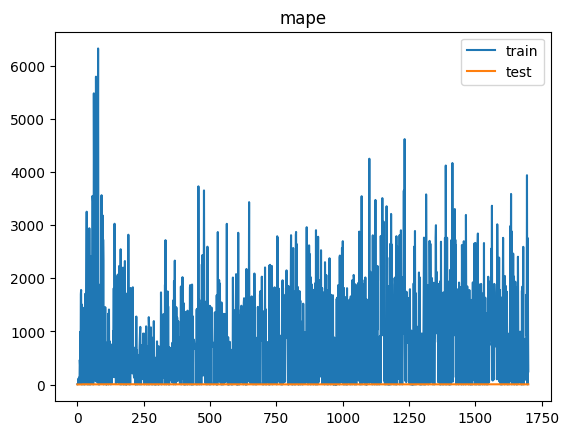

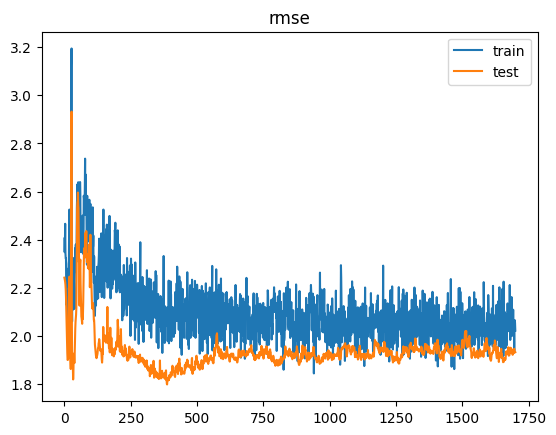

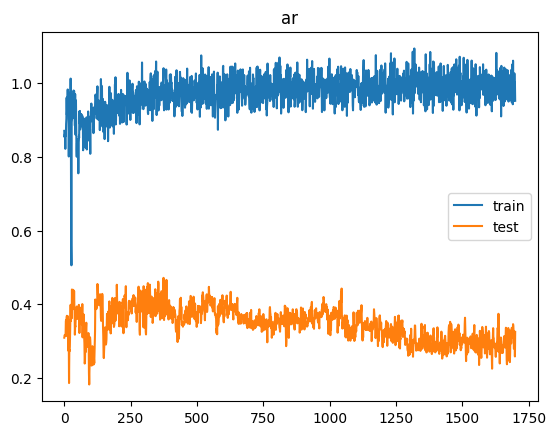

2/2 [==============================] - 1s 4ms/step


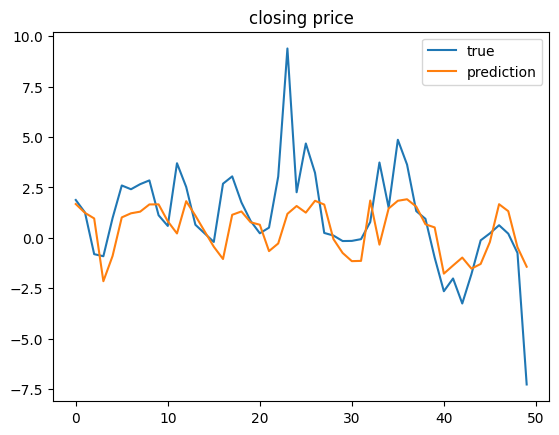

[MSE Baseline] train: 5.113448056489777  test: 3.634052838095099
Delta time with epochs = 1700: 0:17:51.803805
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_14 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.6810071468353271 sec Generator Loss: 0.9184538722038269,  Discriminator_loss: 1.2552241086959839
Time for epoch 52 is 0.6510887145996094 sec Generator Loss: 0.92622971534729,  Discriminator_loss: 1.2558189630508423
Time for epoch 53 is 0.643242597579956 sec Generator Loss: 0.910287082195282,  Discriminator_loss: 1.2412965297698975
Time for epoch 54 is 0.6603391170501709 sec Generator Loss: 0.9010756611824036,  Discriminator_loss: 1.2668802738189697
Time for epoch 55 is 0.6455395221710205 sec Generator Loss: 0.8994907140731812,  Discriminator_loss: 1.2854175567626953
Time for epoch 56 is 0.6452605724334717 sec Generator Loss: 0.8855140805244446,  Discriminator_loss: 1.293278455734253
Time for epoch 57 is 0.6530864238739014 sec Generator Loss: 0.8792704343795776,  Discriminator_loss: 1.2819983959197998
Time for epoch 58 is 0.5914547443389893 sec Generator Loss: 0.8873813152313232,  Discriminator_loss: 1.285773754119873
Time for epoch 59 is 0.6176948547363281 sec Ge

Time for epoch 120 is 0.6602182388305664 sec Generator Loss: 0.8224191069602966,  Discriminator_loss: 1.3304983377456665
Time for epoch 121 is 0.6856889724731445 sec Generator Loss: 0.8108662962913513,  Discriminator_loss: 1.3353757858276367
Time for epoch 122 is 0.6680417060852051 sec Generator Loss: 0.813601016998291,  Discriminator_loss: 1.32633638381958
Time for epoch 123 is 0.6728222370147705 sec Generator Loss: 0.804753303527832,  Discriminator_loss: 1.3413804769515991
Time for epoch 124 is 0.7215816974639893 sec Generator Loss: 0.801679790019989,  Discriminator_loss: 1.3493099212646484
Time for epoch 125 is 0.6811845302581787 sec Generator Loss: 0.816523015499115,  Discriminator_loss: 1.3350610733032227
Time for epoch 126 is 0.6679091453552246 sec Generator Loss: 0.8087570667266846,  Discriminator_loss: 1.3444359302520752
Time for epoch 127 is 0.6932680606842041 sec Generator Loss: 0.8084651231765747,  Discriminator_loss: 1.3527840375900269
Time for epoch 128 is 0.67261719703674

Time for epoch 189 is 0.6585304737091064 sec Generator Loss: 0.7904908657073975,  Discriminator_loss: 1.3558166027069092
Time for epoch 190 is 0.6409623622894287 sec Generator Loss: 0.7900024652481079,  Discriminator_loss: 1.3544715642929077
Time for epoch 191 is 0.6640923023223877 sec Generator Loss: 0.7964088916778564,  Discriminator_loss: 1.3487167358398438
Time for epoch 192 is 0.6491389274597168 sec Generator Loss: 0.7916656136512756,  Discriminator_loss: 1.3562486171722412
Time for epoch 193 is 0.6616785526275635 sec Generator Loss: 0.807171642780304,  Discriminator_loss: 1.343034029006958
Time for epoch 194 is 0.6474676132202148 sec Generator Loss: 0.7891548275947571,  Discriminator_loss: 1.3545618057250977
Time for epoch 195 is 0.6276381015777588 sec Generator Loss: 0.798629105091095,  Discriminator_loss: 1.347054123878479
Time for epoch 196 is 0.618746280670166 sec Generator Loss: 0.8013710379600525,  Discriminator_loss: 1.3509769439697266
Time for epoch 197 is 0.6169126033782

Time for epoch 258 is 0.6513099670410156 sec Generator Loss: 0.7889097332954407,  Discriminator_loss: 1.3501510620117188
Time for epoch 259 is 0.6649229526519775 sec Generator Loss: 0.8019664287567139,  Discriminator_loss: 1.3491655588150024
Time for epoch 260 is 0.6757011413574219 sec Generator Loss: 0.7933529615402222,  Discriminator_loss: 1.3573648929595947
Time for epoch 261 is 0.6092841625213623 sec Generator Loss: 0.7970319986343384,  Discriminator_loss: 1.3486546277999878
Time for epoch 262 is 0.6552424430847168 sec Generator Loss: 0.7930163145065308,  Discriminator_loss: 1.3486014604568481
Time for epoch 263 is 0.6329567432403564 sec Generator Loss: 0.8075771927833557,  Discriminator_loss: 1.3396713733673096
Time for epoch 264 is 0.6290385723114014 sec Generator Loss: 0.7953435182571411,  Discriminator_loss: 1.3573002815246582
Time for epoch 265 is 0.6616842746734619 sec Generator Loss: 0.8014061450958252,  Discriminator_loss: 1.3489058017730713
Time for epoch 266 is 0.63642859

Time for epoch 326 is 0.6653835773468018 sec Generator Loss: 0.7978377938270569,  Discriminator_loss: 1.3536454439163208
Time for epoch 327 is 0.6330733299255371 sec Generator Loss: 0.7910493016242981,  Discriminator_loss: 1.3554275035858154
Time for epoch 328 is 0.62978196144104 sec Generator Loss: 0.7924526929855347,  Discriminator_loss: 1.3517173528671265
Time for epoch 329 is 0.6181900501251221 sec Generator Loss: 0.7932689189910889,  Discriminator_loss: 1.3525383472442627
Time for epoch 330 is 0.6766030788421631 sec Generator Loss: 0.8059259653091431,  Discriminator_loss: 1.3490104675292969
Time for epoch 331 is 0.615044355392456 sec Generator Loss: 0.7923370599746704,  Discriminator_loss: 1.3438410758972168
Time for epoch 332 is 0.6108403205871582 sec Generator Loss: 0.7952319979667664,  Discriminator_loss: 1.3437182903289795
Time for epoch 333 is 0.6584720611572266 sec Generator Loss: 0.8037891387939453,  Discriminator_loss: 1.3492118120193481
Time for epoch 334 is 0.64505314826

Time for epoch 394 is 0.6549711227416992 sec Generator Loss: 0.8023639917373657,  Discriminator_loss: 1.3517706394195557
Time for epoch 395 is 0.6802690029144287 sec Generator Loss: 0.7966600656509399,  Discriminator_loss: 1.3514368534088135
Time for epoch 396 is 0.6949851512908936 sec Generator Loss: 0.799293577671051,  Discriminator_loss: 1.3512890338897705
Time for epoch 397 is 0.717193603515625 sec Generator Loss: 0.7931903600692749,  Discriminator_loss: 1.3489924669265747
Time for epoch 398 is 0.6770219802856445 sec Generator Loss: 0.7944391965866089,  Discriminator_loss: 1.3463069200515747
Time for epoch 399 is 0.671497106552124 sec Generator Loss: 0.7992232441902161,  Discriminator_loss: 1.3430839776992798
Time for epoch 400 is 0.6968100070953369 sec Generator Loss: 0.8035914897918701,  Discriminator_loss: 1.3502942323684692
Time for epoch 401 is 0.6812188625335693 sec Generator Loss: 0.7867909073829651,  Discriminator_loss: 1.3637053966522217
Time for epoch 402 is 0.68698310852

Time for epoch 463 is 0.6698172092437744 sec Generator Loss: 0.7983090877532959,  Discriminator_loss: 1.34367835521698
Time for epoch 464 is 0.6466405391693115 sec Generator Loss: 0.7953744530677795,  Discriminator_loss: 1.3553334474563599
Time for epoch 465 is 0.6286470890045166 sec Generator Loss: 0.8023539185523987,  Discriminator_loss: 1.3437275886535645
Time for epoch 466 is 0.6504580974578857 sec Generator Loss: 0.7878100275993347,  Discriminator_loss: 1.3457587957382202
Time for epoch 467 is 0.6621556282043457 sec Generator Loss: 0.8000655770301819,  Discriminator_loss: 1.3491772413253784
Time for epoch 468 is 0.6511516571044922 sec Generator Loss: 0.7953126430511475,  Discriminator_loss: 1.347313642501831
Time for epoch 469 is 0.6380493640899658 sec Generator Loss: 0.793134868144989,  Discriminator_loss: 1.347292423248291
Time for epoch 470 is 0.619779109954834 sec Generator Loss: 0.80864018201828,  Discriminator_loss: 1.3456133604049683
Time for epoch 471 is 0.7010912895202637

Time for epoch 532 is 0.7204349040985107 sec Generator Loss: 0.8065893650054932,  Discriminator_loss: 1.3370341062545776
Time for epoch 533 is 0.6730165481567383 sec Generator Loss: 0.8008416891098022,  Discriminator_loss: 1.345710277557373
Time for epoch 534 is 0.6308505535125732 sec Generator Loss: 0.8055620193481445,  Discriminator_loss: 1.3373050689697266
Time for epoch 535 is 0.6667909622192383 sec Generator Loss: 0.8040515780448914,  Discriminator_loss: 1.331671953201294
Time for epoch 536 is 0.6328437328338623 sec Generator Loss: 0.801853597164154,  Discriminator_loss: 1.3354918956756592
Time for epoch 537 is 0.6663634777069092 sec Generator Loss: 0.8112671375274658,  Discriminator_loss: 1.3453840017318726
Time for epoch 538 is 0.6778514385223389 sec Generator Loss: 0.7990873456001282,  Discriminator_loss: 1.3475210666656494
Time for epoch 539 is 0.6451034545898438 sec Generator Loss: 0.8150853514671326,  Discriminator_loss: 1.345072865486145
Time for epoch 540 is 0.655270576477

Time for epoch 601 is 0.6518516540527344 sec Generator Loss: 0.8055435419082642,  Discriminator_loss: 1.3361774682998657
Time for epoch 602 is 0.6417238712310791 sec Generator Loss: 0.8107950687408447,  Discriminator_loss: 1.344259262084961
Time for epoch 603 is 0.6749863624572754 sec Generator Loss: 0.8039034008979797,  Discriminator_loss: 1.3382704257965088
Time for epoch 604 is 0.687971830368042 sec Generator Loss: 0.8008647561073303,  Discriminator_loss: 1.3451521396636963
Time for epoch 605 is 0.6579010486602783 sec Generator Loss: 0.8091641664505005,  Discriminator_loss: 1.3345614671707153
Time for epoch 606 is 0.6497142314910889 sec Generator Loss: 0.8144692778587341,  Discriminator_loss: 1.3343886137008667
Time for epoch 607 is 0.6409845352172852 sec Generator Loss: 0.8100988268852234,  Discriminator_loss: 1.335294485092163
Time for epoch 608 is 0.6333014965057373 sec Generator Loss: 0.8250045776367188,  Discriminator_loss: 1.3220462799072266
Time for epoch 609 is 0.68776726722

Time for epoch 669 is 0.7532002925872803 sec Generator Loss: 0.8163068294525146,  Discriminator_loss: 1.3468014001846313
Time for epoch 670 is 0.7506177425384521 sec Generator Loss: 0.827593982219696,  Discriminator_loss: 1.331846833229065
Time for epoch 671 is 0.6903564929962158 sec Generator Loss: 0.813895583152771,  Discriminator_loss: 1.3399542570114136
Time for epoch 672 is 0.702974796295166 sec Generator Loss: 0.8132992386817932,  Discriminator_loss: 1.343133807182312
Time for epoch 673 is 0.7112560272216797 sec Generator Loss: 0.8101094961166382,  Discriminator_loss: 1.344469428062439
Time for epoch 674 is 0.7396388053894043 sec Generator Loss: 0.8160824179649353,  Discriminator_loss: 1.323020577430725
Time for epoch 675 is 0.7674627304077148 sec Generator Loss: 0.81088787317276,  Discriminator_loss: 1.3357486724853516
Time for epoch 676 is 0.6936805248260498 sec Generator Loss: 0.8149016499519348,  Discriminator_loss: 1.333547830581665
Time for epoch 677 is 0.7241613864898682 s

Time for epoch 738 is 0.671083927154541 sec Generator Loss: 0.8083087205886841,  Discriminator_loss: 1.339379072189331
Time for epoch 739 is 0.6739740371704102 sec Generator Loss: 0.8099166750907898,  Discriminator_loss: 1.3338500261306763
Time for epoch 740 is 0.6663498878479004 sec Generator Loss: 0.7991859316825867,  Discriminator_loss: 1.3406552076339722
Time for epoch 741 is 0.6737902164459229 sec Generator Loss: 0.8117848038673401,  Discriminator_loss: 1.333606243133545
Time for epoch 742 is 0.642784833908081 sec Generator Loss: 0.8162838220596313,  Discriminator_loss: 1.3233833312988281
Time for epoch 743 is 0.6959018707275391 sec Generator Loss: 0.8153889179229736,  Discriminator_loss: 1.3341238498687744
Time for epoch 744 is 0.6626133918762207 sec Generator Loss: 0.8256102204322815,  Discriminator_loss: 1.3292053937911987
Time for epoch 745 is 0.6996088027954102 sec Generator Loss: 0.8182427287101746,  Discriminator_loss: 1.3320329189300537
Time for epoch 746 is 0.693672657012

Time for epoch 807 is 0.6441657543182373 sec Generator Loss: 0.8262941837310791,  Discriminator_loss: 1.3299211263656616
Time for epoch 808 is 0.6879010200500488 sec Generator Loss: 0.8168333768844604,  Discriminator_loss: 1.3376535177230835
Time for epoch 809 is 0.6335005760192871 sec Generator Loss: 0.8026416897773743,  Discriminator_loss: 1.3466640710830688
Time for epoch 810 is 0.6942365169525146 sec Generator Loss: 0.812785267829895,  Discriminator_loss: 1.3324233293533325
Time for epoch 811 is 0.670586109161377 sec Generator Loss: 0.8188220262527466,  Discriminator_loss: 1.3373421430587769
Time for epoch 812 is 0.7140207290649414 sec Generator Loss: 0.8170005679130554,  Discriminator_loss: 1.3299709558486938
Time for epoch 813 is 0.7084319591522217 sec Generator Loss: 0.8285949230194092,  Discriminator_loss: 1.3322006464004517
Time for epoch 814 is 0.7238106727600098 sec Generator Loss: 0.8218808174133301,  Discriminator_loss: 1.3311768770217896
Time for epoch 815 is 0.7271184921

Time for epoch 875 is 0.6646955013275146 sec Generator Loss: 0.8274977207183838,  Discriminator_loss: 1.3254133462905884
Time for epoch 876 is 0.6541666984558105 sec Generator Loss: 0.8166509866714478,  Discriminator_loss: 1.3263846635818481
Time for epoch 877 is 0.7048089504241943 sec Generator Loss: 0.831463098526001,  Discriminator_loss: 1.321600317955017
Time for epoch 878 is 0.6981067657470703 sec Generator Loss: 0.8257353901863098,  Discriminator_loss: 1.3345999717712402
Time for epoch 879 is 0.6308317184448242 sec Generator Loss: 0.8329886794090271,  Discriminator_loss: 1.32174813747406
Time for epoch 880 is 0.6571462154388428 sec Generator Loss: 0.8399189114570618,  Discriminator_loss: 1.3197214603424072
Time for epoch 881 is 0.7054412364959717 sec Generator Loss: 0.8178960680961609,  Discriminator_loss: 1.3354439735412598
Time for epoch 882 is 0.6667256355285645 sec Generator Loss: 0.8234214186668396,  Discriminator_loss: 1.3319098949432373
Time for epoch 883 is 0.753669023513

Time for epoch 943 is 0.7116336822509766 sec Generator Loss: 0.8195304274559021,  Discriminator_loss: 1.3329967260360718
Time for epoch 944 is 0.675447940826416 sec Generator Loss: 0.8282967209815979,  Discriminator_loss: 1.3272122144699097
Time for epoch 945 is 0.723823070526123 sec Generator Loss: 0.8253145217895508,  Discriminator_loss: 1.3279510736465454
Time for epoch 946 is 0.6878213882446289 sec Generator Loss: 0.8232712149620056,  Discriminator_loss: 1.3294939994812012
Time for epoch 947 is 0.685279130935669 sec Generator Loss: 0.8364572525024414,  Discriminator_loss: 1.328784704208374
Time for epoch 948 is 0.6580536365509033 sec Generator Loss: 0.8290579319000244,  Discriminator_loss: 1.3304195404052734
Time for epoch 949 is 0.650205135345459 sec Generator Loss: 0.8103100061416626,  Discriminator_loss: 1.3335098028182983
Time for epoch 950 is 0.6567680835723877 sec Generator Loss: 0.8253562450408936,  Discriminator_loss: 1.3384236097335815
Time for epoch 951 is 0.6735184192657

Time for epoch 1011 is 0.7894659042358398 sec Generator Loss: 0.8287685513496399,  Discriminator_loss: 1.3372949361801147
Time for epoch 1012 is 0.8606009483337402 sec Generator Loss: 0.8099694848060608,  Discriminator_loss: 1.3265531063079834
Time for epoch 1013 is 0.7756555080413818 sec Generator Loss: 0.8228257298469543,  Discriminator_loss: 1.3283404111862183
Time for epoch 1014 is 0.7751803398132324 sec Generator Loss: 0.8218683004379272,  Discriminator_loss: 1.3259950876235962
Time for epoch 1015 is 0.737574577331543 sec Generator Loss: 0.8299177885055542,  Discriminator_loss: 1.3236677646636963
Time for epoch 1016 is 0.8419783115386963 sec Generator Loss: 0.8170814514160156,  Discriminator_loss: 1.3354116678237915
Time for epoch 1017 is 0.7870707511901855 sec Generator Loss: 0.8303701877593994,  Discriminator_loss: 1.3255301713943481
Time for epoch 1018 is 0.7034657001495361 sec Generator Loss: 0.8312008380889893,  Discriminator_loss: 1.3200446367263794
Time for epoch 1019 is 0.

Time for epoch 1079 is 0.6657631397247314 sec Generator Loss: 0.8372713327407837,  Discriminator_loss: 1.3277294635772705
Time for epoch 1080 is 0.7212541103363037 sec Generator Loss: 0.8287696242332458,  Discriminator_loss: 1.329984188079834
Time for epoch 1081 is 0.7173326015472412 sec Generator Loss: 0.823802649974823,  Discriminator_loss: 1.3252121210098267
Time for epoch 1082 is 0.7161216735839844 sec Generator Loss: 0.8371456265449524,  Discriminator_loss: 1.320319652557373
Time for epoch 1083 is 0.7963943481445312 sec Generator Loss: 0.839868426322937,  Discriminator_loss: 1.3208835124969482
Time for epoch 1084 is 0.7061381340026855 sec Generator Loss: 0.8198204636573792,  Discriminator_loss: 1.3327144384384155
Time for epoch 1085 is 0.7584488391876221 sec Generator Loss: 0.8204304575920105,  Discriminator_loss: 1.3232086896896362
Time for epoch 1086 is 0.7389442920684814 sec Generator Loss: 0.8212403059005737,  Discriminator_loss: 1.3289027214050293
Time for epoch 1087 is 0.731

Time for epoch 1147 is 0.771268367767334 sec Generator Loss: 0.81851726770401,  Discriminator_loss: 1.3307934999465942
Time for epoch 1148 is 0.712489128112793 sec Generator Loss: 0.8161234259605408,  Discriminator_loss: 1.330270767211914
Time for epoch 1149 is 0.7007896900177002 sec Generator Loss: 0.8244969844818115,  Discriminator_loss: 1.326811671257019
Time for epoch 1150 is 0.6930618286132812 sec Generator Loss: 0.822935163974762,  Discriminator_loss: 1.3192172050476074
Time for epoch 1151 is 0.7285792827606201 sec Generator Loss: 0.8217000961303711,  Discriminator_loss: 1.3407701253890991
Time for epoch 1152 is 0.7912731170654297 sec Generator Loss: 0.8245220184326172,  Discriminator_loss: 1.328199028968811
Time for epoch 1153 is 0.6429934501647949 sec Generator Loss: 0.8258864879608154,  Discriminator_loss: 1.3261359930038452
Time for epoch 1154 is 0.6913764476776123 sec Generator Loss: 0.8242141008377075,  Discriminator_loss: 1.3337560892105103
Time for epoch 1155 is 0.7007551

Time for epoch 1215 is 0.7300360202789307 sec Generator Loss: 0.8422759771347046,  Discriminator_loss: 1.3200465440750122
Time for epoch 1216 is 0.6987767219543457 sec Generator Loss: 0.8387454152107239,  Discriminator_loss: 1.3384482860565186
Time for epoch 1217 is 0.7082078456878662 sec Generator Loss: 0.8315163850784302,  Discriminator_loss: 1.3174647092819214
Time for epoch 1218 is 0.6666929721832275 sec Generator Loss: 0.8263106346130371,  Discriminator_loss: 1.3295098543167114
Time for epoch 1219 is 0.6937582492828369 sec Generator Loss: 0.8214734792709351,  Discriminator_loss: 1.331316590309143
Time for epoch 1220 is 0.6980512142181396 sec Generator Loss: 0.8345372080802917,  Discriminator_loss: 1.3260804414749146
Time for epoch 1221 is 0.6649043560028076 sec Generator Loss: 0.8343033194541931,  Discriminator_loss: 1.3140548467636108
Time for epoch 1222 is 0.728959321975708 sec Generator Loss: 0.8197528123855591,  Discriminator_loss: 1.3386039733886719
Time for epoch 1223 is 0.6

Time for epoch 1283 is 0.9064695835113525 sec Generator Loss: 0.8255796432495117,  Discriminator_loss: 1.3326263427734375
Time for epoch 1284 is 0.8786170482635498 sec Generator Loss: 0.833369791507721,  Discriminator_loss: 1.3255722522735596
Time for epoch 1285 is 0.849982500076294 sec Generator Loss: 0.828642725944519,  Discriminator_loss: 1.3306597471237183
Time for epoch 1286 is 0.8443095684051514 sec Generator Loss: 0.8272103667259216,  Discriminator_loss: 1.3284988403320312
Time for epoch 1287 is 0.8306746482849121 sec Generator Loss: 0.8322829604148865,  Discriminator_loss: 1.3233722448349
Time for epoch 1288 is 0.882143497467041 sec Generator Loss: 0.8250532746315002,  Discriminator_loss: 1.3287309408187866
Time for epoch 1289 is 0.8183510303497314 sec Generator Loss: 0.8161178231239319,  Discriminator_loss: 1.337476372718811
Time for epoch 1290 is 0.8099956512451172 sec Generator Loss: 0.8328309655189514,  Discriminator_loss: 1.32268226146698
Time for epoch 1291 is 0.803622007

Time for epoch 1351 is 0.8008091449737549 sec Generator Loss: 0.8262282609939575,  Discriminator_loss: 1.3338223695755005
Time for epoch 1352 is 0.6960880756378174 sec Generator Loss: 0.8228769302368164,  Discriminator_loss: 1.3391175270080566
Time for epoch 1353 is 0.7085540294647217 sec Generator Loss: 0.8294407725334167,  Discriminator_loss: 1.3191499710083008
Time for epoch 1354 is 0.7251274585723877 sec Generator Loss: 0.8396381139755249,  Discriminator_loss: 1.3223551511764526
Time for epoch 1355 is 0.7189199924468994 sec Generator Loss: 0.8199225664138794,  Discriminator_loss: 1.3367985486984253
Time for epoch 1356 is 0.6953849792480469 sec Generator Loss: 0.8457372784614563,  Discriminator_loss: 1.3161187171936035
Time for epoch 1357 is 0.694514274597168 sec Generator Loss: 0.8298037648200989,  Discriminator_loss: 1.3184055089950562
Time for epoch 1358 is 0.7406878471374512 sec Generator Loss: 0.8229233026504517,  Discriminator_loss: 1.328370213508606
Time for epoch 1359 is 0.7

Time for epoch 1419 is 0.7819550037384033 sec Generator Loss: 0.8218650221824646,  Discriminator_loss: 1.323221206665039
Time for epoch 1420 is 0.723299503326416 sec Generator Loss: 0.8159798979759216,  Discriminator_loss: 1.3322798013687134
Time for epoch 1421 is 0.7362120151519775 sec Generator Loss: 0.823536217212677,  Discriminator_loss: 1.3360836505889893
Time for epoch 1422 is 0.7333362102508545 sec Generator Loss: 0.8312221169471741,  Discriminator_loss: 1.3303241729736328
Time for epoch 1423 is 0.7697603702545166 sec Generator Loss: 0.8293567895889282,  Discriminator_loss: 1.3218976259231567
Time for epoch 1424 is 0.724722146987915 sec Generator Loss: 0.8366392254829407,  Discriminator_loss: 1.308859944343567
Time for epoch 1425 is 0.7229256629943848 sec Generator Loss: 0.8283576965332031,  Discriminator_loss: 1.3236340284347534
Time for epoch 1426 is 0.7126767635345459 sec Generator Loss: 0.8317307233810425,  Discriminator_loss: 1.3319507837295532
Time for epoch 1427 is 0.7036

Time for epoch 1487 is 0.7875008583068848 sec Generator Loss: 0.8282786011695862,  Discriminator_loss: 1.3267371654510498
Time for epoch 1488 is 0.7719597816467285 sec Generator Loss: 0.8259453177452087,  Discriminator_loss: 1.3263133764266968
Time for epoch 1489 is 0.7415223121643066 sec Generator Loss: 0.8194640874862671,  Discriminator_loss: 1.3354514837265015
Time for epoch 1490 is 0.7822268009185791 sec Generator Loss: 0.8248589038848877,  Discriminator_loss: 1.3289097547531128
Time for epoch 1491 is 0.763559103012085 sec Generator Loss: 0.8201809525489807,  Discriminator_loss: 1.32620108127594
Time for epoch 1492 is 0.8152971267700195 sec Generator Loss: 0.8255226612091064,  Discriminator_loss: 1.3275026082992554
Time for epoch 1493 is 0.8566927909851074 sec Generator Loss: 0.8255024552345276,  Discriminator_loss: 1.3267496824264526
Time for epoch 1494 is 0.7582099437713623 sec Generator Loss: 0.8101642727851868,  Discriminator_loss: 1.3291608095169067
Time for epoch 1495 is 0.77

Time for epoch 1555 is 0.7394075393676758 sec Generator Loss: 0.8402988910675049,  Discriminator_loss: 1.3173034191131592
Time for epoch 1556 is 0.7539887428283691 sec Generator Loss: 0.8391578793525696,  Discriminator_loss: 1.3241997957229614
Time for epoch 1557 is 0.6977286338806152 sec Generator Loss: 0.8386005759239197,  Discriminator_loss: 1.3130584955215454
Time for epoch 1558 is 0.7512280941009521 sec Generator Loss: 0.8466199636459351,  Discriminator_loss: 1.3323615789413452
Time for epoch 1559 is 0.7378995418548584 sec Generator Loss: 0.8299664258956909,  Discriminator_loss: 1.3281480073928833
Time for epoch 1560 is 0.7917580604553223 sec Generator Loss: 0.8356916904449463,  Discriminator_loss: 1.3149815797805786
Time for epoch 1561 is 0.7310562133789062 sec Generator Loss: 0.8288998007774353,  Discriminator_loss: 1.335747241973877
Time for epoch 1562 is 0.771916389465332 sec Generator Loss: 0.8334740996360779,  Discriminator_loss: 1.3188620805740356
Time for epoch 1563 is 0.7

Time for epoch 1623 is 0.634467363357544 sec Generator Loss: 0.8285111784934998,  Discriminator_loss: 1.3262836933135986
Time for epoch 1624 is 0.6031982898712158 sec Generator Loss: 0.8292163610458374,  Discriminator_loss: 1.3310691118240356
Time for epoch 1625 is 0.6179192066192627 sec Generator Loss: 0.8233509659767151,  Discriminator_loss: 1.316036581993103
Time for epoch 1626 is 0.6140155792236328 sec Generator Loss: 0.8142021894454956,  Discriminator_loss: 1.3429555892944336
Time for epoch 1627 is 0.6278839111328125 sec Generator Loss: 0.8297170400619507,  Discriminator_loss: 1.3270084857940674
Time for epoch 1628 is 0.6444118022918701 sec Generator Loss: 0.8346383571624756,  Discriminator_loss: 1.3248692750930786
Time for epoch 1629 is 0.5949127674102783 sec Generator Loss: 0.8238940834999084,  Discriminator_loss: 1.327185869216919
Time for epoch 1630 is 0.5946881771087646 sec Generator Loss: 0.8388993144035339,  Discriminator_loss: 1.320029377937317
Time for epoch 1631 is 0.607

Time for epoch 1691 is 0.6040019989013672 sec Generator Loss: 0.8313766121864319,  Discriminator_loss: 1.322007179260254
Time for epoch 1692 is 0.6279120445251465 sec Generator Loss: 0.8265400528907776,  Discriminator_loss: 1.3175126314163208
Time for epoch 1693 is 0.6156971454620361 sec Generator Loss: 0.8196061253547668,  Discriminator_loss: 1.3340561389923096
Time for epoch 1694 is 0.6031224727630615 sec Generator Loss: 0.8373252153396606,  Discriminator_loss: 1.3129826784133911
Time for epoch 1695 is 0.6171131134033203 sec Generator Loss: 0.8348231315612793,  Discriminator_loss: 1.3262543678283691
Time for epoch 1696 is 0.6737298965454102 sec Generator Loss: 0.8388576507568359,  Discriminator_loss: 1.3264539241790771
Time for epoch 1697 is 0.630528450012207 sec Generator Loss: 0.8419187664985657,  Discriminator_loss: 1.3265489339828491
Time for epoch 1698 is 0.6138749122619629 sec Generator Loss: 0.8319817781448364,  Discriminator_loss: 1.3261113166809082
Time for epoch 1699 is 0.6

Time for epoch 1759 is 0.6216485500335693 sec Generator Loss: 0.8256937861442566,  Discriminator_loss: 1.3290621042251587
Time for epoch 1760 is 0.6420176029205322 sec Generator Loss: 0.8276202082633972,  Discriminator_loss: 1.3197354078292847
Time for epoch 1761 is 0.6211996078491211 sec Generator Loss: 0.8298225402832031,  Discriminator_loss: 1.3265492916107178
Time for epoch 1762 is 0.632596492767334 sec Generator Loss: 0.8326918482780457,  Discriminator_loss: 1.322735071182251
Time for epoch 1763 is 0.6681158542633057 sec Generator Loss: 0.828436017036438,  Discriminator_loss: 1.3151568174362183
Time for epoch 1764 is 0.6167728900909424 sec Generator Loss: 0.8415435552597046,  Discriminator_loss: 1.3162201642990112
Time for epoch 1765 is 0.6086795330047607 sec Generator Loss: 0.8349897861480713,  Discriminator_loss: 1.3286126852035522
Time for epoch 1766 is 0.6329145431518555 sec Generator Loss: 0.8356527090072632,  Discriminator_loss: 1.3207104206085205
Time for epoch 1767 is 0.59

Time for epoch 1827 is 0.6464660167694092 sec Generator Loss: 0.8220314979553223,  Discriminator_loss: 1.3261913061141968
Time for epoch 1828 is 0.6586272716522217 sec Generator Loss: 0.8262349963188171,  Discriminator_loss: 1.3190282583236694
Time for epoch 1829 is 0.6242833137512207 sec Generator Loss: 0.834594190120697,  Discriminator_loss: 1.3198314905166626
Time for epoch 1830 is 0.6294445991516113 sec Generator Loss: 0.838956892490387,  Discriminator_loss: 1.3252744674682617
Time for epoch 1831 is 0.6610229015350342 sec Generator Loss: 0.8359365463256836,  Discriminator_loss: 1.3131898641586304
Time for epoch 1832 is 0.628227710723877 sec Generator Loss: 0.8356067538261414,  Discriminator_loss: 1.319530725479126
Time for epoch 1833 is 0.6726934909820557 sec Generator Loss: 0.8335165977478027,  Discriminator_loss: 1.327162265777588
Time for epoch 1834 is 0.6476826667785645 sec Generator Loss: 0.8311172127723694,  Discriminator_loss: 1.3248258829116821
Time for epoch 1835 is 0.6126

Time for epoch 1895 is 0.7480363845825195 sec Generator Loss: 0.8411513566970825,  Discriminator_loss: 1.316739559173584
Time for epoch 1896 is 0.6744623184204102 sec Generator Loss: 0.8347061276435852,  Discriminator_loss: 1.3277148008346558
Time for epoch 1897 is 0.6592259407043457 sec Generator Loss: 0.8351062536239624,  Discriminator_loss: 1.3179408311843872
Time for epoch 1898 is 0.7026019096374512 sec Generator Loss: 0.8289926052093506,  Discriminator_loss: 1.3259752988815308
Time for epoch 1899 is 0.7094693183898926 sec Generator Loss: 0.8231829404830933,  Discriminator_loss: 1.3312584161758423
Time for epoch 1900 is 0.6340248584747314 sec Generator Loss: 0.835911214351654,  Discriminator_loss: 1.3197181224822998
Time for epoch 1901 is 0.6644444465637207 sec Generator Loss: 0.8360286355018616,  Discriminator_loss: 1.3216588497161865
Time for epoch 1902 is 0.6633172035217285 sec Generator Loss: 0.8434011340141296,  Discriminator_loss: 1.3165546655654907
Time for epoch 1903 is 0.6

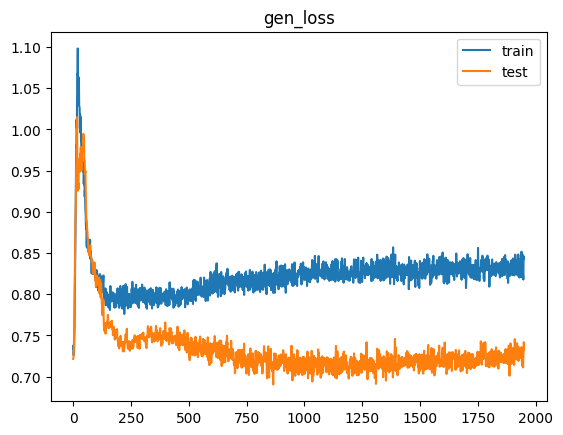

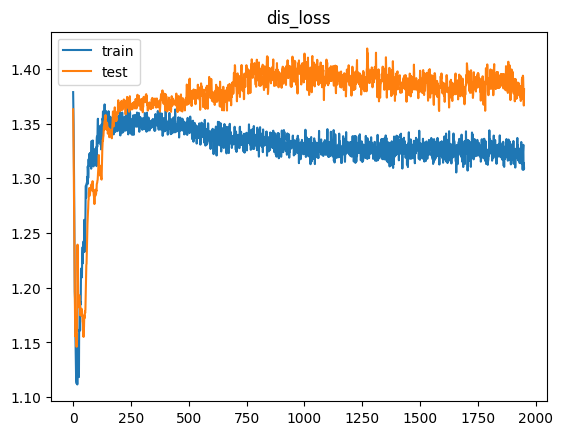

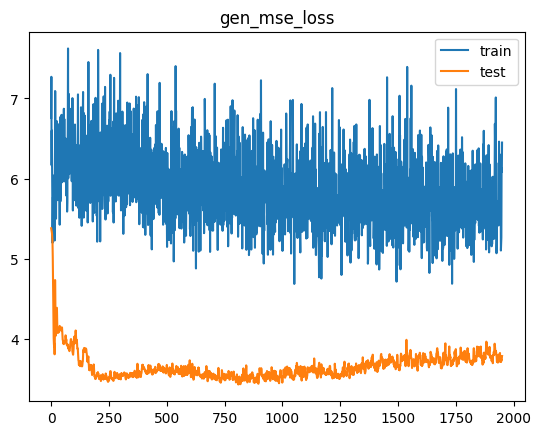

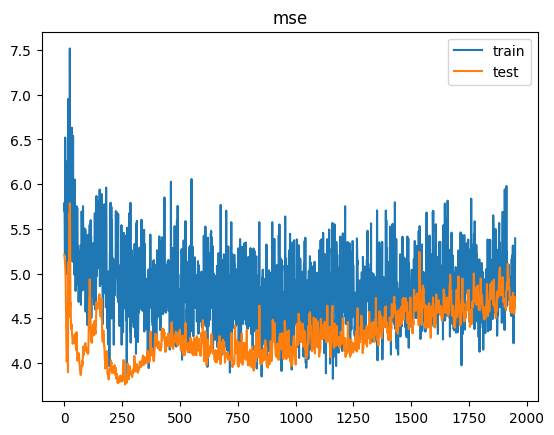

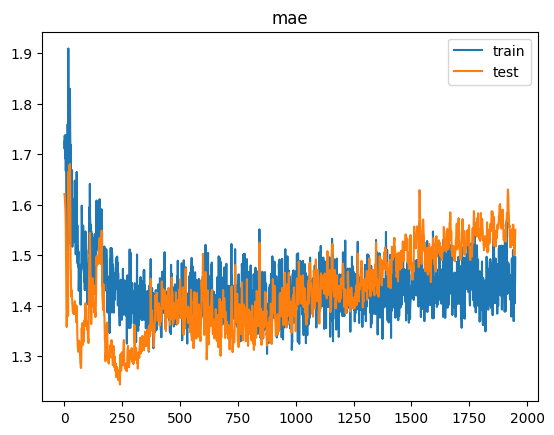

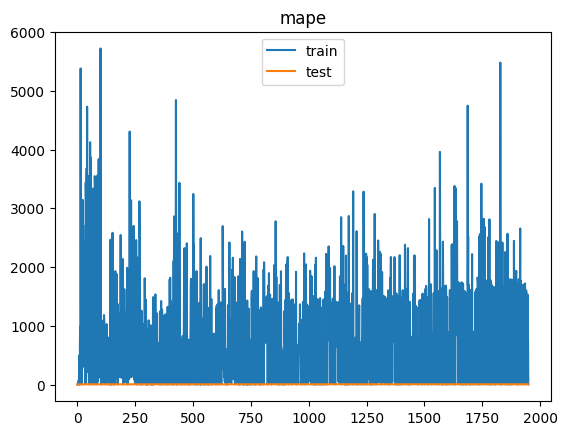

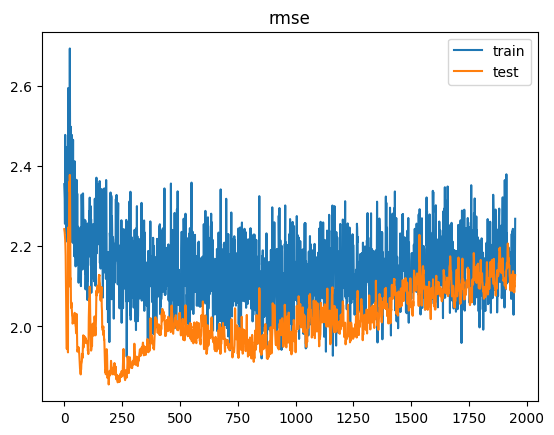

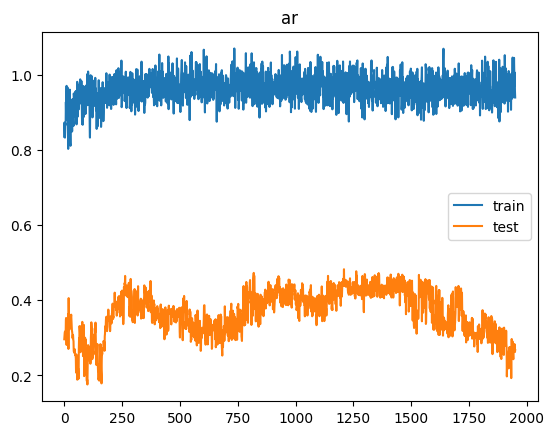

2/2 [==============================] - 0s 6ms/step


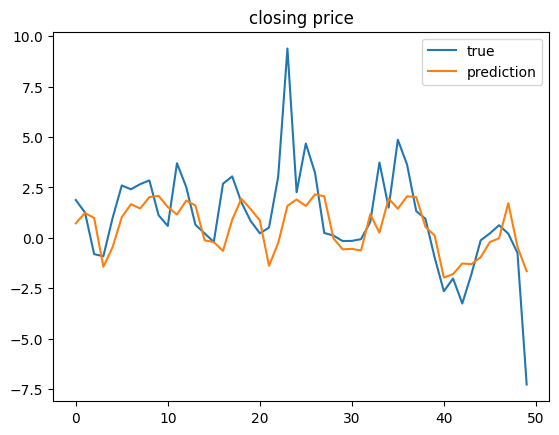

[MSE Baseline] train: 4.649534721752535  test: 3.634052838095099
Delta time with epochs = 1950: 0:22:42.365092


In [19]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_16 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_40 (Dropout)        (None, 5, 20)             0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 20)               2480

Time for epoch 52 is 0.6652753353118896 sec Generator Loss: 0.8947480916976929,  Discriminator_loss: 1.2814940214157104
Time for epoch 53 is 0.6533355712890625 sec Generator Loss: 0.9025325179100037,  Discriminator_loss: 1.2504719495773315
Time for epoch 54 is 0.6577205657958984 sec Generator Loss: 0.8975552916526794,  Discriminator_loss: 1.2642136812210083
Time for epoch 55 is 0.6607911586761475 sec Generator Loss: 0.8933801054954529,  Discriminator_loss: 1.2737696170806885
Time for epoch 56 is 0.6945910453796387 sec Generator Loss: 0.8823257088661194,  Discriminator_loss: 1.2814513444900513
Time for epoch 57 is 0.6851553916931152 sec Generator Loss: 0.8810278177261353,  Discriminator_loss: 1.3019657135009766
Time for epoch 58 is 0.6793985366821289 sec Generator Loss: 0.8864357471466064,  Discriminator_loss: 1.292225956916809
Time for epoch 59 is 0.7054941654205322 sec Generator Loss: 0.8796114325523376,  Discriminator_loss: 1.30814790725708
Time for epoch 60 is 0.7045571804046631 sec

Time for epoch 121 is 0.665302038192749 sec Generator Loss: 0.782439112663269,  Discriminator_loss: 1.3505733013153076
Time for epoch 122 is 0.6273133754730225 sec Generator Loss: 0.8034645915031433,  Discriminator_loss: 1.3455830812454224
Time for epoch 123 is 0.622136116027832 sec Generator Loss: 0.7990570664405823,  Discriminator_loss: 1.34714937210083
Time for epoch 124 is 0.628455400466919 sec Generator Loss: 0.8053597211837769,  Discriminator_loss: 1.3465911149978638
Time for epoch 125 is 0.6311368942260742 sec Generator Loss: 0.785108745098114,  Discriminator_loss: 1.3604108095169067
Time for epoch 126 is 0.6247818470001221 sec Generator Loss: 0.7939799427986145,  Discriminator_loss: 1.35347318649292
Time for epoch 127 is 0.6305432319641113 sec Generator Loss: 0.7858085036277771,  Discriminator_loss: 1.359093189239502
Time for epoch 128 is 0.643040657043457 sec Generator Loss: 0.7903039455413818,  Discriminator_loss: 1.3544343709945679
Time for epoch 129 is 0.6796848773956299 se

Time for epoch 190 is 0.6483123302459717 sec Generator Loss: 0.7835589647293091,  Discriminator_loss: 1.3546162843704224
Time for epoch 191 is 0.660212516784668 sec Generator Loss: 0.7837585806846619,  Discriminator_loss: 1.3634387254714966
Time for epoch 192 is 0.6295032501220703 sec Generator Loss: 0.7878831624984741,  Discriminator_loss: 1.3519917726516724
Time for epoch 193 is 0.6394212245941162 sec Generator Loss: 0.7911946773529053,  Discriminator_loss: 1.3497987985610962
Time for epoch 194 is 0.6576223373413086 sec Generator Loss: 0.7879269123077393,  Discriminator_loss: 1.348103404045105
Time for epoch 195 is 0.642897367477417 sec Generator Loss: 0.7902131676673889,  Discriminator_loss: 1.3526312112808228
Time for epoch 196 is 0.6386096477508545 sec Generator Loss: 0.793248176574707,  Discriminator_loss: 1.3535056114196777
Time for epoch 197 is 0.6277532577514648 sec Generator Loss: 0.7851815819740295,  Discriminator_loss: 1.351799488067627
Time for epoch 198 is 0.6359832286834

Time for epoch 258 is 0.6525235176086426 sec Generator Loss: 0.778251051902771,  Discriminator_loss: 1.3557029962539673
Time for epoch 259 is 0.6307106018066406 sec Generator Loss: 0.782619059085846,  Discriminator_loss: 1.354106068611145
Time for epoch 260 is 0.6770443916320801 sec Generator Loss: 0.7806411981582642,  Discriminator_loss: 1.3559802770614624
Time for epoch 261 is 0.6275253295898438 sec Generator Loss: 0.7920595407485962,  Discriminator_loss: 1.3516746759414673
Time for epoch 262 is 0.6448464393615723 sec Generator Loss: 0.7791163921356201,  Discriminator_loss: 1.36009681224823
Time for epoch 263 is 0.6318798065185547 sec Generator Loss: 0.7851114273071289,  Discriminator_loss: 1.3482327461242676
Time for epoch 264 is 0.6133739948272705 sec Generator Loss: 0.7805899381637573,  Discriminator_loss: 1.3555439710617065
Time for epoch 265 is 0.6531205177307129 sec Generator Loss: 0.7795030474662781,  Discriminator_loss: 1.353165864944458
Time for epoch 266 is 0.63903713226318

Time for epoch 327 is 0.6414532661437988 sec Generator Loss: 0.776634693145752,  Discriminator_loss: 1.3592944145202637
Time for epoch 328 is 0.6025862693786621 sec Generator Loss: 0.7859851121902466,  Discriminator_loss: 1.3610618114471436
Time for epoch 329 is 0.6402440071105957 sec Generator Loss: 0.7826929092407227,  Discriminator_loss: 1.3536850214004517
Time for epoch 330 is 0.6995165348052979 sec Generator Loss: 0.7763084173202515,  Discriminator_loss: 1.3633487224578857
Time for epoch 331 is 0.6704778671264648 sec Generator Loss: 0.7886574864387512,  Discriminator_loss: 1.355833888053894
Time for epoch 332 is 0.699998140335083 sec Generator Loss: 0.7765474915504456,  Discriminator_loss: 1.3603456020355225
Time for epoch 333 is 0.6868705749511719 sec Generator Loss: 0.7812605500221252,  Discriminator_loss: 1.359407663345337
Time for epoch 334 is 0.6829493045806885 sec Generator Loss: 0.7780953049659729,  Discriminator_loss: 1.3517405986785889
Time for epoch 335 is 0.741311073303

Time for epoch 395 is 0.6497781276702881 sec Generator Loss: 0.7858375310897827,  Discriminator_loss: 1.3576301336288452
Time for epoch 396 is 0.6395623683929443 sec Generator Loss: 0.7932814359664917,  Discriminator_loss: 1.3519771099090576
Time for epoch 397 is 0.6124472618103027 sec Generator Loss: 0.7869399785995483,  Discriminator_loss: 1.353161096572876
Time for epoch 398 is 0.6596877574920654 sec Generator Loss: 0.7850033044815063,  Discriminator_loss: 1.364396333694458
Time for epoch 399 is 0.6888046264648438 sec Generator Loss: 0.7927383780479431,  Discriminator_loss: 1.354872465133667
Time for epoch 400 is 0.6269385814666748 sec Generator Loss: 0.7861981987953186,  Discriminator_loss: 1.354217529296875
Time for epoch 401 is 0.6102702617645264 sec Generator Loss: 0.7921038269996643,  Discriminator_loss: 1.3563487529754639
Time for epoch 402 is 0.6620597839355469 sec Generator Loss: 0.7887542247772217,  Discriminator_loss: 1.3491746187210083
Time for epoch 403 is 0.649956703186

Time for epoch 463 is 0.6094486713409424 sec Generator Loss: 0.7866148352622986,  Discriminator_loss: 1.3545196056365967
Time for epoch 464 is 0.610893726348877 sec Generator Loss: 0.7823864817619324,  Discriminator_loss: 1.3558789491653442
Time for epoch 465 is 0.6222169399261475 sec Generator Loss: 0.793059229850769,  Discriminator_loss: 1.354553461074829
Time for epoch 466 is 0.6131236553192139 sec Generator Loss: 0.7918309569358826,  Discriminator_loss: 1.3499153852462769
Time for epoch 467 is 0.6108143329620361 sec Generator Loss: 0.7795728445053101,  Discriminator_loss: 1.3613746166229248
Time for epoch 468 is 0.6048643589019775 sec Generator Loss: 0.7814571857452393,  Discriminator_loss: 1.3610541820526123
Time for epoch 469 is 0.6105437278747559 sec Generator Loss: 0.7923853397369385,  Discriminator_loss: 1.3455252647399902
Time for epoch 470 is 0.6061587333679199 sec Generator Loss: 0.7911570072174072,  Discriminator_loss: 1.3537040948867798
Time for epoch 471 is 0.59742283821

Time for epoch 531 is 0.6353428363800049 sec Generator Loss: 0.7981834411621094,  Discriminator_loss: 1.343140959739685
Time for epoch 532 is 0.6743643283843994 sec Generator Loss: 0.7831025123596191,  Discriminator_loss: 1.3522027730941772
Time for epoch 533 is 0.6485769748687744 sec Generator Loss: 0.7902207374572754,  Discriminator_loss: 1.3514516353607178
Time for epoch 534 is 0.641204833984375 sec Generator Loss: 0.7980526685714722,  Discriminator_loss: 1.3494271039962769
Time for epoch 535 is 0.673079252243042 sec Generator Loss: 0.7858988642692566,  Discriminator_loss: 1.3613543510437012
Time for epoch 536 is 0.653435468673706 sec Generator Loss: 0.7919480204582214,  Discriminator_loss: 1.3565655946731567
Time for epoch 537 is 0.6560626029968262 sec Generator Loss: 0.7777948975563049,  Discriminator_loss: 1.3568742275238037
Time for epoch 538 is 0.6563458442687988 sec Generator Loss: 0.7947288751602173,  Discriminator_loss: 1.3489819765090942
Time for epoch 539 is 0.677766084671

Time for epoch 600 is 0.6236622333526611 sec Generator Loss: 0.7874060273170471,  Discriminator_loss: 1.3613781929016113
Time for epoch 601 is 0.6313693523406982 sec Generator Loss: 0.7904459238052368,  Discriminator_loss: 1.347827672958374
Time for epoch 602 is 0.656364917755127 sec Generator Loss: 0.7851161956787109,  Discriminator_loss: 1.3481115102767944
Time for epoch 603 is 0.6315975189208984 sec Generator Loss: 0.792256772518158,  Discriminator_loss: 1.3479894399642944
Time for epoch 604 is 0.6501123905181885 sec Generator Loss: 0.782448410987854,  Discriminator_loss: 1.3563750982284546
Time for epoch 605 is 0.6167159080505371 sec Generator Loss: 0.7895788550376892,  Discriminator_loss: 1.3528932332992554
Time for epoch 606 is 0.6280326843261719 sec Generator Loss: 0.796657383441925,  Discriminator_loss: 1.3462822437286377
Time for epoch 607 is 0.6647260189056396 sec Generator Loss: 0.7912033796310425,  Discriminator_loss: 1.351020097732544
Time for epoch 608 is 0.63974189758300

Time for epoch 668 is 0.6217031478881836 sec Generator Loss: 0.7968800663948059,  Discriminator_loss: 1.3464510440826416
Time for epoch 669 is 0.6295957565307617 sec Generator Loss: 0.7874517440795898,  Discriminator_loss: 1.3527482748031616
Time for epoch 670 is 0.6333024501800537 sec Generator Loss: 0.7983885407447815,  Discriminator_loss: 1.3485602140426636
Time for epoch 671 is 0.6176314353942871 sec Generator Loss: 0.800460696220398,  Discriminator_loss: 1.3448137044906616
Time for epoch 672 is 0.624929666519165 sec Generator Loss: 0.8016055822372437,  Discriminator_loss: 1.3409194946289062
Time for epoch 673 is 0.632474422454834 sec Generator Loss: 0.7975040078163147,  Discriminator_loss: 1.3513603210449219
Time for epoch 674 is 0.6208767890930176 sec Generator Loss: 0.7958004474639893,  Discriminator_loss: 1.34421706199646
Time for epoch 675 is 0.656684398651123 sec Generator Loss: 0.7917063236236572,  Discriminator_loss: 1.3499799966812134
Time for epoch 676 is 0.61209464073181

Time for epoch 737 is 0.678457498550415 sec Generator Loss: 0.7945255041122437,  Discriminator_loss: 1.3479636907577515
Time for epoch 738 is 0.6616859436035156 sec Generator Loss: 0.7880048751831055,  Discriminator_loss: 1.3530964851379395
Time for epoch 739 is 0.6588947772979736 sec Generator Loss: 0.7978423833847046,  Discriminator_loss: 1.3450368642807007
Time for epoch 740 is 0.6922483444213867 sec Generator Loss: 0.7988775372505188,  Discriminator_loss: 1.3504185676574707
Time for epoch 741 is 0.6571154594421387 sec Generator Loss: 0.7918893098831177,  Discriminator_loss: 1.345618724822998
Time for epoch 742 is 0.7046668529510498 sec Generator Loss: 0.7977388501167297,  Discriminator_loss: 1.3496977090835571
Time for epoch 743 is 0.6696138381958008 sec Generator Loss: 0.8102448582649231,  Discriminator_loss: 1.3466047048568726
Time for epoch 744 is 0.6615328788757324 sec Generator Loss: 0.814212441444397,  Discriminator_loss: 1.3382560014724731
Time for epoch 745 is 0.68640375137

Time for epoch 805 is 0.6294083595275879 sec Generator Loss: 0.8030158877372742,  Discriminator_loss: 1.3434466123580933
Time for epoch 806 is 0.6555750370025635 sec Generator Loss: 0.7952486872673035,  Discriminator_loss: 1.3456101417541504
Time for epoch 807 is 0.6721847057342529 sec Generator Loss: 0.7866966724395752,  Discriminator_loss: 1.3545373678207397
Time for epoch 808 is 0.6609740257263184 sec Generator Loss: 0.7995604276657104,  Discriminator_loss: 1.3452833890914917
Time for epoch 809 is 0.6540861129760742 sec Generator Loss: 0.7927142381668091,  Discriminator_loss: 1.3493192195892334
Time for epoch 810 is 0.7049672603607178 sec Generator Loss: 0.796332836151123,  Discriminator_loss: 1.348077416419983
Time for epoch 811 is 0.6818406581878662 sec Generator Loss: 0.799587070941925,  Discriminator_loss: 1.3439257144927979
Time for epoch 812 is 0.6707191467285156 sec Generator Loss: 0.7939354181289673,  Discriminator_loss: 1.3520901203155518
Time for epoch 813 is 0.72022390365

Time for epoch 873 is 0.6760103702545166 sec Generator Loss: 0.7992655634880066,  Discriminator_loss: 1.3324623107910156
Time for epoch 874 is 0.7282693386077881 sec Generator Loss: 0.797710657119751,  Discriminator_loss: 1.3482953310012817
Time for epoch 875 is 0.6265239715576172 sec Generator Loss: 0.8040290474891663,  Discriminator_loss: 1.3422001600265503
Time for epoch 876 is 0.6392989158630371 sec Generator Loss: 0.7979556322097778,  Discriminator_loss: 1.3434699773788452
Time for epoch 877 is 0.6263468265533447 sec Generator Loss: 0.8004489541053772,  Discriminator_loss: 1.342294692993164
Time for epoch 878 is 0.6424717903137207 sec Generator Loss: 0.7945497035980225,  Discriminator_loss: 1.3439760208129883
Time for epoch 879 is 0.6736035346984863 sec Generator Loss: 0.7969131469726562,  Discriminator_loss: 1.3402419090270996
Time for epoch 880 is 0.6405825614929199 sec Generator Loss: 0.8087603449821472,  Discriminator_loss: 1.3406705856323242
Time for epoch 881 is 0.6440672874

Time for epoch 941 is 0.691209077835083 sec Generator Loss: 0.7990549206733704,  Discriminator_loss: 1.3474620580673218
Time for epoch 942 is 0.6714127063751221 sec Generator Loss: 0.786320149898529,  Discriminator_loss: 1.3504935503005981
Time for epoch 943 is 0.6854956150054932 sec Generator Loss: 0.8022541999816895,  Discriminator_loss: 1.3357305526733398
Time for epoch 944 is 0.700049877166748 sec Generator Loss: 0.7880369424819946,  Discriminator_loss: 1.3440196514129639
Time for epoch 945 is 0.6928675174713135 sec Generator Loss: 0.7964882850646973,  Discriminator_loss: 1.349837064743042
Time for epoch 946 is 0.6599459648132324 sec Generator Loss: 0.7986406087875366,  Discriminator_loss: 1.3412436246871948
Time for epoch 947 is 0.6752169132232666 sec Generator Loss: 0.79911869764328,  Discriminator_loss: 1.357108473777771
Time for epoch 948 is 0.6923713684082031 sec Generator Loss: 0.8109583854675293,  Discriminator_loss: 1.3430312871932983
Time for epoch 949 is 0.684582471847534

Time for epoch 1009 is 0.6346406936645508 sec Generator Loss: 0.8030153512954712,  Discriminator_loss: 1.3451436758041382
Time for epoch 1010 is 0.6851825714111328 sec Generator Loss: 0.7953588962554932,  Discriminator_loss: 1.3342249393463135
Time for epoch 1011 is 0.6871156692504883 sec Generator Loss: 0.8003103137016296,  Discriminator_loss: 1.341278314590454
Time for epoch 1012 is 0.6760916709899902 sec Generator Loss: 0.7939158082008362,  Discriminator_loss: 1.3495433330535889
Time for epoch 1013 is 0.6958615779876709 sec Generator Loss: 0.7940576076507568,  Discriminator_loss: 1.3449171781539917
Time for epoch 1014 is 0.6617031097412109 sec Generator Loss: 0.8082987070083618,  Discriminator_loss: 1.3350963592529297
Time for epoch 1015 is 0.6590273380279541 sec Generator Loss: 0.7983812093734741,  Discriminator_loss: 1.3500877618789673
Time for epoch 1016 is 0.6736440658569336 sec Generator Loss: 0.7806037664413452,  Discriminator_loss: 1.3515633344650269
Time for epoch 1017 is 0.

Time for epoch 1077 is 0.6685264110565186 sec Generator Loss: 0.8082441091537476,  Discriminator_loss: 1.3278627395629883
Time for epoch 1078 is 0.6837518215179443 sec Generator Loss: 0.8046284914016724,  Discriminator_loss: 1.339704155921936
Time for epoch 1079 is 0.6748669147491455 sec Generator Loss: 0.799140453338623,  Discriminator_loss: 1.345219373703003
Time for epoch 1080 is 0.6713957786560059 sec Generator Loss: 0.7919435501098633,  Discriminator_loss: 1.345092535018921
Time for epoch 1081 is 0.6727504730224609 sec Generator Loss: 0.8121665716171265,  Discriminator_loss: 1.3417067527770996
Time for epoch 1082 is 0.6733531951904297 sec Generator Loss: 0.8037524819374084,  Discriminator_loss: 1.3398700952529907
Time for epoch 1083 is 0.6656177043914795 sec Generator Loss: 0.8093947172164917,  Discriminator_loss: 1.3369386196136475
Time for epoch 1084 is 0.6722612380981445 sec Generator Loss: 0.805886447429657,  Discriminator_loss: 1.3329311609268188
Time for epoch 1085 is 0.6790

Time for epoch 1145 is 0.6849410533905029 sec Generator Loss: 0.8020620346069336,  Discriminator_loss: 1.3434960842132568
Time for epoch 1146 is 0.6854221820831299 sec Generator Loss: 0.798057496547699,  Discriminator_loss: 1.3468337059020996
Time for epoch 1147 is 0.6793675422668457 sec Generator Loss: 0.8098007440567017,  Discriminator_loss: 1.339552402496338
Time for epoch 1148 is 0.6525814533233643 sec Generator Loss: 0.8039078712463379,  Discriminator_loss: 1.3440275192260742
Time for epoch 1149 is 0.6847813129425049 sec Generator Loss: 0.8023660778999329,  Discriminator_loss: 1.3490774631500244
Time for epoch 1150 is 0.6834440231323242 sec Generator Loss: 0.8188359141349792,  Discriminator_loss: 1.3326495885849
Time for epoch 1151 is 0.712430477142334 sec Generator Loss: 0.8057790398597717,  Discriminator_loss: 1.3311824798583984
Time for epoch 1152 is 0.6632473468780518 sec Generator Loss: 0.8053407073020935,  Discriminator_loss: 1.3488436937332153
Time for epoch 1153 is 0.66660

Time for epoch 1213 is 0.7098739147186279 sec Generator Loss: 0.8010265827178955,  Discriminator_loss: 1.3506675958633423
Time for epoch 1214 is 0.7277102470397949 sec Generator Loss: 0.7957220673561096,  Discriminator_loss: 1.3420226573944092
Time for epoch 1215 is 0.7087497711181641 sec Generator Loss: 0.7902930378913879,  Discriminator_loss: 1.3439205884933472
Time for epoch 1216 is 0.7220313549041748 sec Generator Loss: 0.8061769604682922,  Discriminator_loss: 1.33665132522583
Time for epoch 1217 is 0.7066984176635742 sec Generator Loss: 0.8073647618293762,  Discriminator_loss: 1.3340462446212769
Time for epoch 1218 is 0.6935648918151855 sec Generator Loss: 0.8053374290466309,  Discriminator_loss: 1.3405348062515259
Time for epoch 1219 is 0.7057321071624756 sec Generator Loss: 0.7986570000648499,  Discriminator_loss: 1.3388724327087402
Time for epoch 1220 is 0.7147667407989502 sec Generator Loss: 0.8016237616539001,  Discriminator_loss: 1.3457752466201782
Time for epoch 1221 is 0.7

Time for epoch 1281 is 0.7915334701538086 sec Generator Loss: 0.8016025424003601,  Discriminator_loss: 1.3396192789077759
Time for epoch 1282 is 0.7370753288269043 sec Generator Loss: 0.7969380617141724,  Discriminator_loss: 1.3471975326538086
Time for epoch 1283 is 0.7516560554504395 sec Generator Loss: 0.8045830726623535,  Discriminator_loss: 1.3340221643447876
Time for epoch 1284 is 0.7676615715026855 sec Generator Loss: 0.8062677979469299,  Discriminator_loss: 1.3380459547042847
Time for epoch 1285 is 0.7852506637573242 sec Generator Loss: 0.8009920716285706,  Discriminator_loss: 1.3437962532043457
Time for epoch 1286 is 0.7333683967590332 sec Generator Loss: 0.8028898239135742,  Discriminator_loss: 1.3452019691467285
Time for epoch 1287 is 0.7200636863708496 sec Generator Loss: 0.8091040849685669,  Discriminator_loss: 1.3322333097457886
Time for epoch 1288 is 0.6814651489257812 sec Generator Loss: 0.8038591146469116,  Discriminator_loss: 1.3352158069610596
Time for epoch 1289 is 0

Time for epoch 1349 is 0.6827108860015869 sec Generator Loss: 0.7923294901847839,  Discriminator_loss: 1.3424718379974365
Time for epoch 1350 is 0.7060723304748535 sec Generator Loss: 0.8025107383728027,  Discriminator_loss: 1.3461949825286865
Time for epoch 1351 is 0.6959676742553711 sec Generator Loss: 0.7981996536254883,  Discriminator_loss: 1.3495419025421143
Time for epoch 1352 is 0.7356276512145996 sec Generator Loss: 0.8033827543258667,  Discriminator_loss: 1.3504446744918823
Time for epoch 1353 is 0.7022674083709717 sec Generator Loss: 0.7929637432098389,  Discriminator_loss: 1.3483736515045166
Time for epoch 1354 is 0.7184548377990723 sec Generator Loss: 0.7910532355308533,  Discriminator_loss: 1.34981369972229
Time for epoch 1355 is 0.7361629009246826 sec Generator Loss: 0.8145487308502197,  Discriminator_loss: 1.3371458053588867
Time for epoch 1356 is 0.6657476425170898 sec Generator Loss: 0.8018143773078918,  Discriminator_loss: 1.3434476852416992
Time for epoch 1357 is 0.6

Time for epoch 1417 is 0.6780858039855957 sec Generator Loss: 0.8038139343261719,  Discriminator_loss: 1.338263750076294
Time for epoch 1418 is 0.7623529434204102 sec Generator Loss: 0.8101339936256409,  Discriminator_loss: 1.3469430208206177
Time for epoch 1419 is 0.6982958316802979 sec Generator Loss: 0.80495685338974,  Discriminator_loss: 1.3398438692092896
Time for epoch 1420 is 0.6975922584533691 sec Generator Loss: 0.8062244653701782,  Discriminator_loss: 1.3366446495056152
Time for epoch 1421 is 0.7135348320007324 sec Generator Loss: 0.8083398938179016,  Discriminator_loss: 1.3406198024749756
Time for epoch 1422 is 0.7008500099182129 sec Generator Loss: 0.819484531879425,  Discriminator_loss: 1.3335554599761963
Time for epoch 1423 is 0.7321009635925293 sec Generator Loss: 0.8155068755149841,  Discriminator_loss: 1.3397448062896729
Time for epoch 1424 is 0.7097005844116211 sec Generator Loss: 0.8112307786941528,  Discriminator_loss: 1.335752248764038
Time for epoch 1425 is 0.7432

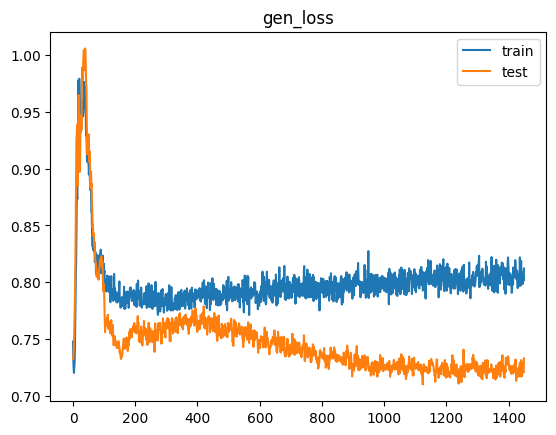

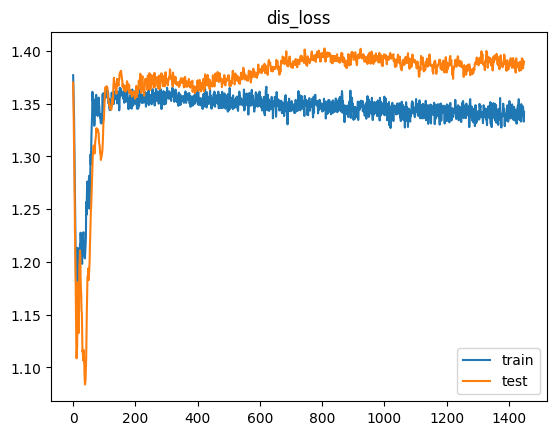

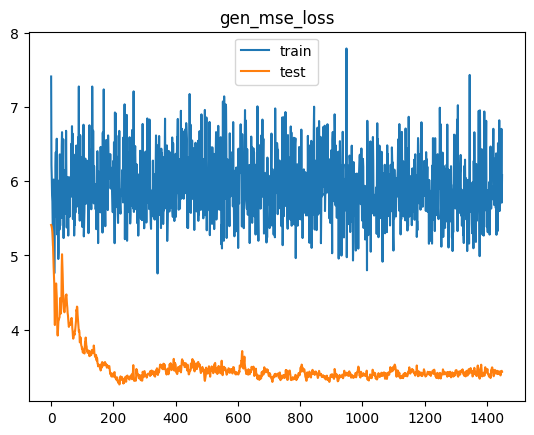

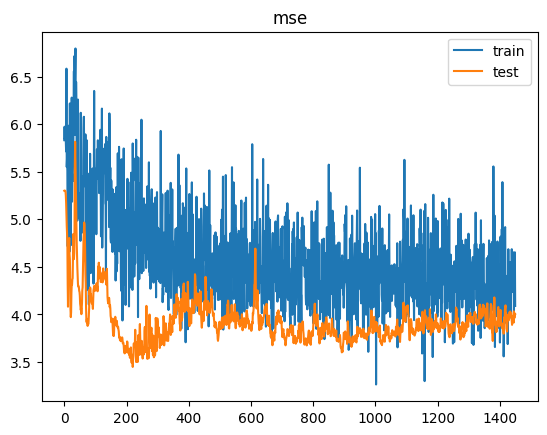

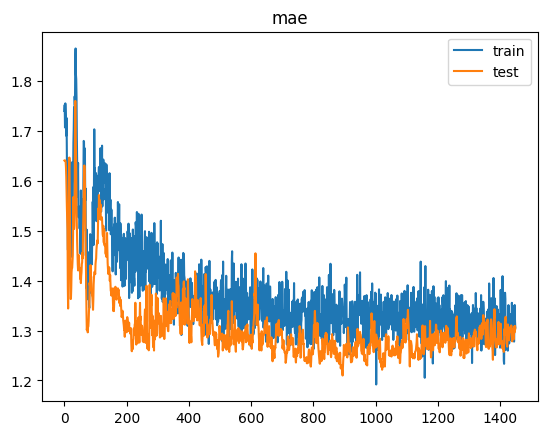

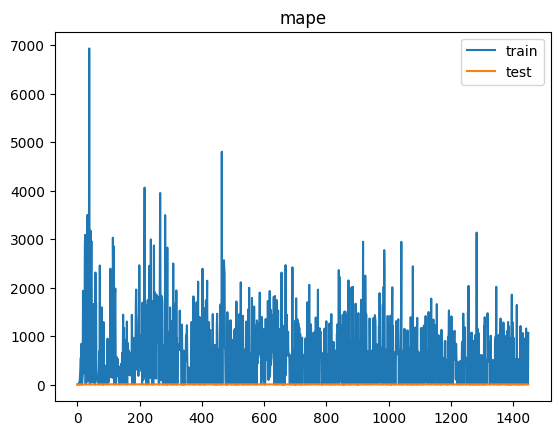

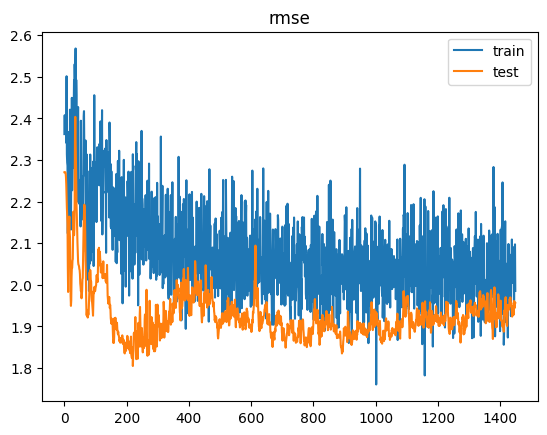

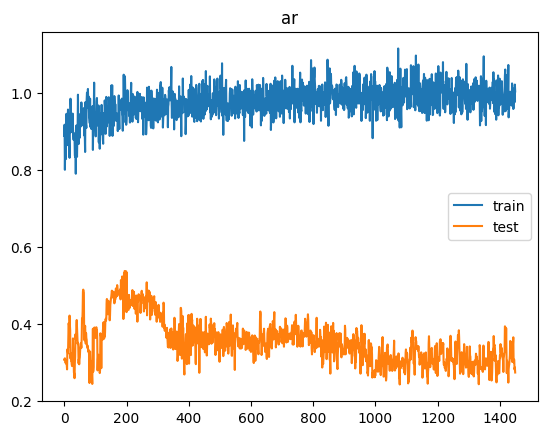

2/2 [==============================] - 1s 5ms/step


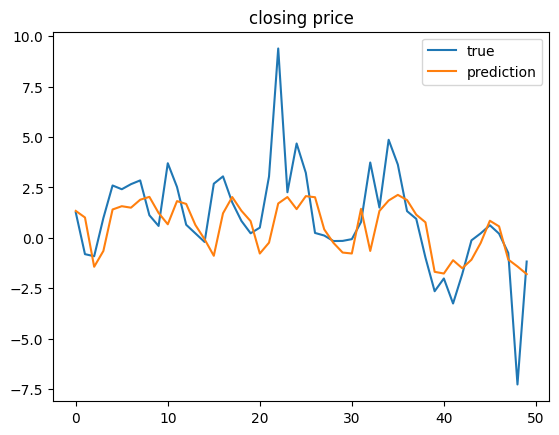

[MSE Baseline] train: 4.613299257896677  test: 3.676888532616932
Delta time with epochs = 1450: 0:16:32.571955


In [20]:
for epochs in [1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_18 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_45 (Dropout)        (None, 5, 20)             0         
                                                                 
 bidirectional_19 (Bidirecti  (None, 20)               2480

Time for epoch 52 is 0.6975953578948975 sec Generator Loss: 0.8524206280708313,  Discriminator_loss: 1.3057419061660767
Time for epoch 53 is 0.7381269931793213 sec Generator Loss: 0.8625665903091431,  Discriminator_loss: 1.3048516511917114
Time for epoch 54 is 0.7727742195129395 sec Generator Loss: 0.8582618236541748,  Discriminator_loss: 1.3249009847640991
Time for epoch 55 is 0.7663102149963379 sec Generator Loss: 0.8627007603645325,  Discriminator_loss: 1.3083088397979736
Time for epoch 56 is 0.7130100727081299 sec Generator Loss: 0.8586046695709229,  Discriminator_loss: 1.3192498683929443
Time for epoch 57 is 0.7121295928955078 sec Generator Loss: 0.8320446610450745,  Discriminator_loss: 1.3362314701080322
Time for epoch 58 is 0.7141635417938232 sec Generator Loss: 0.8442372679710388,  Discriminator_loss: 1.3216273784637451
Time for epoch 59 is 0.7050585746765137 sec Generator Loss: 0.8530488014221191,  Discriminator_loss: 1.3134078979492188
Time for epoch 60 is 0.7263057231903076 

Time for epoch 121 is 0.7021903991699219 sec Generator Loss: 0.8028461933135986,  Discriminator_loss: 1.351056456565857
Time for epoch 122 is 0.6937804222106934 sec Generator Loss: 0.8022680878639221,  Discriminator_loss: 1.346531867980957
Time for epoch 123 is 0.7132997512817383 sec Generator Loss: 0.7911486625671387,  Discriminator_loss: 1.360670804977417
Time for epoch 124 is 0.680858850479126 sec Generator Loss: 0.7994539737701416,  Discriminator_loss: 1.3570481538772583
Time for epoch 125 is 0.7080490589141846 sec Generator Loss: 0.7923659086227417,  Discriminator_loss: 1.348230242729187
Time for epoch 126 is 0.6913492679595947 sec Generator Loss: 0.8058761358261108,  Discriminator_loss: 1.3439007997512817
Time for epoch 127 is 0.711198091506958 sec Generator Loss: 0.805005669593811,  Discriminator_loss: 1.3445156812667847
Time for epoch 128 is 0.7305662631988525 sec Generator Loss: 0.7997186183929443,  Discriminator_loss: 1.3503785133361816
Time for epoch 129 is 0.814183235168457

Time for epoch 189 is 0.6765575408935547 sec Generator Loss: 0.7950707077980042,  Discriminator_loss: 1.3484179973602295
Time for epoch 190 is 0.711165189743042 sec Generator Loss: 0.7960479855537415,  Discriminator_loss: 1.3555086851119995
Time for epoch 191 is 0.7216081619262695 sec Generator Loss: 0.792704701423645,  Discriminator_loss: 1.3604074716567993
Time for epoch 192 is 0.6911540031433105 sec Generator Loss: 0.7782120704650879,  Discriminator_loss: 1.3622753620147705
Time for epoch 193 is 0.696211576461792 sec Generator Loss: 0.7884207963943481,  Discriminator_loss: 1.3506345748901367
Time for epoch 194 is 0.7294912338256836 sec Generator Loss: 0.7874451279640198,  Discriminator_loss: 1.3511162996292114
Time for epoch 195 is 0.674983024597168 sec Generator Loss: 0.7838172912597656,  Discriminator_loss: 1.3609609603881836
Time for epoch 196 is 0.7088925838470459 sec Generator Loss: 0.7865901589393616,  Discriminator_loss: 1.3530092239379883
Time for epoch 197 is 0.687172889709

Time for epoch 257 is 0.7616124153137207 sec Generator Loss: 0.7778336405754089,  Discriminator_loss: 1.3626341819763184
Time for epoch 258 is 0.8297290802001953 sec Generator Loss: 0.7807856798171997,  Discriminator_loss: 1.358540415763855
Time for epoch 259 is 0.7730522155761719 sec Generator Loss: 0.7741721272468567,  Discriminator_loss: 1.364275574684143
Time for epoch 260 is 0.8348581790924072 sec Generator Loss: 0.7797790765762329,  Discriminator_loss: 1.3612900972366333
Time for epoch 261 is 0.7570042610168457 sec Generator Loss: 0.7788021564483643,  Discriminator_loss: 1.359722375869751
Time for epoch 262 is 0.7608723640441895 sec Generator Loss: 0.7810090184211731,  Discriminator_loss: 1.3579521179199219
Time for epoch 263 is 0.7882282733917236 sec Generator Loss: 0.782882809638977,  Discriminator_loss: 1.3620715141296387
Time for epoch 264 is 0.7782347202301025 sec Generator Loss: 0.7837136387825012,  Discriminator_loss: 1.363474726676941
Time for epoch 265 is 0.7377369403839

Time for epoch 326 is 0.7396190166473389 sec Generator Loss: 0.7923890352249146,  Discriminator_loss: 1.3539021015167236
Time for epoch 327 is 0.6937723159790039 sec Generator Loss: 0.7931926846504211,  Discriminator_loss: 1.358810305595398
Time for epoch 328 is 0.7320375442504883 sec Generator Loss: 0.7784804105758667,  Discriminator_loss: 1.36226224899292
Time for epoch 329 is 0.6896770000457764 sec Generator Loss: 0.7813769578933716,  Discriminator_loss: 1.3619147539138794
Time for epoch 330 is 0.7736754417419434 sec Generator Loss: 0.7812396287918091,  Discriminator_loss: 1.3573776483535767
Time for epoch 331 is 0.7561972141265869 sec Generator Loss: 0.781773567199707,  Discriminator_loss: 1.3614345788955688
Time for epoch 332 is 0.7932393550872803 sec Generator Loss: 0.7758291959762573,  Discriminator_loss: 1.3616204261779785
Time for epoch 333 is 0.7512450218200684 sec Generator Loss: 0.7791474461555481,  Discriminator_loss: 1.3618712425231934
Time for epoch 334 is 0.755831480026

Time for epoch 394 is 0.793720006942749 sec Generator Loss: 0.7926595211029053,  Discriminator_loss: 1.3549778461456299
Time for epoch 395 is 0.714209794998169 sec Generator Loss: 0.7816017270088196,  Discriminator_loss: 1.3602943420410156
Time for epoch 396 is 0.7157759666442871 sec Generator Loss: 0.7827301621437073,  Discriminator_loss: 1.3626084327697754
Time for epoch 397 is 0.7601618766784668 sec Generator Loss: 0.789534330368042,  Discriminator_loss: 1.3605923652648926
Time for epoch 398 is 0.698270320892334 sec Generator Loss: 0.7906540632247925,  Discriminator_loss: 1.3585432767868042
Time for epoch 399 is 0.7372579574584961 sec Generator Loss: 0.7931022047996521,  Discriminator_loss: 1.3561911582946777
Time for epoch 400 is 0.7183117866516113 sec Generator Loss: 0.7866780161857605,  Discriminator_loss: 1.3544450998306274
Time for epoch 401 is 0.6865158081054688 sec Generator Loss: 0.778112530708313,  Discriminator_loss: 1.35648512840271
Time for epoch 402 is 0.693481683731079

Time for epoch 463 is 0.6856958866119385 sec Generator Loss: 0.7821578979492188,  Discriminator_loss: 1.3576282262802124
Time for epoch 464 is 0.7067172527313232 sec Generator Loss: 0.7996272444725037,  Discriminator_loss: 1.3506675958633423
Time for epoch 465 is 0.7473704814910889 sec Generator Loss: 0.7881041765213013,  Discriminator_loss: 1.361799955368042
Time for epoch 466 is 0.7280292510986328 sec Generator Loss: 0.7896391153335571,  Discriminator_loss: 1.359850525856018
Time for epoch 467 is 0.7572848796844482 sec Generator Loss: 0.7931036949157715,  Discriminator_loss: 1.3510911464691162
Time for epoch 468 is 0.7506515979766846 sec Generator Loss: 0.7924703359603882,  Discriminator_loss: 1.355878233909607
Time for epoch 469 is 0.7234995365142822 sec Generator Loss: 0.7865775227546692,  Discriminator_loss: 1.362497329711914
Time for epoch 470 is 0.7332005500793457 sec Generator Loss: 0.792493462562561,  Discriminator_loss: 1.3492376804351807
Time for epoch 471 is 0.7005405426025

Time for epoch 531 is 0.7458531856536865 sec Generator Loss: 0.7835568189620972,  Discriminator_loss: 1.3546303510665894
Time for epoch 532 is 0.8001799583435059 sec Generator Loss: 0.776541531085968,  Discriminator_loss: 1.3568254709243774
Time for epoch 533 is 0.7137596607208252 sec Generator Loss: 0.786890983581543,  Discriminator_loss: 1.3522841930389404
Time for epoch 534 is 0.7309365272521973 sec Generator Loss: 0.7994441390037537,  Discriminator_loss: 1.3501728773117065
Time for epoch 535 is 0.7481803894042969 sec Generator Loss: 0.7941920161247253,  Discriminator_loss: 1.3497902154922485
Time for epoch 536 is 0.7082126140594482 sec Generator Loss: 0.7857582569122314,  Discriminator_loss: 1.3607102632522583
Time for epoch 537 is 0.7419345378875732 sec Generator Loss: 0.7879836559295654,  Discriminator_loss: 1.3566421270370483
Time for epoch 538 is 0.7249729633331299 sec Generator Loss: 0.7940942645072937,  Discriminator_loss: 1.3527109622955322
Time for epoch 539 is 0.7660896778

Time for epoch 599 is 0.7394411563873291 sec Generator Loss: 0.7886815667152405,  Discriminator_loss: 1.3601179122924805
Time for epoch 600 is 0.787179708480835 sec Generator Loss: 0.7914983630180359,  Discriminator_loss: 1.3466700315475464
Time for epoch 601 is 0.7430517673492432 sec Generator Loss: 0.7851323485374451,  Discriminator_loss: 1.3561025857925415
Time for epoch 602 is 0.7269296646118164 sec Generator Loss: 0.7977405786514282,  Discriminator_loss: 1.3541619777679443
Time for epoch 603 is 0.7005460262298584 sec Generator Loss: 0.7995137572288513,  Discriminator_loss: 1.3470737934112549
Time for epoch 604 is 0.7128982543945312 sec Generator Loss: 0.7992855906486511,  Discriminator_loss: 1.3564567565917969
Time for epoch 605 is 0.7140069007873535 sec Generator Loss: 0.7966986298561096,  Discriminator_loss: 1.3452855348587036
Time for epoch 606 is 0.7552914619445801 sec Generator Loss: 0.786457359790802,  Discriminator_loss: 1.3568878173828125
Time for epoch 607 is 0.7441158294

Time for epoch 668 is 1.3444137573242188 sec Generator Loss: 0.7942361235618591,  Discriminator_loss: 1.3499743938446045
Time for epoch 669 is 1.1054024696350098 sec Generator Loss: 0.7969852685928345,  Discriminator_loss: 1.3438783884048462
Time for epoch 670 is 1.1551446914672852 sec Generator Loss: 0.7997333407402039,  Discriminator_loss: 1.3475247621536255
Time for epoch 671 is 0.9301412105560303 sec Generator Loss: 0.793545126914978,  Discriminator_loss: 1.3476194143295288
Time for epoch 672 is 0.9943692684173584 sec Generator Loss: 0.7908223867416382,  Discriminator_loss: 1.3487250804901123
Time for epoch 673 is 1.2165131568908691 sec Generator Loss: 0.7971659898757935,  Discriminator_loss: 1.3495252132415771
Time for epoch 674 is 1.0112419128417969 sec Generator Loss: 0.7953900694847107,  Discriminator_loss: 1.3533915281295776
Time for epoch 675 is 1.0337145328521729 sec Generator Loss: 0.7926977276802063,  Discriminator_loss: 1.356374979019165
Time for epoch 676 is 0.9922058582

Time for epoch 737 is 1.0104608535766602 sec Generator Loss: 0.796014130115509,  Discriminator_loss: 1.3528062105178833
Time for epoch 738 is 1.0581233501434326 sec Generator Loss: 0.7954675555229187,  Discriminator_loss: 1.344895362854004
Time for epoch 739 is 1.0064866542816162 sec Generator Loss: 0.8043131828308105,  Discriminator_loss: 1.3428139686584473
Time for epoch 740 is 0.9340136051177979 sec Generator Loss: 0.7990603446960449,  Discriminator_loss: 1.3486946821212769
Time for epoch 741 is 0.8947370052337646 sec Generator Loss: 0.7912483811378479,  Discriminator_loss: 1.351347804069519
Time for epoch 742 is 0.8295159339904785 sec Generator Loss: 0.7927504777908325,  Discriminator_loss: 1.3534780740737915
Time for epoch 743 is 0.8303046226501465 sec Generator Loss: 0.807893693447113,  Discriminator_loss: 1.3385899066925049
Time for epoch 744 is 0.8017261028289795 sec Generator Loss: 0.7994144558906555,  Discriminator_loss: 1.351812720298767
Time for epoch 745 is 0.8594524860382

Time for epoch 806 is 0.7712910175323486 sec Generator Loss: 0.7979450225830078,  Discriminator_loss: 1.342408299446106
Time for epoch 807 is 0.7896542549133301 sec Generator Loss: 0.7984186410903931,  Discriminator_loss: 1.3483550548553467
Time for epoch 808 is 0.739793062210083 sec Generator Loss: 0.7960284948348999,  Discriminator_loss: 1.3439688682556152
Time for epoch 809 is 0.7550766468048096 sec Generator Loss: 0.8215120434761047,  Discriminator_loss: 1.3313847780227661
Time for epoch 810 is 0.7695114612579346 sec Generator Loss: 0.799703061580658,  Discriminator_loss: 1.344470500946045
Time for epoch 811 is 0.7796726226806641 sec Generator Loss: 0.8017691373825073,  Discriminator_loss: 1.3433310985565186
Time for epoch 812 is 0.8193035125732422 sec Generator Loss: 0.7979438900947571,  Discriminator_loss: 1.3535196781158447
Time for epoch 813 is 0.7358348369598389 sec Generator Loss: 0.7940711975097656,  Discriminator_loss: 1.3460848331451416
Time for epoch 814 is 0.757353305816

Time for epoch 874 is 0.7983038425445557 sec Generator Loss: 0.7915782928466797,  Discriminator_loss: 1.3520381450653076
Time for epoch 875 is 0.884171724319458 sec Generator Loss: 0.8101203441619873,  Discriminator_loss: 1.3404583930969238
Time for epoch 876 is 0.8450672626495361 sec Generator Loss: 0.7988300919532776,  Discriminator_loss: 1.3389134407043457
Time for epoch 877 is 0.7714650630950928 sec Generator Loss: 0.7985495328903198,  Discriminator_loss: 1.3486790657043457
Time for epoch 878 is 0.7140562534332275 sec Generator Loss: 0.7989005446434021,  Discriminator_loss: 1.3523001670837402
Time for epoch 879 is 0.7219820022583008 sec Generator Loss: 0.8014631867408752,  Discriminator_loss: 1.3438453674316406
Time for epoch 880 is 0.7325716018676758 sec Generator Loss: 0.7999181747436523,  Discriminator_loss: 1.3469775915145874
Time for epoch 881 is 0.7539629936218262 sec Generator Loss: 0.8070098161697388,  Discriminator_loss: 1.3447082042694092
Time for epoch 882 is 0.724538087

Time for epoch 942 is 0.8086493015289307 sec Generator Loss: 0.8016455769538879,  Discriminator_loss: 1.3426783084869385
Time for epoch 943 is 0.8511350154876709 sec Generator Loss: 0.8008733987808228,  Discriminator_loss: 1.3497031927108765
Time for epoch 944 is 0.8169946670532227 sec Generator Loss: 0.7968055009841919,  Discriminator_loss: 1.3473838567733765
Time for epoch 945 is 0.8449006080627441 sec Generator Loss: 0.8024734258651733,  Discriminator_loss: 1.3445402383804321
Time for epoch 946 is 0.9471290111541748 sec Generator Loss: 0.8009280562400818,  Discriminator_loss: 1.343575119972229
Time for epoch 947 is 0.9673342704772949 sec Generator Loss: 0.8032631278038025,  Discriminator_loss: 1.3317365646362305
Time for epoch 948 is 0.8671579360961914 sec Generator Loss: 0.7995045185089111,  Discriminator_loss: 1.3401193618774414
Time for epoch 949 is 0.8068892955780029 sec Generator Loss: 0.8081256151199341,  Discriminator_loss: 1.3471730947494507
Time for epoch 950 is 0.766839265

Time for epoch 1010 is 0.8755989074707031 sec Generator Loss: 0.823553204536438,  Discriminator_loss: 1.334010124206543
Time for epoch 1011 is 0.7968149185180664 sec Generator Loss: 0.807533323764801,  Discriminator_loss: 1.346089482307434
Time for epoch 1012 is 0.7976624965667725 sec Generator Loss: 0.7941901683807373,  Discriminator_loss: 1.3592687845230103
Time for epoch 1013 is 0.7835099697113037 sec Generator Loss: 0.8106266260147095,  Discriminator_loss: 1.3321114778518677
Time for epoch 1014 is 0.7678146362304688 sec Generator Loss: 0.8109424710273743,  Discriminator_loss: 1.3384010791778564
Time for epoch 1015 is 0.8102526664733887 sec Generator Loss: 0.7928596138954163,  Discriminator_loss: 1.3440265655517578
Time for epoch 1016 is 0.7861404418945312 sec Generator Loss: 0.7967782020568848,  Discriminator_loss: 1.3493614196777344
Time for epoch 1017 is 0.8488585948944092 sec Generator Loss: 0.8044869303703308,  Discriminator_loss: 1.3462603092193604
Time for epoch 1018 is 0.775

Time for epoch 1078 is 0.7583239078521729 sec Generator Loss: 0.803911030292511,  Discriminator_loss: 1.336644172668457
Time for epoch 1079 is 0.7693569660186768 sec Generator Loss: 0.8047838807106018,  Discriminator_loss: 1.3436423540115356
Time for epoch 1080 is 0.9917173385620117 sec Generator Loss: 0.8107549548149109,  Discriminator_loss: 1.337692379951477
Time for epoch 1081 is 0.9908311367034912 sec Generator Loss: 0.8142393231391907,  Discriminator_loss: 1.3369046449661255
Time for epoch 1082 is 1.0572550296783447 sec Generator Loss: 0.7972695231437683,  Discriminator_loss: 1.355814814567566
Time for epoch 1083 is 0.8566479682922363 sec Generator Loss: 0.8128719329833984,  Discriminator_loss: 1.33612859249115
Time for epoch 1084 is 0.836550235748291 sec Generator Loss: 0.8084701895713806,  Discriminator_loss: 1.351266622543335
Time for epoch 1085 is 0.8706846237182617 sec Generator Loss: 0.8141186833381653,  Discriminator_loss: 1.344321846961975
Time for epoch 1086 is 0.88953042

Time for epoch 1146 is 0.8874578475952148 sec Generator Loss: 0.8184539079666138,  Discriminator_loss: 1.337947964668274
Time for epoch 1147 is 0.9623894691467285 sec Generator Loss: 0.8141120672225952,  Discriminator_loss: 1.3308302164077759
Time for epoch 1148 is 0.9607992172241211 sec Generator Loss: 0.8121094703674316,  Discriminator_loss: 1.3371049165725708
Time for epoch 1149 is 0.7716093063354492 sec Generator Loss: 0.8092162609100342,  Discriminator_loss: 1.343032956123352
Time for epoch 1150 is 0.7946021556854248 sec Generator Loss: 0.8064841628074646,  Discriminator_loss: 1.3326236009597778
Time for epoch 1151 is 0.8441407680511475 sec Generator Loss: 0.8074743151664734,  Discriminator_loss: 1.342103123664856
Time for epoch 1152 is 1.102001667022705 sec Generator Loss: 0.827521562576294,  Discriminator_loss: 1.3284534215927124
Time for epoch 1153 is 1.1955738067626953 sec Generator Loss: 0.8054951429367065,  Discriminator_loss: 1.3468115329742432
Time for epoch 1154 is 0.8904

Time for epoch 1214 is 0.8003103733062744 sec Generator Loss: 0.8119271993637085,  Discriminator_loss: 1.342897891998291
Time for epoch 1215 is 0.7971994876861572 sec Generator Loss: 0.8055853843688965,  Discriminator_loss: 1.3375667333602905
Time for epoch 1216 is 0.7779557704925537 sec Generator Loss: 0.7977641224861145,  Discriminator_loss: 1.3479864597320557
Time for epoch 1217 is 0.8317375183105469 sec Generator Loss: 0.8081204891204834,  Discriminator_loss: 1.3415720462799072
Time for epoch 1218 is 0.7759532928466797 sec Generator Loss: 0.7966707944869995,  Discriminator_loss: 1.3458771705627441
Time for epoch 1219 is 0.8187541961669922 sec Generator Loss: 0.8112988471984863,  Discriminator_loss: 1.3376871347427368
Time for epoch 1220 is 0.7877728939056396 sec Generator Loss: 0.8111069202423096,  Discriminator_loss: 1.3373457193374634
Time for epoch 1221 is 0.7908327579498291 sec Generator Loss: 0.817833423614502,  Discriminator_loss: 1.334533452987671
Time for epoch 1222 is 0.77

Time for epoch 1282 is 0.8010928630828857 sec Generator Loss: 0.8069975972175598,  Discriminator_loss: 1.3376272916793823
Time for epoch 1283 is 0.8059549331665039 sec Generator Loss: 0.8075850605964661,  Discriminator_loss: 1.334011197090149
Time for epoch 1284 is 0.8060858249664307 sec Generator Loss: 0.8104495406150818,  Discriminator_loss: 1.328405737876892
Time for epoch 1285 is 0.7630271911621094 sec Generator Loss: 0.8123994469642639,  Discriminator_loss: 1.344896674156189
Time for epoch 1286 is 0.7701930999755859 sec Generator Loss: 0.8147529363632202,  Discriminator_loss: 1.3330610990524292
Time for epoch 1287 is 0.7427570819854736 sec Generator Loss: 0.8100115060806274,  Discriminator_loss: 1.3485344648361206
Time for epoch 1288 is 0.8050260543823242 sec Generator Loss: 0.8037170171737671,  Discriminator_loss: 1.3433183431625366
Time for epoch 1289 is 0.8851630687713623 sec Generator Loss: 0.8038395643234253,  Discriminator_loss: 1.3395646810531616
Time for epoch 1290 is 0.80

Time for epoch 1350 is 0.8345980644226074 sec Generator Loss: 0.8077948689460754,  Discriminator_loss: 1.3382441997528076
Time for epoch 1351 is 0.8031346797943115 sec Generator Loss: 0.8166764974594116,  Discriminator_loss: 1.3310092687606812
Time for epoch 1352 is 0.8389549255371094 sec Generator Loss: 0.8198162317276001,  Discriminator_loss: 1.3426640033721924
Time for epoch 1353 is 0.8432011604309082 sec Generator Loss: 0.8056469559669495,  Discriminator_loss: 1.3442353010177612
Time for epoch 1354 is 0.8094677925109863 sec Generator Loss: 0.8141735196113586,  Discriminator_loss: 1.338638186454773
Time for epoch 1355 is 0.7764582633972168 sec Generator Loss: 0.8151233792304993,  Discriminator_loss: 1.3303765058517456
Time for epoch 1356 is 0.8014540672302246 sec Generator Loss: 0.8040778040885925,  Discriminator_loss: 1.3387622833251953
Time for epoch 1357 is 0.8930346965789795 sec Generator Loss: 0.8047415018081665,  Discriminator_loss: 1.34518563747406
Time for epoch 1358 is 0.93

Time for epoch 1418 is 0.8121128082275391 sec Generator Loss: 0.810206949710846,  Discriminator_loss: 1.3358755111694336
Time for epoch 1419 is 0.8458223342895508 sec Generator Loss: 0.8152329325675964,  Discriminator_loss: 1.3360579013824463
Time for epoch 1420 is 0.8188574314117432 sec Generator Loss: 0.8097421526908875,  Discriminator_loss: 1.3407644033432007
Time for epoch 1421 is 0.7910890579223633 sec Generator Loss: 0.8081048130989075,  Discriminator_loss: 1.3402518033981323
Time for epoch 1422 is 0.8127787113189697 sec Generator Loss: 0.8028171062469482,  Discriminator_loss: 1.3481112718582153
Time for epoch 1423 is 0.8080480098724365 sec Generator Loss: 0.7995766401290894,  Discriminator_loss: 1.3427706956863403
Time for epoch 1424 is 0.848942756652832 sec Generator Loss: 0.817741334438324,  Discriminator_loss: 1.3371449708938599
Time for epoch 1425 is 0.8667764663696289 sec Generator Loss: 0.7968959808349609,  Discriminator_loss: 1.3462163209915161
Time for epoch 1426 is 0.78

Time for epoch 1486 is 0.7776384353637695 sec Generator Loss: 0.8145329356193542,  Discriminator_loss: 1.3404574394226074
Time for epoch 1487 is 0.7582838535308838 sec Generator Loss: 0.7966058254241943,  Discriminator_loss: 1.3464844226837158
Time for epoch 1488 is 0.7820401191711426 sec Generator Loss: 0.8129434585571289,  Discriminator_loss: 1.3404821157455444
Time for epoch 1489 is 0.7997381687164307 sec Generator Loss: 0.8140135407447815,  Discriminator_loss: 1.334646463394165
Time for epoch 1490 is 0.8196702003479004 sec Generator Loss: 0.8042461276054382,  Discriminator_loss: 1.3400925397872925
Time for epoch 1491 is 0.7703135013580322 sec Generator Loss: 0.8196333050727844,  Discriminator_loss: 1.3267245292663574
Time for epoch 1492 is 0.8353960514068604 sec Generator Loss: 0.8148297071456909,  Discriminator_loss: 1.3348815441131592
Time for epoch 1493 is 0.8047211170196533 sec Generator Loss: 0.8104709982872009,  Discriminator_loss: 1.3336673974990845
Time for epoch 1494 is 0.

Time for epoch 1554 is 0.8801062107086182 sec Generator Loss: 0.8126063942909241,  Discriminator_loss: 1.345442771911621
Time for epoch 1555 is 0.8167743682861328 sec Generator Loss: 0.8105709552764893,  Discriminator_loss: 1.3343002796173096
Time for epoch 1556 is 0.8643169403076172 sec Generator Loss: 0.807726263999939,  Discriminator_loss: 1.3463205099105835
Time for epoch 1557 is 0.8888757228851318 sec Generator Loss: 0.8146643042564392,  Discriminator_loss: 1.332672119140625
Time for epoch 1558 is 0.8403589725494385 sec Generator Loss: 0.8068332076072693,  Discriminator_loss: 1.33734929561615
Time for epoch 1559 is 0.8592164516448975 sec Generator Loss: 0.8052347302436829,  Discriminator_loss: 1.3416119813919067
Time for epoch 1560 is 0.7948126792907715 sec Generator Loss: 0.8120701313018799,  Discriminator_loss: 1.3408660888671875
Time for epoch 1561 is 0.9056529998779297 sec Generator Loss: 0.8168442249298096,  Discriminator_loss: 1.3430386781692505
Time for epoch 1562 is 0.8710

Time for epoch 1622 is 0.9601850509643555 sec Generator Loss: 0.8037012219429016,  Discriminator_loss: 1.3437999486923218
Time for epoch 1623 is 0.9777786731719971 sec Generator Loss: 0.808577835559845,  Discriminator_loss: 1.3319634199142456
Time for epoch 1624 is 0.8305599689483643 sec Generator Loss: 0.8091146349906921,  Discriminator_loss: 1.3451440334320068
Time for epoch 1625 is 0.8611235618591309 sec Generator Loss: 0.8053301572799683,  Discriminator_loss: 1.3451560735702515
Time for epoch 1626 is 0.8186748027801514 sec Generator Loss: 0.8099048733711243,  Discriminator_loss: 1.3387161493301392
Time for epoch 1627 is 0.8952417373657227 sec Generator Loss: 0.8072899580001831,  Discriminator_loss: 1.3382264375686646
Time for epoch 1628 is 0.8430562019348145 sec Generator Loss: 0.804824948310852,  Discriminator_loss: 1.339264154434204
Time for epoch 1629 is 0.9340271949768066 sec Generator Loss: 0.8119590282440186,  Discriminator_loss: 1.329484462738037
Time for epoch 1630 is 0.934

Time for epoch 1690 is 0.9730486869812012 sec Generator Loss: 0.8021349906921387,  Discriminator_loss: 1.3409323692321777
Time for epoch 1691 is 0.8822495937347412 sec Generator Loss: 0.8031603097915649,  Discriminator_loss: 1.3469351530075073
Time for epoch 1692 is 0.9031345844268799 sec Generator Loss: 0.8159162402153015,  Discriminator_loss: 1.3413336277008057
Time for epoch 1693 is 0.8818936347961426 sec Generator Loss: 0.8159953355789185,  Discriminator_loss: 1.3297537565231323
Time for epoch 1694 is 0.9019379615783691 sec Generator Loss: 0.8147557377815247,  Discriminator_loss: 1.343596339225769
Time for epoch 1695 is 0.8346614837646484 sec Generator Loss: 0.8187086582183838,  Discriminator_loss: 1.3353716135025024
Time for epoch 1696 is 1.0170214176177979 sec Generator Loss: 0.8089593648910522,  Discriminator_loss: 1.3346203565597534
Time for epoch 1697 is 0.9535830020904541 sec Generator Loss: 0.8120207786560059,  Discriminator_loss: 1.340620517730713
Time for epoch 1698 is 0.8

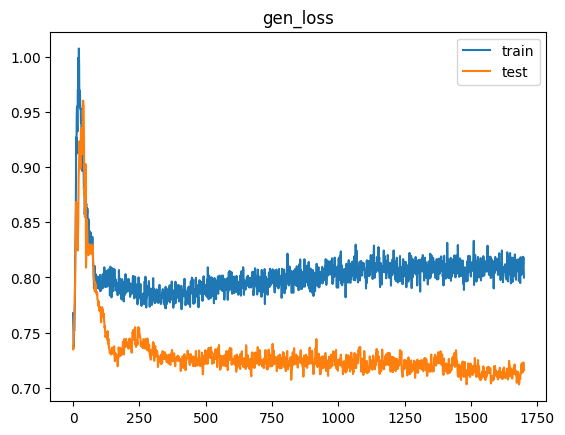

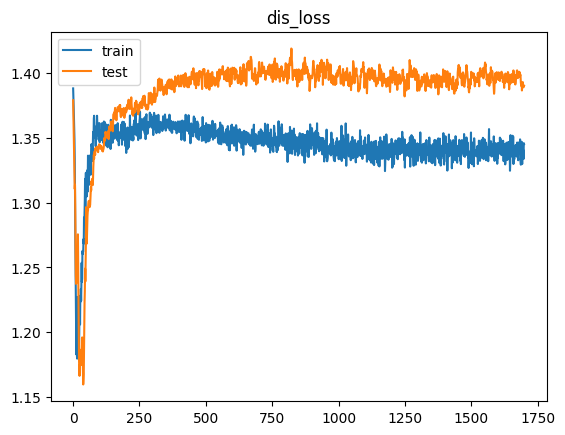

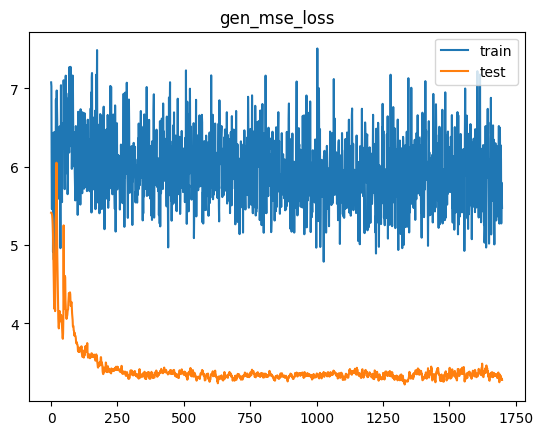

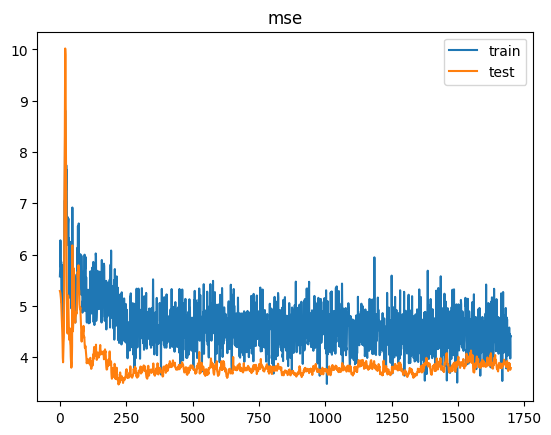

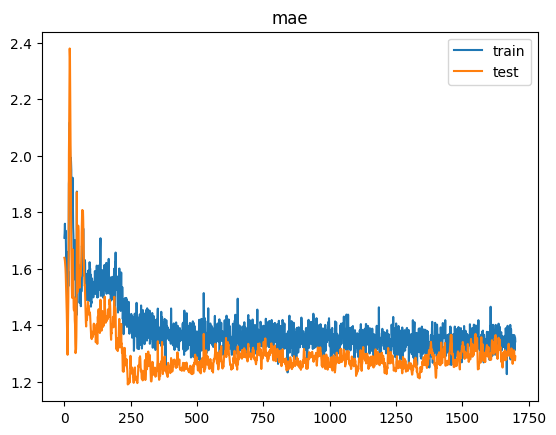

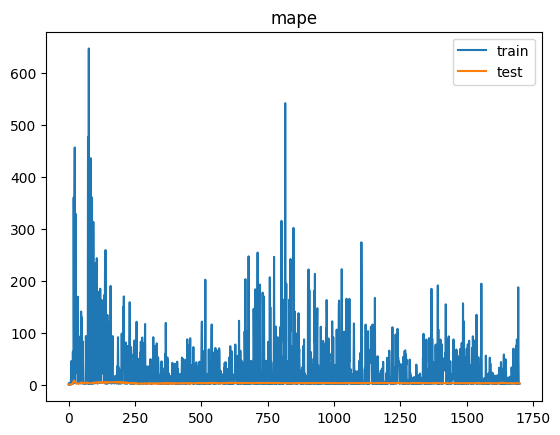

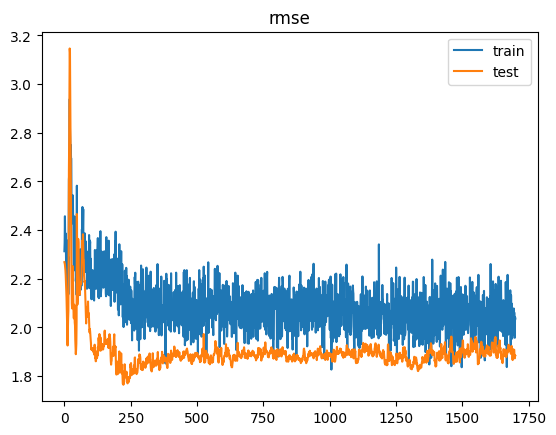

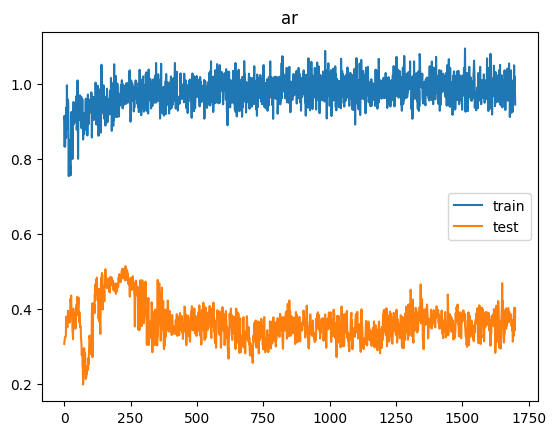

2/2 [==============================] - 1s 6ms/step


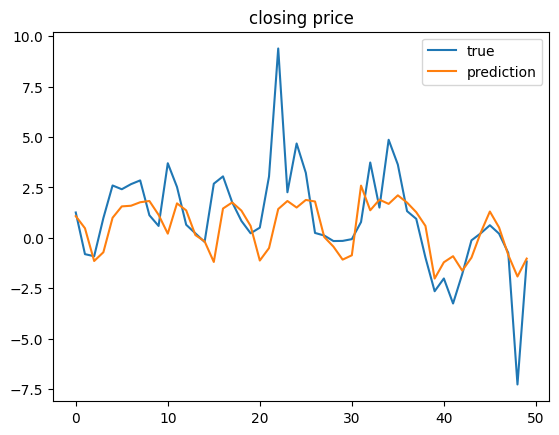

[MSE Baseline] train: 4.200271938673041  test: 3.676888532616932
Delta time with epochs = 1700: 0:23:14.871751
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_20 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_50 (Dropout)        (None, 5, 20)             0         
             

Time for epoch 51 is 0.994206428527832 sec Generator Loss: 0.8920758366584778,  Discriminator_loss: 1.2810654640197754
Time for epoch 52 is 0.9873394966125488 sec Generator Loss: 0.9029994010925293,  Discriminator_loss: 1.2761591672897339
Time for epoch 53 is 1.1911289691925049 sec Generator Loss: 0.8902682065963745,  Discriminator_loss: 1.282578706741333
Time for epoch 54 is 1.00142240524292 sec Generator Loss: 0.8938408493995667,  Discriminator_loss: 1.273474931716919
Time for epoch 55 is 0.937140941619873 sec Generator Loss: 0.8921871185302734,  Discriminator_loss: 1.2802000045776367
Time for epoch 56 is 0.8698322772979736 sec Generator Loss: 0.8729581236839294,  Discriminator_loss: 1.2914552688598633
Time for epoch 57 is 0.985914945602417 sec Generator Loss: 0.8781423568725586,  Discriminator_loss: 1.2817509174346924
Time for epoch 58 is 0.9085638523101807 sec Generator Loss: 0.8720384836196899,  Discriminator_loss: 1.2962572574615479
Time for epoch 59 is 1.0864834785461426 sec Gen

Time for epoch 120 is 0.8652403354644775 sec Generator Loss: 0.7847844958305359,  Discriminator_loss: 1.359431266784668
Time for epoch 121 is 0.9907517433166504 sec Generator Loss: 0.7885269522666931,  Discriminator_loss: 1.3646222352981567
Time for epoch 122 is 0.8290603160858154 sec Generator Loss: 0.7904965281486511,  Discriminator_loss: 1.3648568391799927
Time for epoch 123 is 0.8204367160797119 sec Generator Loss: 0.788180410861969,  Discriminator_loss: 1.3642382621765137
Time for epoch 124 is 0.8912057876586914 sec Generator Loss: 0.7925501465797424,  Discriminator_loss: 1.3590611219406128
Time for epoch 125 is 0.8027019500732422 sec Generator Loss: 0.7900113463401794,  Discriminator_loss: 1.3604888916015625
Time for epoch 126 is 0.8614423274993896 sec Generator Loss: 0.7832770943641663,  Discriminator_loss: 1.3641518354415894
Time for epoch 127 is 0.8313965797424316 sec Generator Loss: 0.7939777374267578,  Discriminator_loss: 1.3561311960220337
Time for epoch 128 is 0.7735302448

Time for epoch 188 is 0.8765249252319336 sec Generator Loss: 0.7871237397193909,  Discriminator_loss: 1.3554457426071167
Time for epoch 189 is 0.8589274883270264 sec Generator Loss: 0.7922501564025879,  Discriminator_loss: 1.358520746231079
Time for epoch 190 is 0.8573975563049316 sec Generator Loss: 0.8005003929138184,  Discriminator_loss: 1.3463395833969116
Time for epoch 191 is 0.8539538383483887 sec Generator Loss: 0.7914212346076965,  Discriminator_loss: 1.3505257368087769
Time for epoch 192 is 0.8745343685150146 sec Generator Loss: 0.7911016941070557,  Discriminator_loss: 1.3522982597351074
Time for epoch 193 is 0.8914003372192383 sec Generator Loss: 0.7837636470794678,  Discriminator_loss: 1.357251524925232
Time for epoch 194 is 0.927253246307373 sec Generator Loss: 0.7874056696891785,  Discriminator_loss: 1.3515673875808716
Time for epoch 195 is 0.989703893661499 sec Generator Loss: 0.7811170816421509,  Discriminator_loss: 1.35349440574646
Time for epoch 196 is 0.95350599288940

Time for epoch 257 is 0.9188618659973145 sec Generator Loss: 0.7781718373298645,  Discriminator_loss: 1.3606783151626587
Time for epoch 258 is 0.9038162231445312 sec Generator Loss: 0.7865013480186462,  Discriminator_loss: 1.3538709878921509
Time for epoch 259 is 0.8256418704986572 sec Generator Loss: 0.7803696393966675,  Discriminator_loss: 1.3546743392944336
Time for epoch 260 is 0.8284115791320801 sec Generator Loss: 0.7925073504447937,  Discriminator_loss: 1.3516137599945068
Time for epoch 261 is 0.9250521659851074 sec Generator Loss: 0.7990497946739197,  Discriminator_loss: 1.354996681213379
Time for epoch 262 is 1.0545032024383545 sec Generator Loss: 0.7822239398956299,  Discriminator_loss: 1.3560882806777954
Time for epoch 263 is 1.0336604118347168 sec Generator Loss: 0.7879771590232849,  Discriminator_loss: 1.3540492057800293
Time for epoch 264 is 0.8336312770843506 sec Generator Loss: 0.7831169962882996,  Discriminator_loss: 1.3567525148391724
Time for epoch 265 is 0.921769618

Time for epoch 325 is 0.8256876468658447 sec Generator Loss: 0.7770307660102844,  Discriminator_loss: 1.3596056699752808
Time for epoch 326 is 1.1736242771148682 sec Generator Loss: 0.7821245789527893,  Discriminator_loss: 1.362169861793518
Time for epoch 327 is 0.9604873657226562 sec Generator Loss: 0.7755399942398071,  Discriminator_loss: 1.3640539646148682
Time for epoch 328 is 1.0824389457702637 sec Generator Loss: 0.7859671115875244,  Discriminator_loss: 1.3544366359710693
Time for epoch 329 is 1.0337438583374023 sec Generator Loss: 0.7851573824882507,  Discriminator_loss: 1.3531794548034668
Time for epoch 330 is 1.1902661323547363 sec Generator Loss: 0.7824187874794006,  Discriminator_loss: 1.3615570068359375
Time for epoch 331 is 1.0423822402954102 sec Generator Loss: 0.7910540699958801,  Discriminator_loss: 1.3571230173110962
Time for epoch 332 is 1.0498685836791992 sec Generator Loss: 0.7759961485862732,  Discriminator_loss: 1.35818612575531
Time for epoch 333 is 1.03512620925

Time for epoch 394 is 1.0009596347808838 sec Generator Loss: 0.7807040810585022,  Discriminator_loss: 1.3602148294448853
Time for epoch 395 is 1.0367498397827148 sec Generator Loss: 0.7804169654846191,  Discriminator_loss: 1.3581204414367676
Time for epoch 396 is 1.0531980991363525 sec Generator Loss: 0.7819267511367798,  Discriminator_loss: 1.3626129627227783
Time for epoch 397 is 0.970191240310669 sec Generator Loss: 0.7840796709060669,  Discriminator_loss: 1.3573559522628784
Time for epoch 398 is 1.0006463527679443 sec Generator Loss: 0.7898414731025696,  Discriminator_loss: 1.3570892810821533
Time for epoch 399 is 1.1594114303588867 sec Generator Loss: 0.7966423630714417,  Discriminator_loss: 1.3503068685531616
Time for epoch 400 is 0.9960031509399414 sec Generator Loss: 0.7860381007194519,  Discriminator_loss: 1.3599426746368408
Time for epoch 401 is 1.005094289779663 sec Generator Loss: 0.7878168225288391,  Discriminator_loss: 1.3678313493728638
Time for epoch 402 is 0.9846456050

Time for epoch 462 is 0.8920834064483643 sec Generator Loss: 0.7920300960540771,  Discriminator_loss: 1.350499153137207
Time for epoch 463 is 0.8986172676086426 sec Generator Loss: 0.7889156937599182,  Discriminator_loss: 1.3592573404312134
Time for epoch 464 is 0.879448413848877 sec Generator Loss: 0.7967020869255066,  Discriminator_loss: 1.360275149345398
Time for epoch 465 is 0.9197330474853516 sec Generator Loss: 0.7947399020195007,  Discriminator_loss: 1.3521593809127808
Time for epoch 466 is 0.9826240539550781 sec Generator Loss: 0.8013876676559448,  Discriminator_loss: 1.3513809442520142
Time for epoch 467 is 0.8911776542663574 sec Generator Loss: 0.792018473148346,  Discriminator_loss: 1.3660197257995605
Time for epoch 468 is 0.8641858100891113 sec Generator Loss: 0.8019762635231018,  Discriminator_loss: 1.3414608240127563
Time for epoch 469 is 0.8317890167236328 sec Generator Loss: 0.7817599177360535,  Discriminator_loss: 1.3574358224868774
Time for epoch 470 is 0.879656314849

Time for epoch 530 is 1.0198347568511963 sec Generator Loss: 0.7965928316116333,  Discriminator_loss: 1.3487228155136108
Time for epoch 531 is 0.9654726982116699 sec Generator Loss: 0.798103392124176,  Discriminator_loss: 1.345757246017456
Time for epoch 532 is 0.9844353199005127 sec Generator Loss: 0.7953407764434814,  Discriminator_loss: 1.355461597442627
Time for epoch 533 is 0.9985110759735107 sec Generator Loss: 0.790586531162262,  Discriminator_loss: 1.352028489112854
Time for epoch 534 is 1.0005714893341064 sec Generator Loss: 0.7883109450340271,  Discriminator_loss: 1.3472352027893066
Time for epoch 535 is 1.0185284614562988 sec Generator Loss: 0.7903879284858704,  Discriminator_loss: 1.353084683418274
Time for epoch 536 is 0.982743501663208 sec Generator Loss: 0.793529212474823,  Discriminator_loss: 1.3491966724395752
Time for epoch 537 is 0.8971188068389893 sec Generator Loss: 0.7935083508491516,  Discriminator_loss: 1.3483821153640747
Time for epoch 538 is 0.8578407764434814

Time for epoch 599 is 1.0194101333618164 sec Generator Loss: 0.7874855995178223,  Discriminator_loss: 1.3498824834823608
Time for epoch 600 is 1.2055585384368896 sec Generator Loss: 0.7977383136749268,  Discriminator_loss: 1.3471735715866089
Time for epoch 601 is 1.041883945465088 sec Generator Loss: 0.7945817112922668,  Discriminator_loss: 1.3487201929092407
Time for epoch 602 is 0.9801414012908936 sec Generator Loss: 0.7910701036453247,  Discriminator_loss: 1.350308895111084
Time for epoch 603 is 0.8740096092224121 sec Generator Loss: 0.7739682197570801,  Discriminator_loss: 1.3610483407974243
Time for epoch 604 is 0.9569828510284424 sec Generator Loss: 0.7941590547561646,  Discriminator_loss: 1.352872371673584
Time for epoch 605 is 0.9589254856109619 sec Generator Loss: 0.8054463267326355,  Discriminator_loss: 1.3416011333465576
Time for epoch 606 is 1.3315529823303223 sec Generator Loss: 0.79348224401474,  Discriminator_loss: 1.3506032228469849
Time for epoch 607 is 1.0007185935974

Time for epoch 668 is 1.072596549987793 sec Generator Loss: 0.7941062450408936,  Discriminator_loss: 1.3460038900375366
Time for epoch 669 is 1.0210201740264893 sec Generator Loss: 0.7951337695121765,  Discriminator_loss: 1.3511543273925781
Time for epoch 670 is 1.062870979309082 sec Generator Loss: 0.7941823601722717,  Discriminator_loss: 1.355210304260254
Time for epoch 671 is 1.0815074443817139 sec Generator Loss: 0.7997687458992004,  Discriminator_loss: 1.3468866348266602
Time for epoch 672 is 1.1472504138946533 sec Generator Loss: 0.7934284210205078,  Discriminator_loss: 1.3480292558670044
Time for epoch 673 is 1.0638937950134277 sec Generator Loss: 0.7892578840255737,  Discriminator_loss: 1.355021595954895
Time for epoch 674 is 1.0865132808685303 sec Generator Loss: 0.7840059399604797,  Discriminator_loss: 1.3565729856491089
Time for epoch 675 is 1.0785143375396729 sec Generator Loss: 0.7893345355987549,  Discriminator_loss: 1.3436708450317383
Time for epoch 676 is 1.008468866348

Time for epoch 736 is 1.1286909580230713 sec Generator Loss: 0.7922719717025757,  Discriminator_loss: 1.3665865659713745
Time for epoch 737 is 1.055863857269287 sec Generator Loss: 0.7939187288284302,  Discriminator_loss: 1.3513761758804321
Time for epoch 738 is 1.0828227996826172 sec Generator Loss: 0.8020226955413818,  Discriminator_loss: 1.3504679203033447
Time for epoch 739 is 0.9909498691558838 sec Generator Loss: 0.7909563779830933,  Discriminator_loss: 1.3465561866760254
Time for epoch 740 is 0.9440815448760986 sec Generator Loss: 0.795036256313324,  Discriminator_loss: 1.3461296558380127
Time for epoch 741 is 0.9613842964172363 sec Generator Loss: 0.8129037022590637,  Discriminator_loss: 1.343770980834961
Time for epoch 742 is 0.955125093460083 sec Generator Loss: 0.79603111743927,  Discriminator_loss: 1.3530933856964111
Time for epoch 743 is 0.9561030864715576 sec Generator Loss: 0.7944520711898804,  Discriminator_loss: 1.3469736576080322
Time for epoch 744 is 0.94846749305725

Time for epoch 805 is 0.9739348888397217 sec Generator Loss: 0.8040199279785156,  Discriminator_loss: 1.3393203020095825
Time for epoch 806 is 1.0272717475891113 sec Generator Loss: 0.8053975105285645,  Discriminator_loss: 1.3449784517288208
Time for epoch 807 is 0.9791879653930664 sec Generator Loss: 0.8110191226005554,  Discriminator_loss: 1.3398542404174805
Time for epoch 808 is 1.014787197113037 sec Generator Loss: 0.8082227110862732,  Discriminator_loss: 1.3453115224838257
Time for epoch 809 is 0.9746263027191162 sec Generator Loss: 0.7924029231071472,  Discriminator_loss: 1.3458677530288696
Time for epoch 810 is 0.9972105026245117 sec Generator Loss: 0.7905450463294983,  Discriminator_loss: 1.3585211038589478
Time for epoch 811 is 0.980750322341919 sec Generator Loss: 0.795961320400238,  Discriminator_loss: 1.349474310874939
Time for epoch 812 is 1.0046725273132324 sec Generator Loss: 0.8030241131782532,  Discriminator_loss: 1.3507890701293945
Time for epoch 813 is 0.954451799392

Time for epoch 873 is 1.128749132156372 sec Generator Loss: 0.8045074939727783,  Discriminator_loss: 1.3417505025863647
Time for epoch 874 is 1.272212266921997 sec Generator Loss: 0.8165980577468872,  Discriminator_loss: 1.3342255353927612
Time for epoch 875 is 1.2230315208435059 sec Generator Loss: 0.8213476538658142,  Discriminator_loss: 1.342401385307312
Time for epoch 876 is 1.1451246738433838 sec Generator Loss: 0.8008600473403931,  Discriminator_loss: 1.3555121421813965
Time for epoch 877 is 1.159773588180542 sec Generator Loss: 0.8080087900161743,  Discriminator_loss: 1.3420501947402954
Time for epoch 878 is 1.2454485893249512 sec Generator Loss: 0.8032252192497253,  Discriminator_loss: 1.3428373336791992
Time for epoch 879 is 1.266197681427002 sec Generator Loss: 0.8175910115242004,  Discriminator_loss: 1.334678292274475
Time for epoch 880 is 1.2316811084747314 sec Generator Loss: 0.7897230982780457,  Discriminator_loss: 1.3536345958709717
Time for epoch 881 is 1.21752524375915

Time for epoch 942 is 0.9523112773895264 sec Generator Loss: 0.811039388179779,  Discriminator_loss: 1.3390198945999146
Time for epoch 943 is 1.0400416851043701 sec Generator Loss: 0.8072928190231323,  Discriminator_loss: 1.3477805852890015
Time for epoch 944 is 0.9809448719024658 sec Generator Loss: 0.7928625345230103,  Discriminator_loss: 1.354038953781128
Time for epoch 945 is 0.9792459011077881 sec Generator Loss: 0.806534469127655,  Discriminator_loss: 1.347301959991455
Time for epoch 946 is 1.1452553272247314 sec Generator Loss: 0.7959694862365723,  Discriminator_loss: 1.3437315225601196
Time for epoch 947 is 1.2034165859222412 sec Generator Loss: 0.8053134679794312,  Discriminator_loss: 1.3373180627822876
Time for epoch 948 is 1.074101209640503 sec Generator Loss: 0.7966563105583191,  Discriminator_loss: 1.348163366317749
Time for epoch 949 is 1.1198370456695557 sec Generator Loss: 0.7962024807929993,  Discriminator_loss: 1.3410773277282715
Time for epoch 950 is 0.91750359535217

Time for epoch 1010 is 0.9151613712310791 sec Generator Loss: 0.8012690544128418,  Discriminator_loss: 1.3403828144073486
Time for epoch 1011 is 0.908698558807373 sec Generator Loss: 0.8072142004966736,  Discriminator_loss: 1.3448922634124756
Time for epoch 1012 is 0.9203791618347168 sec Generator Loss: 0.814034104347229,  Discriminator_loss: 1.3434597253799438
Time for epoch 1013 is 0.9726042747497559 sec Generator Loss: 0.8218973278999329,  Discriminator_loss: 1.3361347913742065
Time for epoch 1014 is 0.961916446685791 sec Generator Loss: 0.8190420269966125,  Discriminator_loss: 1.337632417678833
Time for epoch 1015 is 0.9120104312896729 sec Generator Loss: 0.8006396293640137,  Discriminator_loss: 1.338670253753662
Time for epoch 1016 is 0.9226195812225342 sec Generator Loss: 0.7854687571525574,  Discriminator_loss: 1.34886634349823
Time for epoch 1017 is 0.9470570087432861 sec Generator Loss: 0.8067290186882019,  Discriminator_loss: 1.3429373502731323
Time for epoch 1018 is 0.867570

Time for epoch 1078 is 0.9518706798553467 sec Generator Loss: 0.8079845905303955,  Discriminator_loss: 1.3393499851226807
Time for epoch 1079 is 1.021252155303955 sec Generator Loss: 0.7994705438613892,  Discriminator_loss: 1.3453505039215088
Time for epoch 1080 is 0.9566478729248047 sec Generator Loss: 0.8044435381889343,  Discriminator_loss: 1.334621548652649
Time for epoch 1081 is 0.9232416152954102 sec Generator Loss: 0.8116788864135742,  Discriminator_loss: 1.3337699174880981
Time for epoch 1082 is 1.0481700897216797 sec Generator Loss: 0.8044582605361938,  Discriminator_loss: 1.340150237083435
Time for epoch 1083 is 0.9096074104309082 sec Generator Loss: 0.806876540184021,  Discriminator_loss: 1.3433283567428589
Time for epoch 1084 is 1.3230793476104736 sec Generator Loss: 0.7982679605484009,  Discriminator_loss: 1.3551629781723022
Time for epoch 1085 is 1.2278532981872559 sec Generator Loss: 0.7997512817382812,  Discriminator_loss: 1.3437845706939697
Time for epoch 1086 is 1.167

Time for epoch 1146 is 0.9768726825714111 sec Generator Loss: 0.8065677285194397,  Discriminator_loss: 1.336704969406128
Time for epoch 1147 is 0.9512739181518555 sec Generator Loss: 0.8121213316917419,  Discriminator_loss: 1.3369383811950684
Time for epoch 1148 is 1.0008232593536377 sec Generator Loss: 0.8017434477806091,  Discriminator_loss: 1.349886178970337
Time for epoch 1149 is 2.6266233921051025 sec Generator Loss: 0.7910622954368591,  Discriminator_loss: 1.3485711812973022
Time for epoch 1150 is 1.0251491069793701 sec Generator Loss: 0.8186234831809998,  Discriminator_loss: 1.334842562675476
Time for epoch 1151 is 0.9527299404144287 sec Generator Loss: 0.8077588677406311,  Discriminator_loss: 1.3365525007247925
Time for epoch 1152 is 0.9572281837463379 sec Generator Loss: 0.815346360206604,  Discriminator_loss: 1.3389625549316406
Time for epoch 1153 is 0.9200789928436279 sec Generator Loss: 0.8076364994049072,  Discriminator_loss: 1.3405258655548096
Time for epoch 1154 is 0.932

Time for epoch 1214 is 1.079723834991455 sec Generator Loss: 0.8118833303451538,  Discriminator_loss: 1.3410638570785522
Time for epoch 1215 is 1.0512526035308838 sec Generator Loss: 0.8143458366394043,  Discriminator_loss: 1.3361849784851074
Time for epoch 1216 is 1.077397346496582 sec Generator Loss: 0.7992162704467773,  Discriminator_loss: 1.3545434474945068
Time for epoch 1217 is 1.0628509521484375 sec Generator Loss: 0.8063058257102966,  Discriminator_loss: 1.3355075120925903
Time for epoch 1218 is 1.0040018558502197 sec Generator Loss: 0.8173006772994995,  Discriminator_loss: 1.3354852199554443
Time for epoch 1219 is 1.0347034931182861 sec Generator Loss: 0.8238135576248169,  Discriminator_loss: 1.3362234830856323
Time for epoch 1220 is 0.9532508850097656 sec Generator Loss: 0.8085353374481201,  Discriminator_loss: 1.335729956626892
Time for epoch 1221 is 0.9108998775482178 sec Generator Loss: 0.8108341097831726,  Discriminator_loss: 1.3414530754089355
Time for epoch 1222 is 1.06

Time for epoch 1282 is 0.9583635330200195 sec Generator Loss: 0.8162961602210999,  Discriminator_loss: 1.333236813545227
Time for epoch 1283 is 0.8858234882354736 sec Generator Loss: 0.8120166659355164,  Discriminator_loss: 1.3350621461868286
Time for epoch 1284 is 0.8277246952056885 sec Generator Loss: 0.8089581727981567,  Discriminator_loss: 1.3406546115875244
Time for epoch 1285 is 0.8286347389221191 sec Generator Loss: 0.8292308449745178,  Discriminator_loss: 1.330973505973816
Time for epoch 1286 is 0.958972692489624 sec Generator Loss: 0.8176584243774414,  Discriminator_loss: 1.3340027332305908
Time for epoch 1287 is 1.118974208831787 sec Generator Loss: 0.817387044429779,  Discriminator_loss: 1.3275911808013916
Time for epoch 1288 is 7.737382173538208 sec Generator Loss: 0.8152103424072266,  Discriminator_loss: 1.3378756046295166
Time for epoch 1289 is 0.9042739868164062 sec Generator Loss: 0.8206429481506348,  Discriminator_loss: 1.338606595993042
Time for epoch 1290 is 0.941779

Time for epoch 1350 is 0.9448404312133789 sec Generator Loss: 0.8103123903274536,  Discriminator_loss: 1.339475154876709
Time for epoch 1351 is 0.9376997947692871 sec Generator Loss: 0.7979048490524292,  Discriminator_loss: 1.3461344242095947
Time for epoch 1352 is 0.9698796272277832 sec Generator Loss: 0.815110445022583,  Discriminator_loss: 1.3304129838943481
Time for epoch 1353 is 0.8657104969024658 sec Generator Loss: 0.8185807466506958,  Discriminator_loss: 1.335889220237732
Time for epoch 1354 is 0.9386038780212402 sec Generator Loss: 0.8236283659934998,  Discriminator_loss: 1.3430513143539429
Time for epoch 1355 is 0.8432068824768066 sec Generator Loss: 0.8077308535575867,  Discriminator_loss: 1.3500895500183105
Time for epoch 1356 is 0.9264876842498779 sec Generator Loss: 0.813164472579956,  Discriminator_loss: 1.332917332649231
Time for epoch 1357 is 0.8356564044952393 sec Generator Loss: 0.8055256605148315,  Discriminator_loss: 1.335553765296936
Time for epoch 1358 is 0.90649

Time for epoch 1418 is 0.8826003074645996 sec Generator Loss: 0.8172149062156677,  Discriminator_loss: 1.3321435451507568
Time for epoch 1419 is 0.9264028072357178 sec Generator Loss: 0.8063780665397644,  Discriminator_loss: 1.3388227224349976
Time for epoch 1420 is 0.8696315288543701 sec Generator Loss: 0.8110842704772949,  Discriminator_loss: 1.334464192390442
Time for epoch 1421 is 0.8465325832366943 sec Generator Loss: 0.8153343796730042,  Discriminator_loss: 1.3348842859268188
Time for epoch 1422 is 0.9736752510070801 sec Generator Loss: 0.8204846382141113,  Discriminator_loss: 1.3338252305984497
Time for epoch 1423 is 0.887521505355835 sec Generator Loss: 0.8104607462882996,  Discriminator_loss: 1.3332821130752563
Time for epoch 1424 is 0.9079718589782715 sec Generator Loss: 0.8184518218040466,  Discriminator_loss: 1.3268216848373413
Time for epoch 1425 is 0.872460126876831 sec Generator Loss: 0.8183540105819702,  Discriminator_loss: 1.3346645832061768
Time for epoch 1426 is 0.92

Time for epoch 1486 is 0.9196929931640625 sec Generator Loss: 0.8123894333839417,  Discriminator_loss: 1.3380075693130493
Time for epoch 1487 is 0.9473085403442383 sec Generator Loss: 0.8057416081428528,  Discriminator_loss: 1.3353075981140137
Time for epoch 1488 is 0.8788080215454102 sec Generator Loss: 0.8167352676391602,  Discriminator_loss: 1.3401625156402588
Time for epoch 1489 is 0.8891558647155762 sec Generator Loss: 0.8210273385047913,  Discriminator_loss: 1.3312954902648926
Time for epoch 1490 is 0.9253699779510498 sec Generator Loss: 0.8201903700828552,  Discriminator_loss: 1.3374537229537964
Time for epoch 1491 is 0.8953037261962891 sec Generator Loss: 0.8131688237190247,  Discriminator_loss: 1.335835576057434
Time for epoch 1492 is 1.0780248641967773 sec Generator Loss: 0.8103834986686707,  Discriminator_loss: 1.3340802192687988
Time for epoch 1493 is 0.9145026206970215 sec Generator Loss: 0.8143711686134338,  Discriminator_loss: 1.346295952796936
Time for epoch 1494 is 0.8

Time for epoch 1554 is 0.8706486225128174 sec Generator Loss: 0.8236897587776184,  Discriminator_loss: 1.3232636451721191
Time for epoch 1555 is 0.8520336151123047 sec Generator Loss: 0.8239839673042297,  Discriminator_loss: 1.3298677206039429
Time for epoch 1556 is 0.8759713172912598 sec Generator Loss: 0.8237617611885071,  Discriminator_loss: 1.3334245681762695
Time for epoch 1557 is 0.9390573501586914 sec Generator Loss: 0.8109274506568909,  Discriminator_loss: 1.346200942993164
Time for epoch 1558 is 0.8762991428375244 sec Generator Loss: 0.7977882623672485,  Discriminator_loss: 1.3437014818191528
Time for epoch 1559 is 0.9456894397735596 sec Generator Loss: 0.8135086894035339,  Discriminator_loss: 1.3356232643127441
Time for epoch 1560 is 0.9652714729309082 sec Generator Loss: 0.8057852983474731,  Discriminator_loss: 1.342471718788147
Time for epoch 1561 is 0.8625175952911377 sec Generator Loss: 0.8088331818580627,  Discriminator_loss: 1.3402070999145508
Time for epoch 1562 is 0.8

Time for epoch 1622 is 0.9601762294769287 sec Generator Loss: 0.8105353116989136,  Discriminator_loss: 1.3340094089508057
Time for epoch 1623 is 0.9590127468109131 sec Generator Loss: 0.8067649006843567,  Discriminator_loss: 1.3352446556091309
Time for epoch 1624 is 0.8692057132720947 sec Generator Loss: 0.8140780925750732,  Discriminator_loss: 1.3329784870147705
Time for epoch 1625 is 0.8701002597808838 sec Generator Loss: 0.8036231994628906,  Discriminator_loss: 1.342340350151062
Time for epoch 1626 is 0.8916049003601074 sec Generator Loss: 0.8213739991188049,  Discriminator_loss: 1.3223119974136353
Time for epoch 1627 is 0.8174965381622314 sec Generator Loss: 0.815824031829834,  Discriminator_loss: 1.3262999057769775
Time for epoch 1628 is 0.8350167274475098 sec Generator Loss: 0.8060665726661682,  Discriminator_loss: 1.3308136463165283
Time for epoch 1629 is 0.8362007141113281 sec Generator Loss: 0.8163725733757019,  Discriminator_loss: 1.3190395832061768
Time for epoch 1630 is 0.8

Time for epoch 1690 is 0.910214900970459 sec Generator Loss: 0.8094944357872009,  Discriminator_loss: 1.3384625911712646
Time for epoch 1691 is 0.8686730861663818 sec Generator Loss: 0.811779260635376,  Discriminator_loss: 1.3262242078781128
Time for epoch 1692 is 0.911898136138916 sec Generator Loss: 0.8171205520629883,  Discriminator_loss: 1.3428202867507935
Time for epoch 1693 is 0.8750805854797363 sec Generator Loss: 0.8114232420921326,  Discriminator_loss: 1.3368114233016968
Time for epoch 1694 is 0.8786978721618652 sec Generator Loss: 0.8201828598976135,  Discriminator_loss: 1.326115608215332
Time for epoch 1695 is 0.9365372657775879 sec Generator Loss: 0.8132236003875732,  Discriminator_loss: 1.3288383483886719
Time for epoch 1696 is 0.8481011390686035 sec Generator Loss: 0.8250563740730286,  Discriminator_loss: 1.3345242738723755
Time for epoch 1697 is 0.8411767482757568 sec Generator Loss: 0.8062208890914917,  Discriminator_loss: 1.3376914262771606
Time for epoch 1698 is 0.828

Time for epoch 1758 is 0.9028611183166504 sec Generator Loss: 0.8141669034957886,  Discriminator_loss: 1.3358445167541504
Time for epoch 1759 is 0.8715353012084961 sec Generator Loss: 0.8055189847946167,  Discriminator_loss: 1.3392829895019531
Time for epoch 1760 is 0.9436538219451904 sec Generator Loss: 0.8304610252380371,  Discriminator_loss: 1.3216571807861328
Time for epoch 1761 is 0.8698005676269531 sec Generator Loss: 0.810187041759491,  Discriminator_loss: 1.3464809656143188
Time for epoch 1762 is 0.8864269256591797 sec Generator Loss: 0.805769681930542,  Discriminator_loss: 1.3454132080078125
Time for epoch 1763 is 0.8351302146911621 sec Generator Loss: 0.8196317553520203,  Discriminator_loss: 1.3378679752349854
Time for epoch 1764 is 0.8834705352783203 sec Generator Loss: 0.829134464263916,  Discriminator_loss: 1.3239699602127075
Time for epoch 1765 is 0.8373410701751709 sec Generator Loss: 0.8129573464393616,  Discriminator_loss: 1.3310246467590332
Time for epoch 1766 is 0.83

Time for epoch 1826 is 0.9414322376251221 sec Generator Loss: 0.8177253007888794,  Discriminator_loss: 1.3277934789657593
Time for epoch 1827 is 0.8832833766937256 sec Generator Loss: 0.8299633264541626,  Discriminator_loss: 1.3312276601791382
Time for epoch 1828 is 0.9651410579681396 sec Generator Loss: 0.8163854479789734,  Discriminator_loss: 1.3332175016403198
Time for epoch 1829 is 0.8632693290710449 sec Generator Loss: 0.8141430020332336,  Discriminator_loss: 1.3289761543273926
Time for epoch 1830 is 0.9106872081756592 sec Generator Loss: 0.8173478841781616,  Discriminator_loss: 1.324921727180481
Time for epoch 1831 is 0.8478538990020752 sec Generator Loss: 0.8231674432754517,  Discriminator_loss: 1.3306899070739746
Time for epoch 1832 is 0.9057281017303467 sec Generator Loss: 0.8243159055709839,  Discriminator_loss: 1.323344349861145
Time for epoch 1833 is 0.9428761005401611 sec Generator Loss: 0.8197668790817261,  Discriminator_loss: 1.3357861042022705
Time for epoch 1834 is 0.9

Time for epoch 1894 is 1.008352518081665 sec Generator Loss: 0.8255061507225037,  Discriminator_loss: 1.3304632902145386
Time for epoch 1895 is 1.0569849014282227 sec Generator Loss: 0.8250496983528137,  Discriminator_loss: 1.3186625242233276
Time for epoch 1896 is 1.024543046951294 sec Generator Loss: 0.8214654922485352,  Discriminator_loss: 1.3296830654144287
Time for epoch 1897 is 1.0534451007843018 sec Generator Loss: 0.8169987201690674,  Discriminator_loss: 1.3346481323242188
Time for epoch 1898 is 1.027414083480835 sec Generator Loss: 0.8236156105995178,  Discriminator_loss: 1.3250614404678345
Time for epoch 1899 is 1.0137405395507812 sec Generator Loss: 0.8325066566467285,  Discriminator_loss: 1.324449896812439
Time for epoch 1900 is 0.9573736190795898 sec Generator Loss: 0.8248878717422485,  Discriminator_loss: 1.3293824195861816
Time for epoch 1901 is 0.9209339618682861 sec Generator Loss: 0.817403256893158,  Discriminator_loss: 1.333085536956787
Time for epoch 1902 is 1.01532

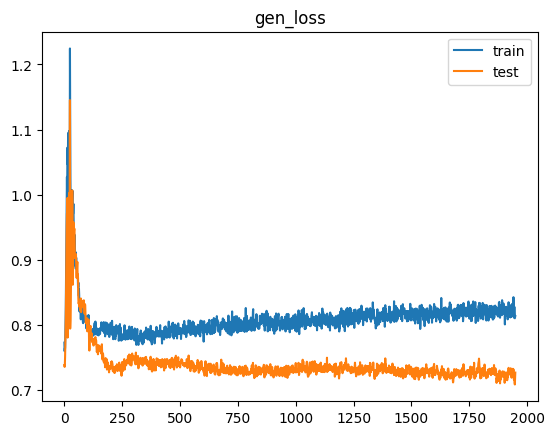

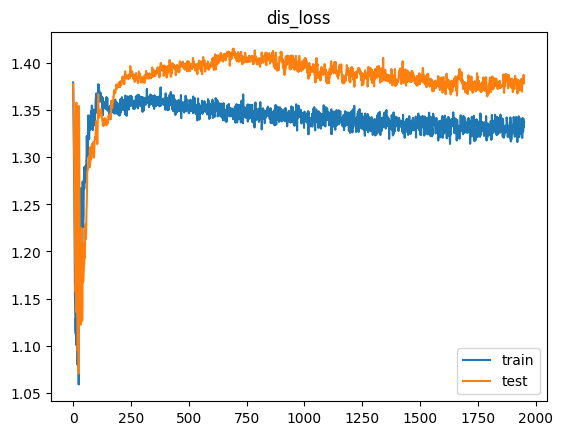

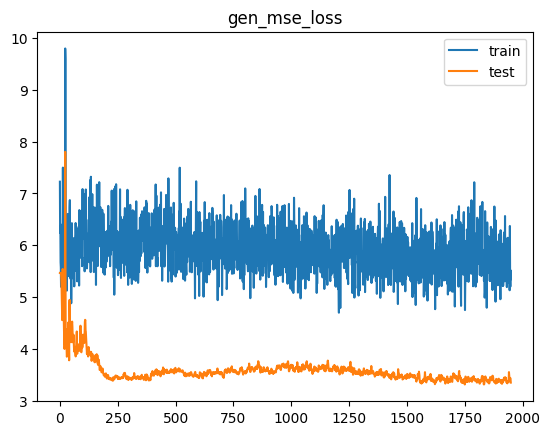

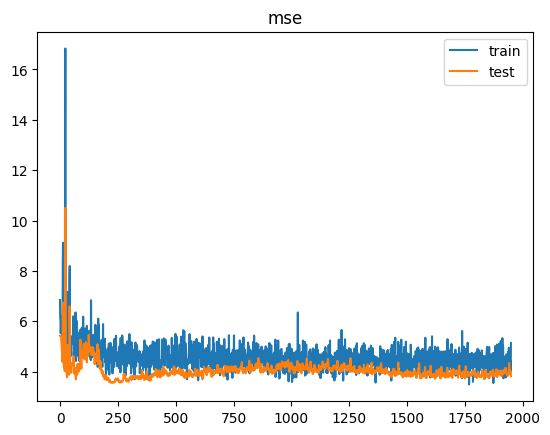

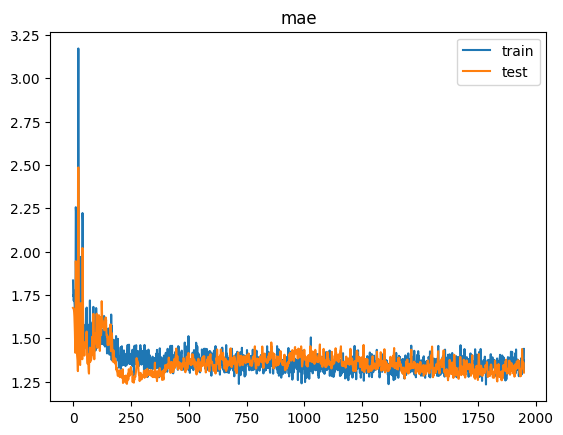

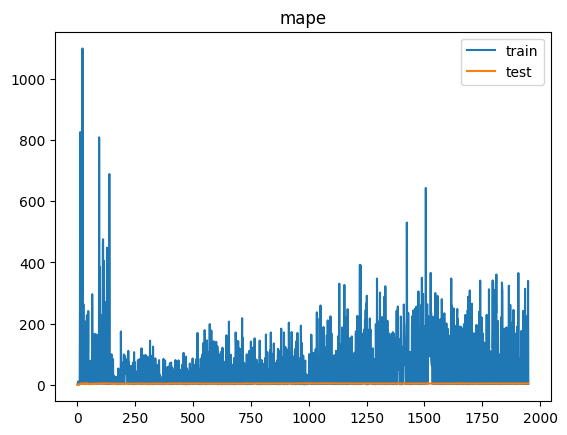

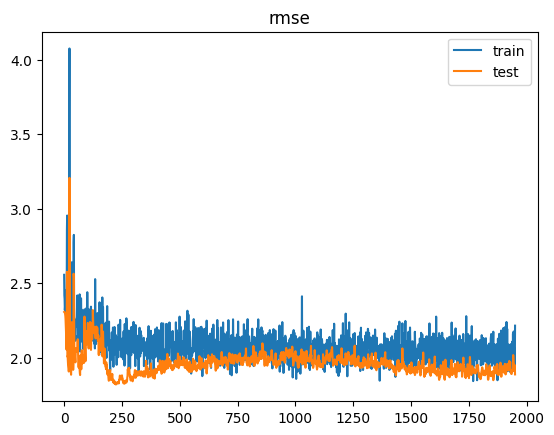

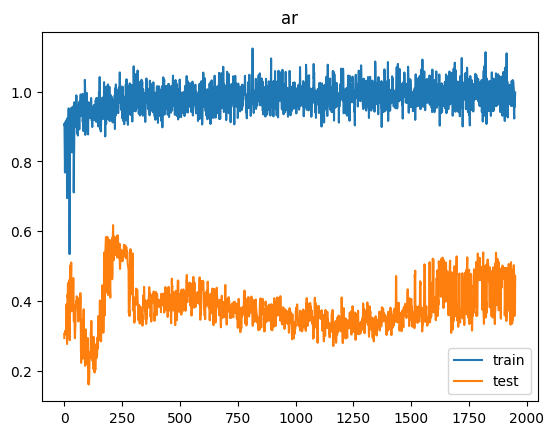

2/2 [==============================] - 1s 8ms/step


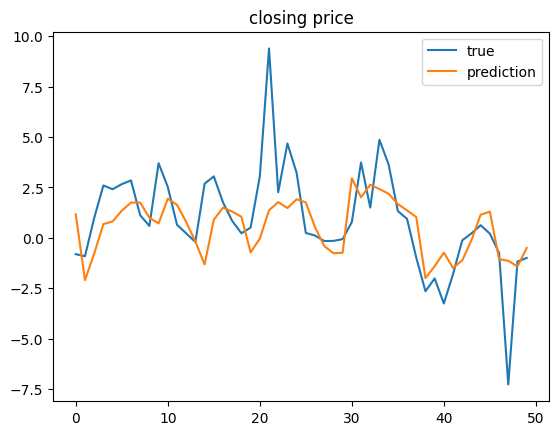

[MSE Baseline] train: 4.615741036111531  test: 3.745641536041033
Delta time with epochs = 1950: 0:31:29.092443


In [21]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))